<a href="https://colab.research.google.com/github/nguyenngoctham02da/Customer-Segmentation-and-Lifetime-Value-using-K-means-DBSCAN-XGBOOST/blob/main/Customer_Segmentation_and_Customer_Lifetime_Value_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Nạp thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
import plotly as py
import plotly.graph_objs as go
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Đọc dataset 
df = pd.read_csv("/content/drive/Shareddrives/Học kì 6/R Python (Ngọc Thẩm)/online_retail.csv",index_col=False)

# KHAI PHÁ DỮ LIỆU


In [ ]:
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

                InvoiceDate  UnitPrice  CustomerID         Country  
0       2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1       2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2       2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3       2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4       2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
...                     ...        ...         ...             ...  
541904  2011-12-09 12:50:00       0.85     12680.0          France  
541905  2011-12-09 12:50:00       2.10     12680.0          France  
541906  2011-12-09 12:50:00       4.15     12680.0          France  
541907  2011-12-09 12:50:00       4.15     12680.0          France  
541908  2011-12-09 12:50:00       4.95     12680.0          France  

[541909 rows x 8 columns]

In [ ]:
# Xem thông tin của các cột
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# Đếm số giá trị null trong từng cột. 2 cột có giá trị null, Description không quan trọng, CustomerID sẽ xóa dòng nào null
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
# Các đại lượng thống kê. Quantity với UnitPrice có giá trị âm, xóa các dòng âm
df.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [ ]:
df[df['UnitPrice']<0]

InvoiceNo StockCode      Description  Quantity          InvoiceDate  \
299983   A563186         B  Adjust bad debt         1  2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1  2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

In [ ]:
# Theo như 2 cái kết quả thì do ghi nhầm nên UnitPrice mới bị âm
# Có thể đổi số âm thành dương nhưng mà cái CustomerID null nên xử lí cách nào thì cũng sẽ xóa 2 dòng này
df[df['StockCode']=='B']

InvoiceNo StockCode      Description  Quantity          InvoiceDate  \
299982   A563185         B  Adjust bad debt         1  2011-08-12 14:50:00   
299983   A563186         B  Adjust bad debt         1  2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1  2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299982   11062.06         NaN  United Kingdom  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

In [ ]:
# Giá 0$ là do ngta nhập nhầm, nhưng mà giá biến động theo ngày và chỉ có ít dòng bị sai thôi nên xóa luôn không sửa
df[df['UnitPrice']==0]

InvoiceNo StockCode                   Description  Quantity  \
622       536414     22139                           NaN        56   
1970      536545     21134                           NaN         1   
1971      536546     22145                           NaN         1   
1972      536547     37509                           NaN         1   
1987      536549    85226A                           NaN         1   
...          ...       ...                           ...       ...   
536981    581234     72817                           NaN        27   
538504    581406    46000M  POLYESTER FILLER PAD 45x45cm       240   
538505    581406    46000S  POLYESTER FILLER PAD 40x40cm       300   
538554    581408     85175                           NaN        20   
538919    581422     23169                       smashed      -235   

                InvoiceDate  UnitPrice  CustomerID         Country  
622     2010-12-01 11:52:00        0.0         NaN  United Kingdom  
1970    2010-12-01 14:32:00        0.0         NaN  United Kingdom  
1971    2010-12-01 14:33:00        0.0         NaN  United Kingdom  
1972    2010-12-01 14:33:00        0.0         NaN  United Kingdom  
1987    2010-12-01 14:34:00        0.0         NaN  United Kingdom  
...                     ...        ...         ...             ...  
536981  2011-12-08 10:33:00        0.0         NaN  United Kingdom  
538504  2011-12-08 13:58:00        0.0         NaN  United Kingdom  
538505  2011-12-08 13:58:00        0.0         NaN  United Kingdom  
538554  2011-12-08 14:06:00        0.0         NaN  United Kingdom  
538919  2011-12-08 15:24:00        0.0         NaN  United Kingdom  

[2515 rows x 8 columns]

In [ ]:
# Các đơn hàng bị trả lại có chữ 'C' phía trước
df[df['Quantity']<0]

InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

                InvoiceDate  UnitPrice  CustomerID         Country  
141     2010-12-01 09:41:00      27.50     14527.0  United Kingdom  
154     2010-12-01 09:49:00       4.65     15311.0  United Kingdom  
235     2010-12-01 10:24:00       1.65     17548.0  United Kingdom  
236     2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
237     2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
...                     ...        ...         ...             ...  
540449  2011-12-09 09:57:00       0.83     14397.0  United Kingdom  
541541  2011-12-09 10:28:00     224.69     15498.0  United Kingdom  
541715  2011-12-09 11:57:00      10.95     15311.0  United Kingdom  
541716  2011-12-09 11:58:00       1.25     17315.0  United Kingdom  
541717  2011-12-09 11:58:00       1.25     17315.0  United Kingdom  

[10624 rows x 8 columns]

In [ ]:
# Có 4070 mã hàng được bán
df["StockCode"].nunique()

4070

In [ ]:
# Giá cao nhất và số lượng hàng hóa bán được của mỗi mã hàng
df_ = pd.DataFrame(df.groupby("StockCode").agg({"Quantity":"sum",
                              "UnitPrice":"max"}).sort_values("Quantity", ascending=False)).reset_index()
df_

StockCode  Quantity  UnitPrice
0        22197     56450       2.46
1        84077     53847       0.63
2       85099B     47363       4.95
3       85123A     38830       5.91
4        84879     36221       3.19
...        ...       ...        ...
4065   79323LP     -2618       0.00
4066    79323W     -4838       6.75
4067    72140F     -5368       0.00
4068     23003     -8516       0.42
4069     23005    -14418       1.00

[4070 rows x 3 columns]

In [ ]:
# Có 286 mã hàng có quantity âm tức là bị trả hàng
df_[df_['Quantity']<0]

StockCode  Quantity  UnitPrice
3784     85110        -1       0.00
3785    84964B        -1       0.00
3786     20957        -1       1.45
3787     20864        -1       0.00
3788     21805        -1       0.00
...        ...       ...        ...
4065   79323LP     -2618       0.00
4066    79323W     -4838       6.75
4067    72140F     -5368       0.00
4068     23003     -8516       0.42
4069     23005    -14418       1.00

[286 rows x 3 columns]

In [ ]:
# Có 4372 khách hàng đã thực hiện giao dịch
df["CustomerID"].nunique()

4372

In [ ]:
# Có 25900 giao dịch được thực hiện (bao gồm cả mua và trả hàng)
df["InvoiceNo"].nunique()

25900

In [ ]:
# Giao dịch thực hiện ở 38 quốc gia khác nhau
df['Country'].nunique()

38

In [ ]:
# Có 5268 dòng bị trùng lặp
df['is_duplicate'] = df.duplicated()
df['is_duplicate'].value_counts()

False    536641
True       5268
Name: is_duplicate, dtype: int64

In [ ]:
# Xóa cột 'is_duplicate' mới tạo bên trên
df = df.drop('is_duplicate',axis=1)

# TIỀN XỬ LÍ DỮ LIỆU

LÀM SẠCH DỮ LIỆU

In [ ]:
df1 = df.copy()

In [ ]:
# Xóa dòng bị trùng lặp
df1.drop_duplicates()

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

                InvoiceDate  UnitPrice  CustomerID         Country  
0       2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1       2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2       2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3       2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4       2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
...                     ...        ...         ...             ...  
541904  2011-12-09 12:50:00       0.85     12680.0          France  
541905  2011-12-09 12:50:00       2.10     12680.0          France  
541906  2011-12-09 12:50:00       4.15     12680.0          France  
541907  2011-12-09 12:50:00       4.15     12680.0          France  
541908  2011-12-09 12:50:00       4.95     12680.0          France  

[536641 rows x 8 columns]

In [ ]:
# Đổi kiểu dữ liệu cột InvoiceDate về kiểu datetime
df1["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [ ]:
# Cột InvoiceDate đang hiện cả ngày và giờ, chuyển thành chỉ hiện ngày
from datetime import datetime
df1["InvoiceDate"] = df1["InvoiceDate"].dt.date

In [ ]:
# Xóa các dòng có CustomerID bị null
df1 = df1[pd.notnull(df1['CustomerID'])]

In [ ]:
# Lấy các sản phẩm có UnitPrice >0
df1=df1[df1['UnitPrice']>0]

In [ ]:
# Lấy các đơn hàng có Quantity >0
df1=df1[df1['Quantity']>0]

In [ ]:
df1

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

       InvoiceDate  UnitPrice  CustomerID         Country  
0       2010-12-01       2.55     17850.0  United Kingdom  
1       2010-12-01       3.39     17850.0  United Kingdom  
2       2010-12-01       2.75     17850.0  United Kingdom  
3       2010-12-01       3.39     17850.0  United Kingdom  
4       2010-12-01       3.39     17850.0  United Kingdom  
...            ...        ...         ...             ...  
541904  2011-12-09       0.85     12680.0          France  
541905  2011-12-09       2.10     12680.0          France  
541906  2011-12-09       4.15     12680.0          France  
541907  2011-12-09       4.15     12680.0          France  
541908  2011-12-09       4.95     12680.0          France  

[397884 rows x 8 columns]

ĐƯA CÁC CỘT TƯƠNG ỨNG VỀ MÔ HÌNH RFM

In [ ]:
df2 = df1.copy()
# Thêm cột TotalPrice
df2['TotalPrice']= df2['UnitPrice'] * df2['Quantity']

# Thêm cột Avg_Monetary = TotalPrice
df2['Avg_Monetary'] = df2['TotalPrice']

# Thêm cột Tenure = InvoiceDate
df2['Tenure'] = df2['InvoiceDate']
df2.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0  2010-12-01       2.55     17850.0  United Kingdom       15.30   
1  2010-12-01       3.39     17850.0  United Kingdom       20.34   
2  2010-12-01       2.75     17850.0  United Kingdom       22.00   
3  2010-12-01       3.39     17850.0  United Kingdom       20.34   
4  2010-12-01       3.39     17850.0  United Kingdom       20.34   

   Avg_Monetary      Tenure  
0         15.30  2010-12-01  
1         20.34  2010-12-01  
2         22.00  2010-12-01  
3         20.34  2010-12-01  
4         20.34  2010-12-01

In [ ]:
# Xem ngày giao dịch gần đây nhất

df2["InvoiceDate"].max()

datetime.date(2011, 12, 9)

In [ ]:
import datetime

# Chọn current_date cách ngày cuối cùng 1 ngày tức là ngày 10/12/2011
current_date = df2["InvoiceDate"].max() + datetime.timedelta(days=1)
print(current_date)

# Đưa các cột tương ứng về mô hình RFM
rfm = df2.groupby(['CustomerID','Country']).agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,
    "InvoiceNo": lambda InvoiceNo: InvoiceNo.nunique(),
    'TotalPrice': 'sum',
    'Avg_Monetary':'mean',
    'Tenure': lambda y: (current_date - y.min()).days})

# Gán tên cho các cột
rfm.columns = ["Recency", "Frequency", "Monetary","Avg_Monetary","Tenure"]

2011-12-10


In [ ]:
rfm = pd.DataFrame(rfm).reset_index()

In [ ]:
rfm

CustomerID         Country  Recency  Frequency  Monetary  Avg_Monetary  \
0        12346.0  United Kingdom      326          1  77183.60  77183.600000   
1        12347.0         Iceland        3          7   4310.00     23.681319   
2        12348.0         Finland       76          4   1797.24     57.975484   
3        12349.0           Italy       19          1   1757.55     24.076027   
4        12350.0          Norway      311          1    334.40     19.670588   
...          ...             ...      ...        ...       ...           ...   
4341     18280.0  United Kingdom      278          1    180.60     18.060000   
4342     18281.0  United Kingdom      181          1     80.82     11.545714   
4343     18282.0  United Kingdom        8          2    178.05     14.837500   
4344     18283.0  United Kingdom        4         16   2094.88      2.771005   
4345     18287.0  United Kingdom       43          3   1837.28     26.246857   

      Tenure  
0        326  
1        368  
2        359  
3         19  
4        311  
...      ...  
4341     278  
4342     181  
4343     127  
4344     338  
4345     202  

[4346 rows x 7 columns]

In [ ]:
rfm.describe()

CustomerID      Recency    Frequency       Monetary  Avg_Monetary  \
count   4346.000000  4346.000000  4346.000000    4346.000000   4346.000000   
mean   15295.109296    93.265992     4.264151    2050.485022     68.330596   
std     1724.643552   100.115202     7.691263    8981.083042   1466.569834   
min    12346.000000     1.000000     1.000000       3.750000      2.101286   
25%    13807.250000    18.000000     1.000000     307.465000     12.371283   
50%    15294.000000    51.000000     2.000000     672.530000     17.747784   
75%    16776.750000   143.000000     5.000000    1661.262500     24.858417   
max    18287.000000   374.000000   209.000000  280206.020000  77183.600000   

            Tenure  
count  4346.000000  
mean    223.790152  
std     117.817382  
min       1.000000  
25%     113.000000  
50%     249.000000  
75%     327.000000  
max     374.000000

KIỂM TRA OUTLIER VÀ XỬ LÍ

In [ ]:
rfm1 = rfm.copy()

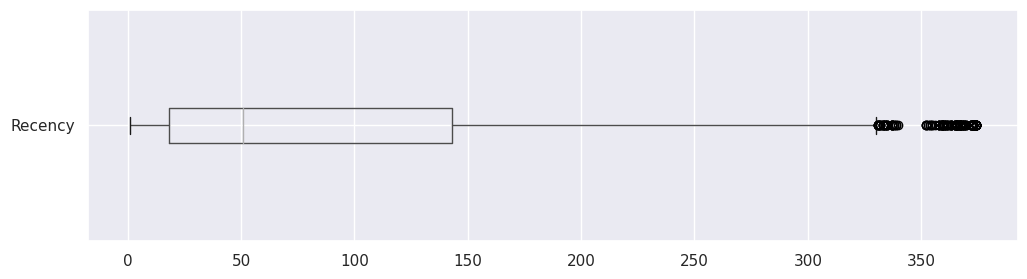

In [ ]:
sns.set(rc = {"figure.figsize" : (12,3)})

rfm1[["Recency"]].boxplot( vert=False);

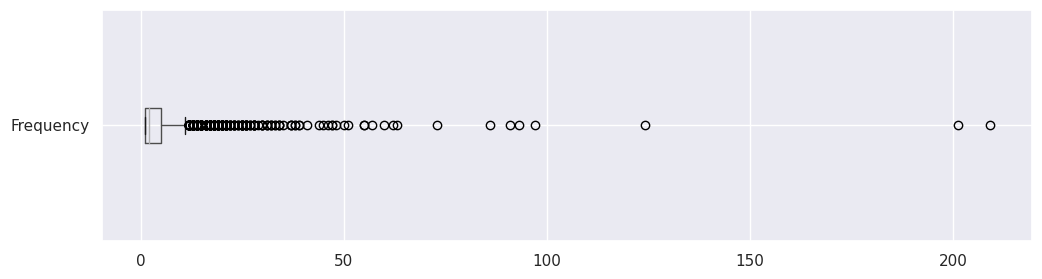

In [ ]:
# Biểu diễn phân phối của Frequency
sns.set(rc = {"figure.figsize" : (12,3)})

rfm1[["Frequency"]].boxplot( vert=False);

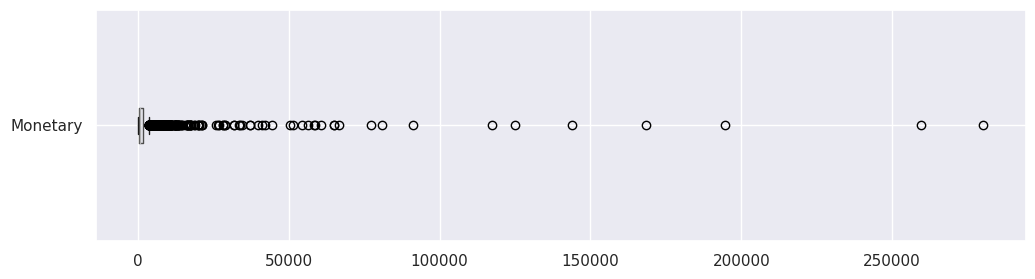

In [ ]:
# Biểu diễn phân phối của Monetary
sns.set(rc = {"figure.figsize" : (12,3)})

rfm1[["Monetary"]].boxplot(vert=False);

<ipython-input-38-ecba6ba6786d>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm1['Recency'], ax = ax[0])
<ipython-input-38-ecba6ba6786d>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm1['Frequency'], ax = ax[1])
<ipython-input-38-ecba6ba6786d>:5: UserWarning: 

`distplot` is a deprecat

<Axes: xlabel='Monetary', ylabel='Density'>

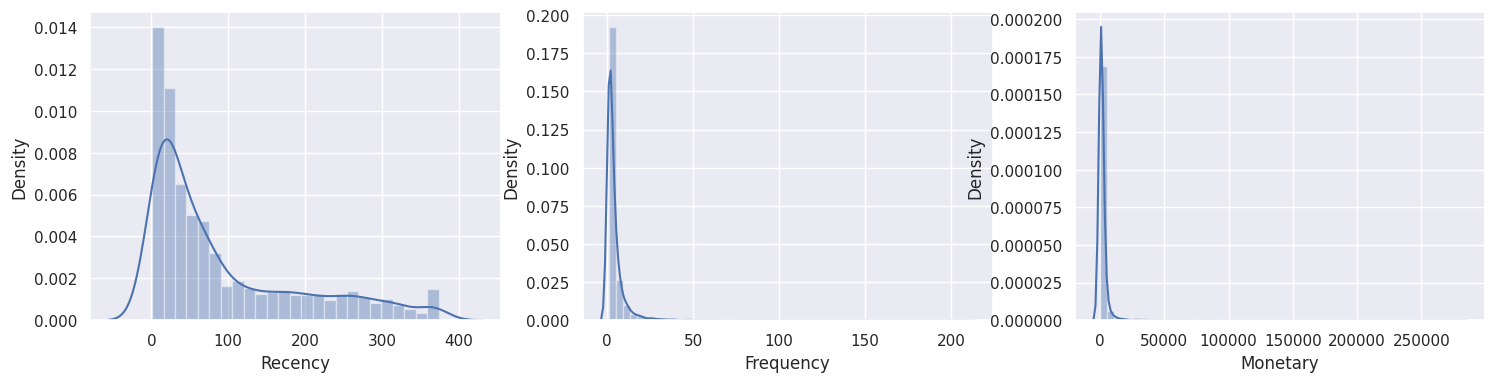

In [ ]:
# Biểu diễn phân phối 3 cột trước khi bỏ outlier
fig, ax = plt.subplots(1, 3, figsize=(18,4))
sns.distplot(rfm1['Recency'], ax = ax[0])
sns.distplot(rfm1['Frequency'], ax = ax[1])
sns.distplot(rfm1['Monetary'], ax = ax[2])


In [ ]:
# Tính điểm zscore cho các dòng trong cột Monetary
z = np.abs(stats.zscore(rfm1[['Monetary']]))
print(z)

      Monetary
0     8.366670
1     0.251615
2     0.028201
3     0.032621
4     0.191100
...        ...
4341  0.208227
4342  0.219338
4343  0.208511
4344  0.004944
4345  0.023742

[4346 rows x 1 columns]


In [ ]:
# In ra các giá trị Monetary có zscore > 3
threshold = 3
print(np.where(z > 3))

(array([   0,   57,  334,  461,  570, 1004, 1077, 1292, 1297, 1341, 1442,
       1697, 1887, 1991, 2019, 2184, 2510, 2525, 2578, 2696, 2710, 2998,
       3016, 3184, 3691, 3701, 3736, 3779, 4018, 4101, 4209]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0]))


In [ ]:
# Xóa các dòng có zscore của Monetary > 3
rfm1 = rfm1[(z < 3).all(axis=1)]


In [ ]:
rfm1

CustomerID         Country  Recency  Frequency  Monetary  Avg_Monetary  \
1        12347.0         Iceland        3          7   4310.00     23.681319   
2        12348.0         Finland       76          4   1797.24     57.975484   
3        12349.0           Italy       19          1   1757.55     24.076027   
4        12350.0          Norway      311          1    334.40     19.670588   
5        12352.0          Norway       37          8   2506.04     29.482824   
...          ...             ...      ...        ...       ...           ...   
4341     18280.0  United Kingdom      278          1    180.60     18.060000   
4342     18281.0  United Kingdom      181          1     80.82     11.545714   
4343     18282.0  United Kingdom        8          2    178.05     14.837500   
4344     18283.0  United Kingdom        4         16   2094.88      2.771005   
4345     18287.0  United Kingdom       43          3   1837.28     26.246857   

      Tenure  
1        368  
2        359  
3         19  
4        311  
5        297  
...      ...  
4341     278  
4342     181  
4343     127  
4344     338  
4345     202  

[4315 rows x 7 columns]

In [ ]:
# Hàm xác định outlier bằng IQR, và xử lí outlier bằng cách gán các outlier bằng giá trị lớn nhất hoặc nhỏ nhất
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin


def find_boxplot_boundaries(
    col: pd.Series, whisker_coeff: float = 1.5
) -> Tuple[float, float]:
    """Findx minimum and maximum in boxplot.

    Args:
        col: a pandas serires of input.
        whisker_coeff: whisker coefficient in box plot
    """
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper


class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boxplot_boundaries(X, self.whisker)
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)

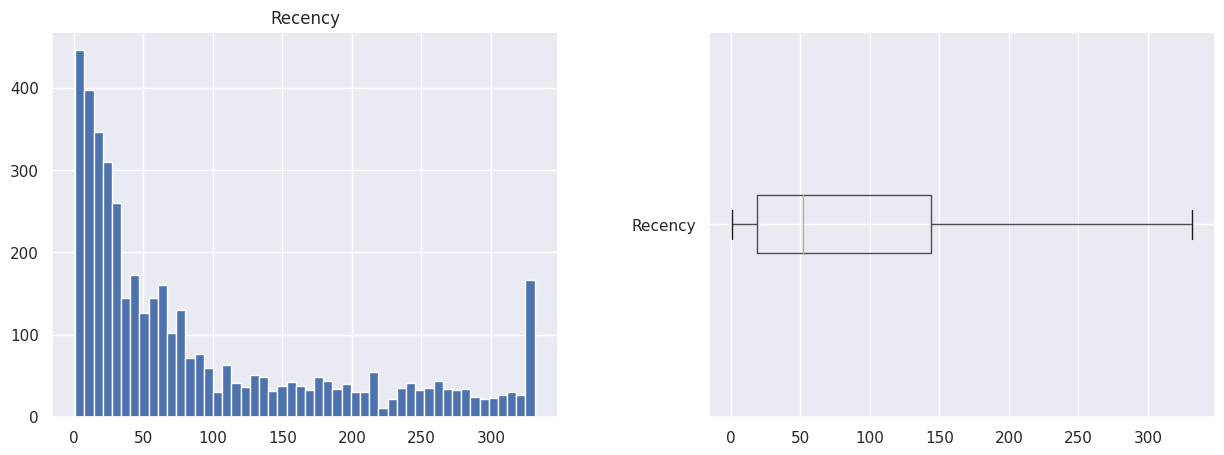

In [ ]:
# Xử lí outlier của Recency 
rfm1['Recency'] = BoxplotOutlierClipper().fit_transform(rfm1['Recency'])

# Biểu đồ phân phối
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
rfm1[['Recency']].hist(bins=50, ax=axes[0])
rfm1[['Recency']].boxplot(ax=axes[1], vert=False);

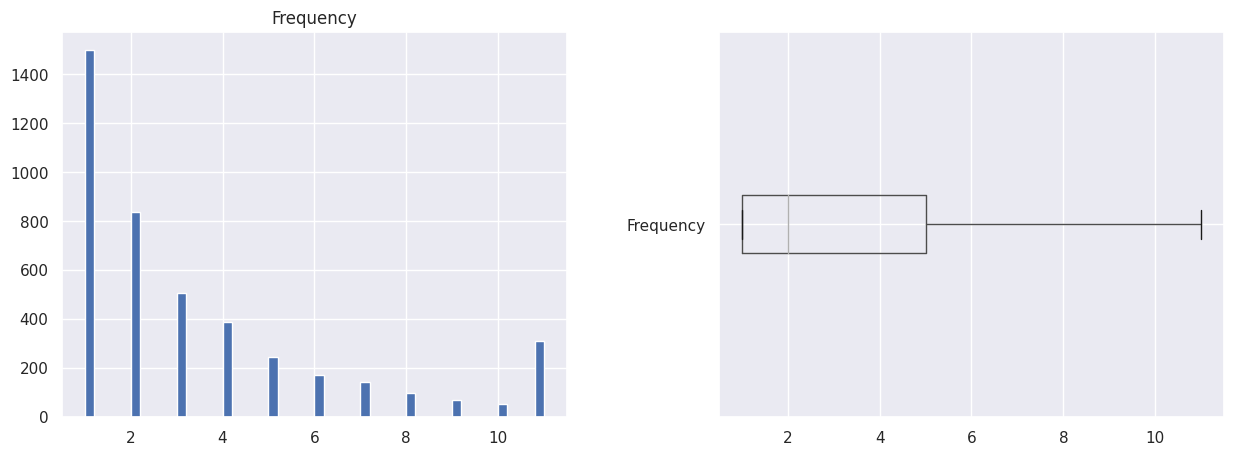

In [ ]:
# Xử lí outlier của Frequency
rfm1['Frequency'] = BoxplotOutlierClipper().fit_transform(rfm1['Frequency'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
rfm1[['Frequency']].hist(bins=50, ax=axes[0])
rfm1[['Frequency']].boxplot(ax=axes[1], vert=False);

<ipython-input-46-4ad57923c375>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm1['Recency'], ax = ax[0])
<ipython-input-46-4ad57923c375>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm1['Frequency'], ax = ax[1])
<ipython-input-46-4ad57923c375>:5: UserWarning: 

`distplot` is a deprecat

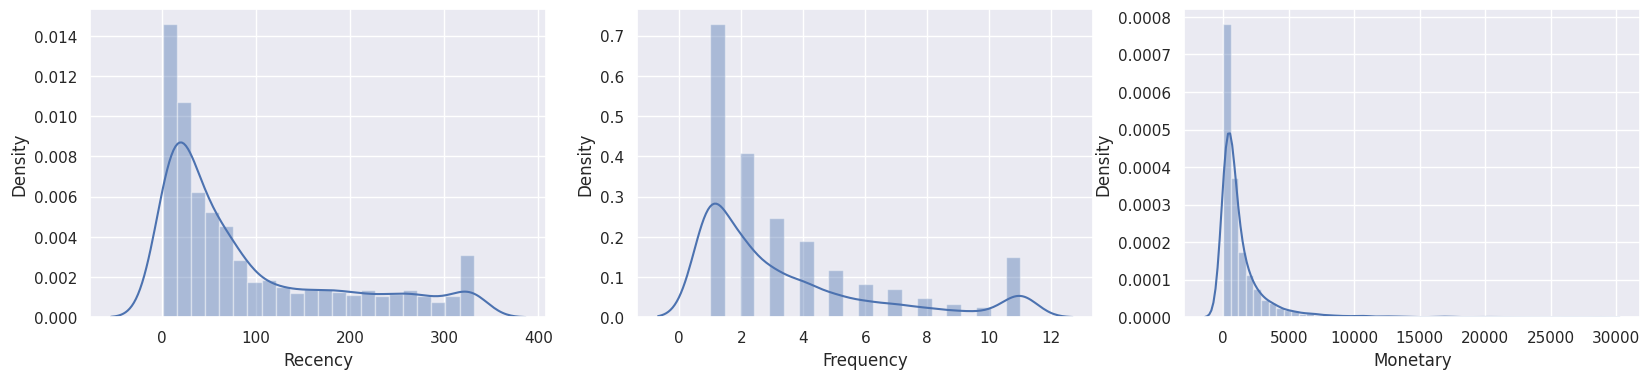

In [ ]:
# Biểu diễn phân phối 3 cột sau khi bỏ outlier
fig, ax = plt.subplots(1, 3, figsize=(20,4))
sns.distplot(rfm1['Recency'], ax = ax[0])
sns.distplot(rfm1['Frequency'], ax = ax[1])
sns.distplot(rfm1['Monetary'], ax = ax[2])

plt.show()

In [ ]:
# Đánh stt lại, tại vì bỏ bớt dòng nên stt bị thay đổi, bỏ cột stt cũ
rfm1 = rfm1.reset_index().drop(['index'],axis=1)

ĐƯA VỀ PHÂN PHỐI CHUẨN

In [ ]:
# Thiết kế hàm trả về độ lệch của biến X khi thực hiện các phương pháp biển đổi như: biến đổi log, căn bậc hai và biến đổi Box-Cox.

def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(7,7))
    sns.distplot(x, ax=ax[0,0])
    sns.distplot(np.log(x), ax=ax[0,1])
    sns.distplot(np.sqrt(x), ax=ax[1,0])
    sns.distplot(stats.boxcox(x)[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    skewness = [x.skew().round(2), 
                np.log(x).skew().round(2),
                np.sqrt(x).skew().round(2),
                pd.Series(stats.boxcox(x)[0]).skew().round(2)]
    return skewness

<ipython-input-48-c00f209a3a2d>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax[0,0])
<ipython-input-48-c00f209a3a2d>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(x), ax=ax[0,1])
<ipython-input-48-c00f209a3a2d>:7: UserWarning: 

`distplot` is a deprecated function and will b

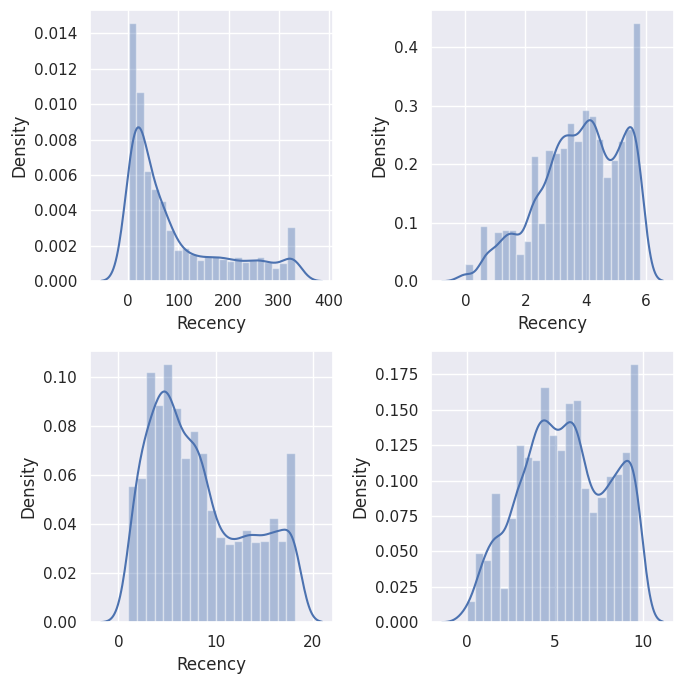

[1.16, -0.48, 0.56, -0.07]

In [ ]:
# Kết quả biển đổi cho thấy cột dữ liệu Recency ban đầu có thể áp dụng biến đổi sqrt để đưa về gần với độ lệch chuẩn nhất
analyze_skewness(rfm1['Recency'])

<ipython-input-48-c00f209a3a2d>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax[0,0])
<ipython-input-48-c00f209a3a2d>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(x), ax=ax[0,1])
<ipython-input-48-c00f209a3a2d>:7: UserWarning: 

`distplot` is a deprecated function and will b

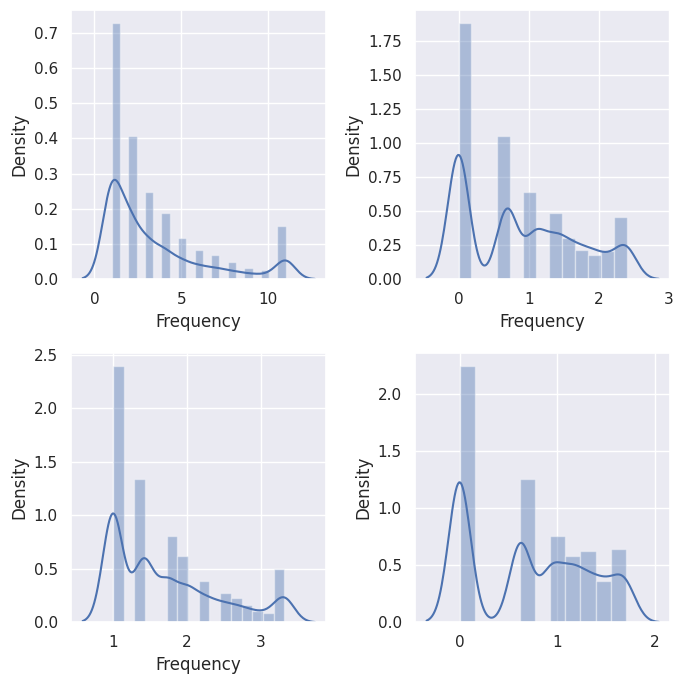

[1.36, 0.37, 0.87, 0.11]

In [ ]:
# Kết quả biển đổi cho thấy cột dữ liệu Frequency ban đầu có thể áp dụng biến đổi Box-cox để đưa về gần với độ lệch chuẩn nhất
analyze_skewness(rfm1['Frequency'])

<ipython-input-51-a18da77c5a07>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm1['Monetary'], ax=ax[0])
<ipython-input-51-a18da77c5a07>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.cbrt(rfm1['Monetary']), ax=ax[1])


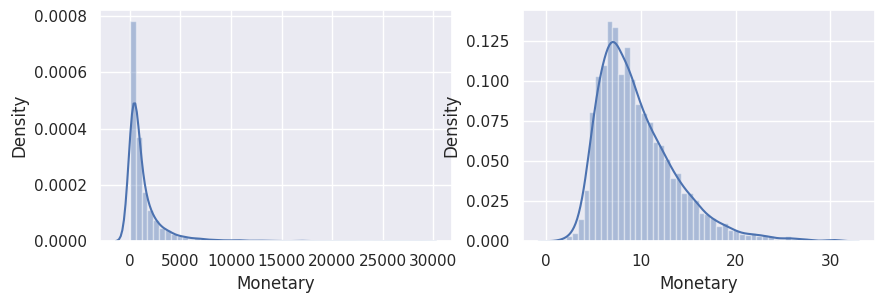

4.92
1.3


In [ ]:
# Này coi bài mẫu ngta chọn căn bậc 3 để biến đổi về phân phối chuẩn 
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(rfm1['Monetary'], ax=ax[0])
sns.distplot(np.cbrt(rfm1['Monetary']), ax=ax[1])
plt.show()
print(rfm1['Monetary'].skew().round(2))
print(np.cbrt(rfm1['Monetary']).skew().round(2))

In [ ]:
# Đưa các cột về phân phối chuẩn theo phương thức đã chọn
rfm2 = pd.DataFrame()

rfm2['CustomerID'] = rfm1['CustomerID']
rfm2['Country'] = rfm1['Country']
rfm2['Recency'] = pd.Series(np.sqrt(rfm1['Recency'])).values
rfm2['Frequency'] = stats.boxcox(rfm1['Frequency'])[0]
rfm2['Monetary'] = pd.Series(np.cbrt(rfm1['Monetary'])).values
rfm2['Avg_Monetary'] = rfm1['Avg_Monetary']
rfm2['Tenure'] = rfm1['Tenure']

SCALE DATA

In [ ]:
# Đây là bước scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler1.fit(rfm2[['Recency','Monetary']])

rfm_t = pd.DataFrame(scaler1.transform(rfm2[['Recency','Monetary']]))

In [ ]:
from sklearn import preprocessing
scaler2 = preprocessing.StandardScaler().fit (rfm2[['Frequency']])
rfm_t[['Frequency']] = scaler2.transform(rfm2[['Frequency']])

In [ ]:
rfm_t

0         1  Frequency
0     0.042543  0.505367   1.258430
1     0.448523  0.364068   0.698522
2     0.195204  0.360973  -1.179308
3     0.966761  0.184956  -1.179308
4     0.295387  0.412984   1.378493
...        ...       ...        ...
4310  0.910862  0.140719  -1.179308
4311  0.723747  0.095095  -1.179308
4312  0.106260  0.139802  -0.141519
4313  0.058115  0.385944   1.645843
4314  0.322973  0.367145   0.371282

[4315 rows x 3 columns]

In [ ]:
# Gán tên cho cột
rfm_t.columns = ["Recency","Monetary","Frequency" ]

rfm_t

Recency  Monetary  Frequency
0     0.042543  0.505367   1.258430
1     0.448523  0.364068   0.698522
2     0.195204  0.360973  -1.179308
3     0.966761  0.184956  -1.179308
4     0.295387  0.412984   1.378493
...        ...       ...        ...
4310  0.910862  0.140719  -1.179308
4311  0.723747  0.095095  -1.179308
4312  0.106260  0.139802  -0.141519
4313  0.058115  0.385944   1.645843
4314  0.322973  0.367145   0.371282

[4315 rows x 3 columns]

In [ ]:
# Thêm các cột rfm2 vào rfm_t
rfm_t[['CustomerID','Country','Tenure','Avg_Monetary']] = rfm2[['CustomerID','Country','Tenure','Avg_Monetary']]

In [ ]:
rfm_t

Recency  Monetary  Frequency  CustomerID         Country  Tenure  \
0     0.042543  0.505367   1.258430     12347.0         Iceland     368   
1     0.448523  0.364068   0.698522     12348.0         Finland     359   
2     0.195204  0.360973  -1.179308     12349.0           Italy      19   
3     0.966761  0.184956  -1.179308     12350.0          Norway     311   
4     0.295387  0.412984   1.378493     12352.0          Norway     297   
...        ...       ...        ...         ...             ...     ...   
4310  0.910862  0.140719  -1.179308     18280.0  United Kingdom     278   
4311  0.723747  0.095095  -1.179308     18281.0  United Kingdom     181   
4312  0.106260  0.139802  -0.141519     18282.0  United Kingdom     127   
4313  0.058115  0.385944   1.645843     18283.0  United Kingdom     338   
4314  0.322973  0.367145   0.371282     18287.0  United Kingdom     202   

      Avg_Monetary  
0        23.681319  
1        57.975484  
2        24.076027  
3        19.670588  
4        29.482824  
...            ...  
4310     18.060000  
4311     11.545714  
4312     14.837500  
4313      2.771005  
4314     26.246857  

[4315 rows x 7 columns]

<ipython-input-59-5387c8696a4c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_t['Recency'], ax = ax[0])
<ipython-input-59-5387c8696a4c>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_t['Frequency'], ax = ax[1])
<ipython-input-59-5387c8696a4c>:5: UserWarning: 

`distplot` is a deprec

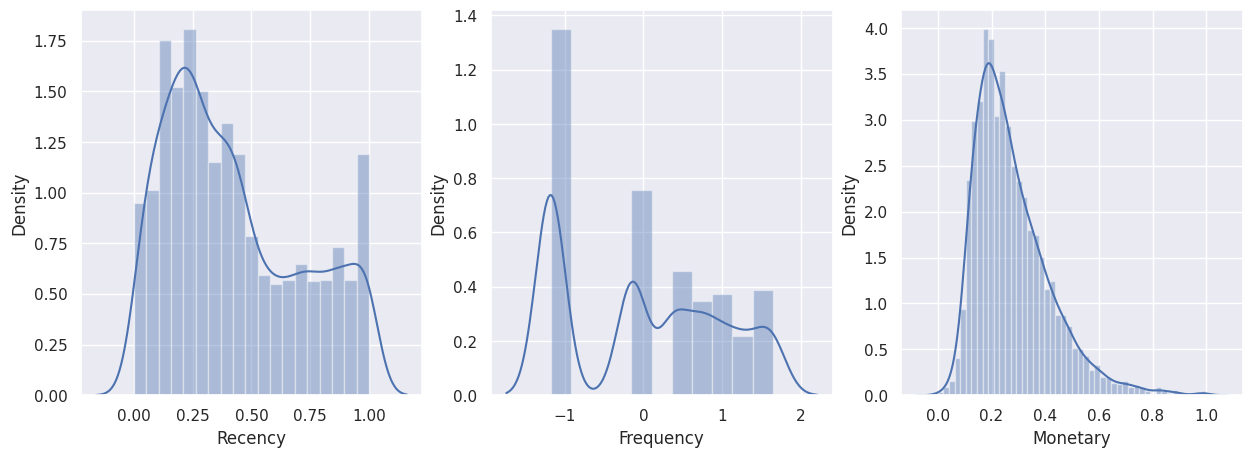

In [ ]:
# Biểu diễn lại phân phối hiện tại của 3 cột
fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.distplot(rfm_t['Recency'], ax = ax[0])
sns.distplot(rfm_t['Frequency'], ax = ax[1])
sns.distplot(rfm_t['Monetary'], ax = ax[2])

plt.show()

# K-MEANS

In [ ]:
rfm2 = rfm_t[['Recency','Frequency','Monetary']]

In [ ]:
# Tính Distortion khi k chạy từ 1-9
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeanModel.fit(rfm2)
    distortions.append(kmeanModel.inertia_)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

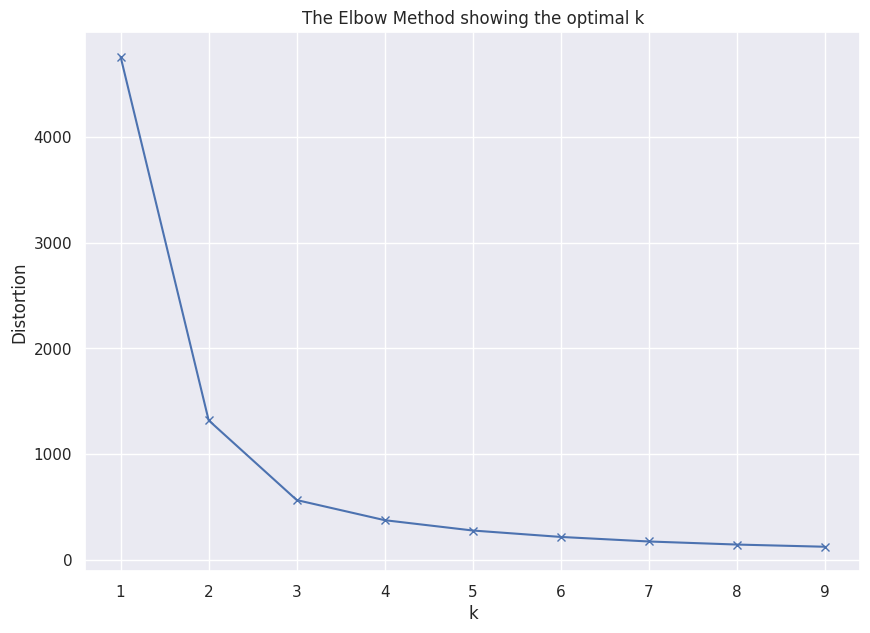

In [ ]:
# Biểu diễn giá trị của Distortion khi k chạy từ 2-9
plt.figure(figsize=(10,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# Tính Silhouette_score khi k chạy từ 2-9
from matplotlib.legend import Shadow
from sklearn.metrics import silhouette_score
score = []
K = range(2,10)
for k in K:
    km = KMeans (n_clusters = k)
    km.fit(rfm2)
    score.append(silhouette_score (rfm2, km.labels_, metric = 'euclidean'))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

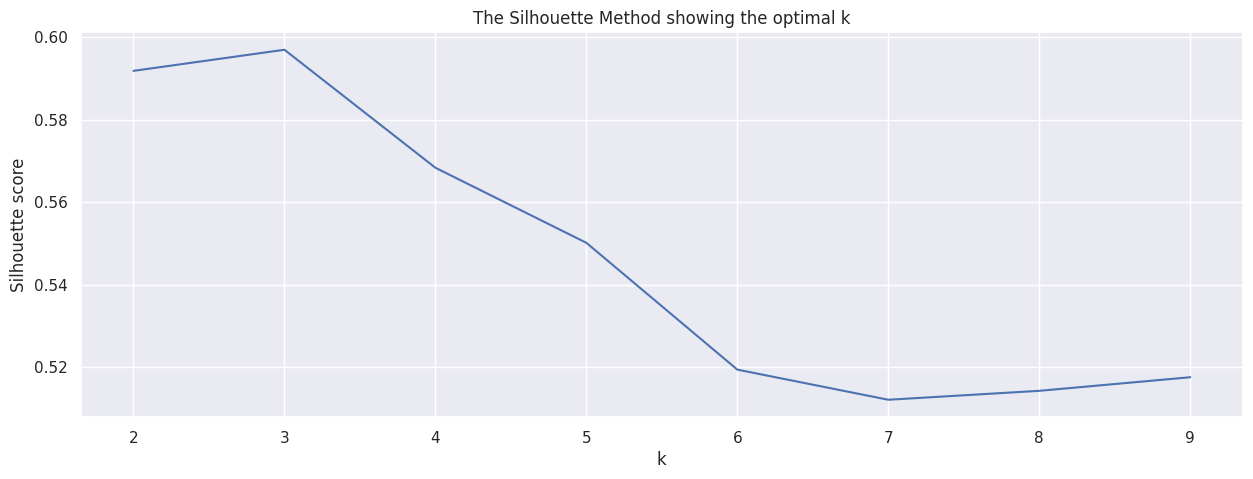

In [ ]:
# Biểu diễn Silhouette_score khi k chạy từ 2-9
plt.figure(figsize=(15,5))
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('The Silhouette Method showing the optimal k')
plt.show()

In [ ]:
# Điểm Silhouette khi k chạy từ 2-9
score

[0.5918390904788812,
 0.5969599227848743,
 0.5683423249994121,
 0.5501381538701237,
 0.5193868216209248,
 0.512085015481875,
 0.514249857128039,
 0.5175477250673903]

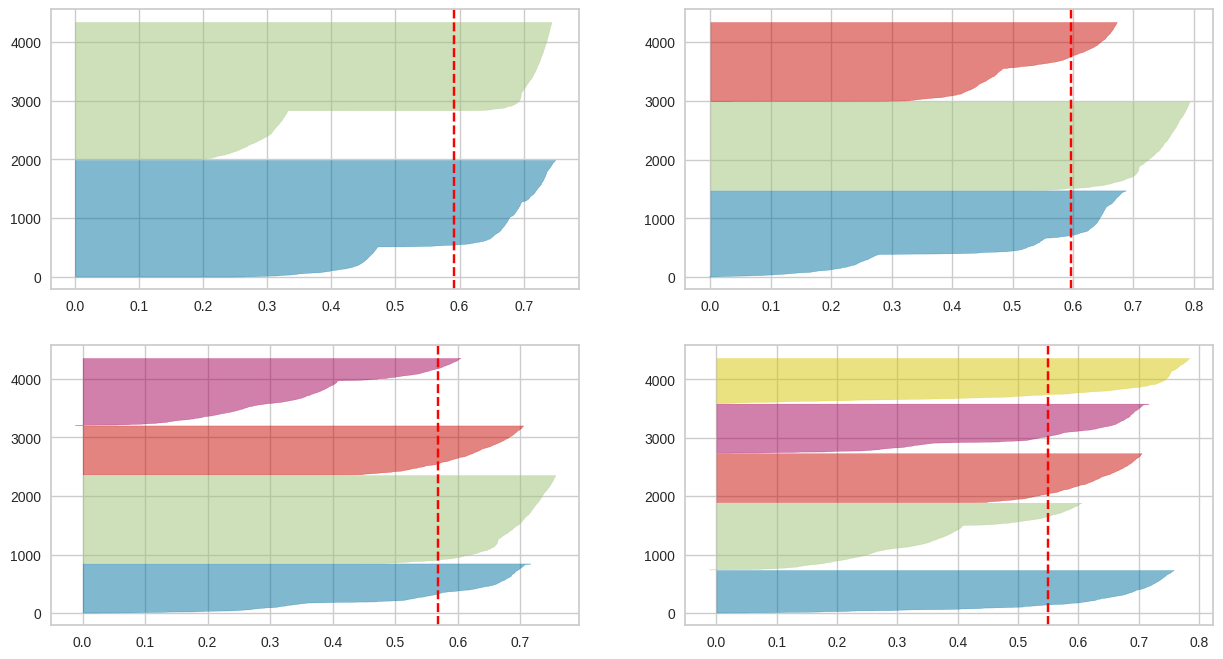

In [ ]:
# Sơ đồ Silhouette (Silhouette diagram)
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(rfm2)

Chọn k=3 vì khi tăng k từ 3 lên 4 thì Distortion có thay đổi không đáng kể và điểm Silhouette tại k=3 cũng cao nhất

In [ ]:
# Sử dụng k=3 để phân cụm dữ liệu
km3 = KMeans(n_clusters=3,init='k-means++', max_iter=1000, random_state = 42)
km3 = km3.fit(rfm2)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Nối bảng
labels=km3.labels_
labels=pd.DataFrame(labels, columns=['Cluster'])
km_clustered=pd.concat([rfm_t,labels] , axis=1)
km_clustered

Recency  Monetary  Frequency  CustomerID         Country  Tenure  \
0     0.042543  0.505367   1.258430     12347.0         Iceland     368   
1     0.448523  0.364068   0.698522     12348.0         Finland     359   
2     0.195204  0.360973  -1.179308     12349.0           Italy      19   
3     0.966761  0.184956  -1.179308     12350.0          Norway     311   
4     0.295387  0.412984   1.378493     12352.0          Norway     297   
...        ...       ...        ...         ...             ...     ...   
4310  0.910862  0.140719  -1.179308     18280.0  United Kingdom     278   
4311  0.723747  0.095095  -1.179308     18281.0  United Kingdom     181   
4312  0.106260  0.139802  -0.141519     18282.0  United Kingdom     127   
4313  0.058115  0.385944   1.645843     18283.0  United Kingdom     338   
4314  0.322973  0.367145   0.371282     18287.0  United Kingdom     202   

      Avg_Monetary  Cluster  
0        23.681319        0  
1        57.975484        0  
2        24.076027        1  
3        19.670588        1  
4        29.482824        0  
...            ...      ...  
4310     18.060000        1  
4311     11.545714        1  
4312     14.837500        2  
4313      2.771005        0  
4314     26.246857        2  

[4315 rows x 8 columns]

In [ ]:
km_clustered.groupby('Cluster').size()

Cluster
0    1468
1    1498
2    1349
dtype: int64

In [ ]:
# Tìm tâm của cụm
centroids= km3.cluster_centers_
centroids=pd.DataFrame(centroids, columns=['Centroid_Recency','Centroid_Frequency','Centroid_Monetary'])
centroids

Centroid_Recency  Centroid_Frequency  Centroid_Monetary
0          0.238552            1.153489           0.411035
1          0.606189           -1.179308           0.172589
2          0.420091            0.054323           0.250613

In [ ]:
# Vẽ đồ thị 3d có xác định tâm cụm
import plotly.graph_objs as go

km_clustered['labels'] = labels

trace1 = go.Scatter3d(
    x=km_clustered['Recency'],
    y=km_clustered['Frequency'],
    z=km_clustered['Monetary'],
    mode='markers',
    marker=dict(
        color=km_clustered['labels'], 
        size=3, 
        line=dict(color=km_clustered['labels'], width=15),
        opacity=1
    ),
    name='Clustered Data'
)

trace2 = go.Scatter3d(
    x=centroids['Centroid_Recency'],
    y=centroids['Centroid_Frequency'],
    z=centroids['Centroid_Monetary'],
    mode='markers',
    marker=dict(
        color='red', 
        size=12,
        opacity=1
    ),
    name='Centroids'
)

data = [trace1, trace2]
layout = go.Layout(
    title='Clusters',
    scene=dict(
        xaxis=dict(title='Recency'),
        yaxis=dict(title='Frequency'),
        zaxis=dict(title='Monetary')
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()

In [ ]:
from sklearn import metrics
from sklearn.datasets import make_blobs

# Tính CH index
ch_score = metrics.calinski_harabasz_score(rfm_t[['Recency','Frequency',	'Monetary']], labels)

# Tính DB index
db_score = metrics.davies_bouldin_score(rfm_t[['Recency','Frequency',	'Monetary']], labels)

# In kết quả
print("CH index score:", ch_score)
print("DB index score:", db_score)

CH index score: 15856.047419570006
DB index score: 0.6013628814600176


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
# Gắn nhãn ngược vào bảng dữ liệu chưa scale
km_clustered1=pd.concat([rfm1,labels] , axis=1)

In [ ]:
km_clustered1

CustomerID         Country  Recency  Frequency  Monetary  Avg_Monetary  \
0        12347.0         Iceland      3.0        7.0   4310.00     23.681319   
1        12348.0         Finland     76.0        4.0   1797.24     57.975484   
2        12349.0           Italy     19.0        1.0   1757.55     24.076027   
3        12350.0          Norway    311.0        1.0    334.40     19.670588   
4        12352.0          Norway     37.0        8.0   2506.04     29.482824   
...          ...             ...      ...        ...       ...           ...   
4310     18280.0  United Kingdom    278.0        1.0    180.60     18.060000   
4311     18281.0  United Kingdom    181.0        1.0     80.82     11.545714   
4312     18282.0  United Kingdom      8.0        2.0    178.05     14.837500   
4313     18283.0  United Kingdom      4.0       11.0   2094.88      2.771005   
4314     18287.0  United Kingdom     43.0        3.0   1837.28     26.246857   

      Tenure  Cluster  
0        368        0  
1        359        0  
2         19        1  
3        311        1  
4        297        0  
...      ...      ...  
4310     278        1  
4311     181        1  
4312     127        2  
4313     338        0  
4314     202        2  

[4315 rows x 8 columns]

In [ ]:
km_clustered1[km_clustered1['Cluster']==1]

CustomerID         Country  Recency  Frequency  Monetary  Avg_Monetary  \
2        12349.0           Italy     19.0        1.0   1757.55     24.076027   
3        12350.0          Norway    311.0        1.0    334.40     19.670588   
5        12353.0         Bahrain    205.0        1.0     89.00     22.250000   
6        12354.0           Spain    233.0        1.0   1079.40     18.610345   
7        12355.0         Bahrain    215.0        1.0    459.40     35.338462   
...          ...             ...      ...        ...       ...           ...   
4307     18276.0  United Kingdom     44.0        1.0    335.86     23.990000   
4308     18277.0  United Kingdom     59.0        1.0    110.38     13.797500   
4309     18278.0  United Kingdom     74.0        1.0    173.90     19.322222   
4310     18280.0  United Kingdom    278.0        1.0    180.60     18.060000   
4311     18281.0  United Kingdom    181.0        1.0     80.82     11.545714   

      Tenure  Cluster  
2         19        1  
3        311        1  
5        205        1  
6        233        1  
7        215        1  
...      ...      ...  
4307      44        1  
4308      59        1  
4309      74        1  
4310     278        1  
4311     181        1  

[1498 rows x 8 columns]

In [ ]:
# Vẽ đồ thị 3d
km_clustered1['labels'] = labels

trace = go.Scatter3d(
                    x = km_clustered1['Recency'],
                    y = km_clustered1['Frequency'],
                    z = km_clustered1['Monetary'],
                    mode = 'markers',
                    marker=dict(color=km_clustered1['labels'], size =3, line=dict(color=km_clustered1['labels'], width=15), opacity=1)
                    )

    
data = [trace]
layout = go.Layout(
                    title='Clusters',
                    scene= dict(
                                xaxis = dict(title = 'Recency'),
                                yaxis = dict(title = 'Frequency'),
                                zaxis = dict(title = 'Monetary'))
                                )


fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)
plt.show()

# DBSCAN

In [ ]:
rfm_t

Recency  Monetary  Frequency  CustomerID         Country  Tenure  \
0     0.042543  0.505367   1.258430     12347.0         Iceland     368   
1     0.448523  0.364068   0.698522     12348.0         Finland     359   
2     0.195204  0.360973  -1.179308     12349.0           Italy      19   
3     0.966761  0.184956  -1.179308     12350.0          Norway     311   
4     0.295387  0.412984   1.378493     12352.0          Norway     297   
...        ...       ...        ...         ...             ...     ...   
4310  0.910862  0.140719  -1.179308     18280.0  United Kingdom     278   
4311  0.723747  0.095095  -1.179308     18281.0  United Kingdom     181   
4312  0.106260  0.139802  -0.141519     18282.0  United Kingdom     127   
4313  0.058115  0.385944   1.645843     18283.0  United Kingdom     338   
4314  0.322973  0.367145   0.371282     18287.0  United Kingdom     202   

      Avg_Monetary  
0        23.681319  
1        57.975484  
2        24.076027  
3        19.670588  
4        29.482824  
...            ...  
4310     18.060000  
4311     11.545714  
4312     14.837500  
4313      2.771005  
4314     26.246857  

[4315 rows x 7 columns]

Text(0.5, 1.0, 'Sorting Maximum Distance in k Nearest Neighbor of kNN')

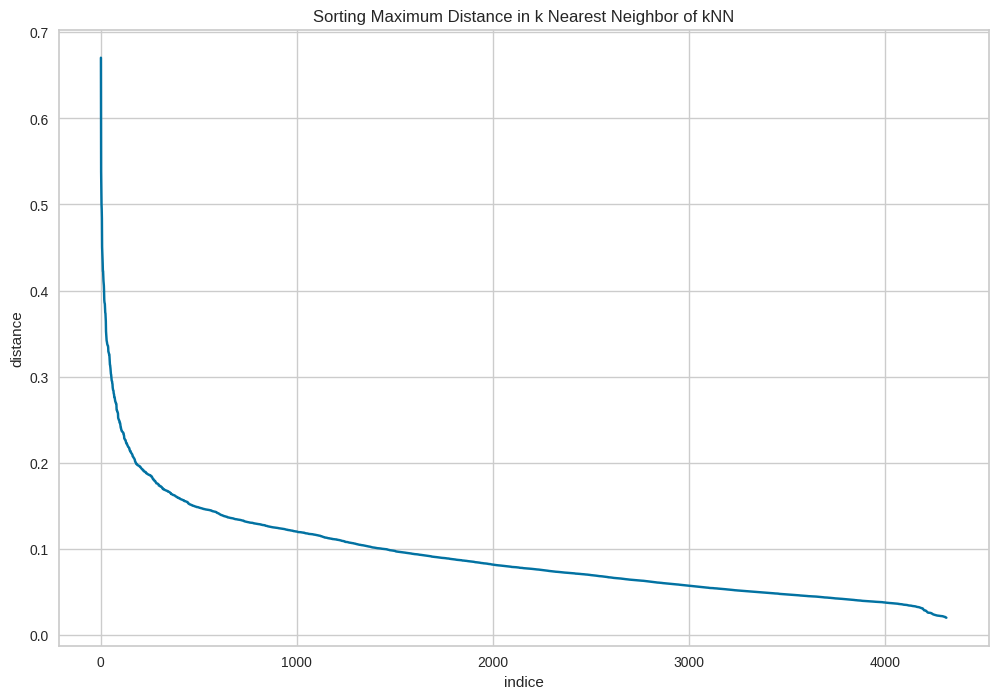

In [ ]:
from sklearn.neighbors import NearestNeighbors
#neighbors = 30
neighbors = 60
#neighbors = 4

nbrs = NearestNeighbors(n_neighbors=neighbors ).fit(rfm_t[['Recency','Frequency','Monetary']])

# Ma trận khoảng cách distances: (N, k)
distances, indices = nbrs.kneighbors(rfm_t[['Recency','Frequency','Monetary']])

distance_desc = sorted(distances[:, neighbors-1], reverse=True)
# Vẽ biểu đồ khoảng cách xa nhất ở trên theo thứ tự giảm dần
plt.figure(figsize=(12, 8))
plt.plot(list(range(1,len(distance_desc )+1)), distance_desc)

plt.ylabel('distance')
plt.xlabel('indice')
plt.title('Sorting Maximum Distance in k Nearest Neighbor of kNN')

In [ ]:
from itertools import product

#eps_values = np.arange(0.1,0.25,0.01) # giá trị eps cụm 1
#min_samples = np.arange(30,70) # min_samples cum 1

eps_values = np.arange(0.15,0.3,0.01) # giá trị eps cụm 2
min_samples = np.arange(60,70) #min_samples cum 2

#eps_values = np.arange(0.025,0.1,0.005) # giá trị eps cụm 3
#min_samples = np.arange(4,10) # giá trị eps cụm 3

DBSCAN_params = list(product(eps_values, min_samples))

In [ ]:
#ứng với từng cặp eps và minsample chạy dbscan để tìm ra silscore
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
no_of_clusters = []
sil_score = []


for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(rfm_t[['Recency','Frequency',	'Monetary']])
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    score = silhouette_score(rfm_t[['Recency','Frequency','Monetary']], DBS_clustering.labels_)
    sil_score.append(score)

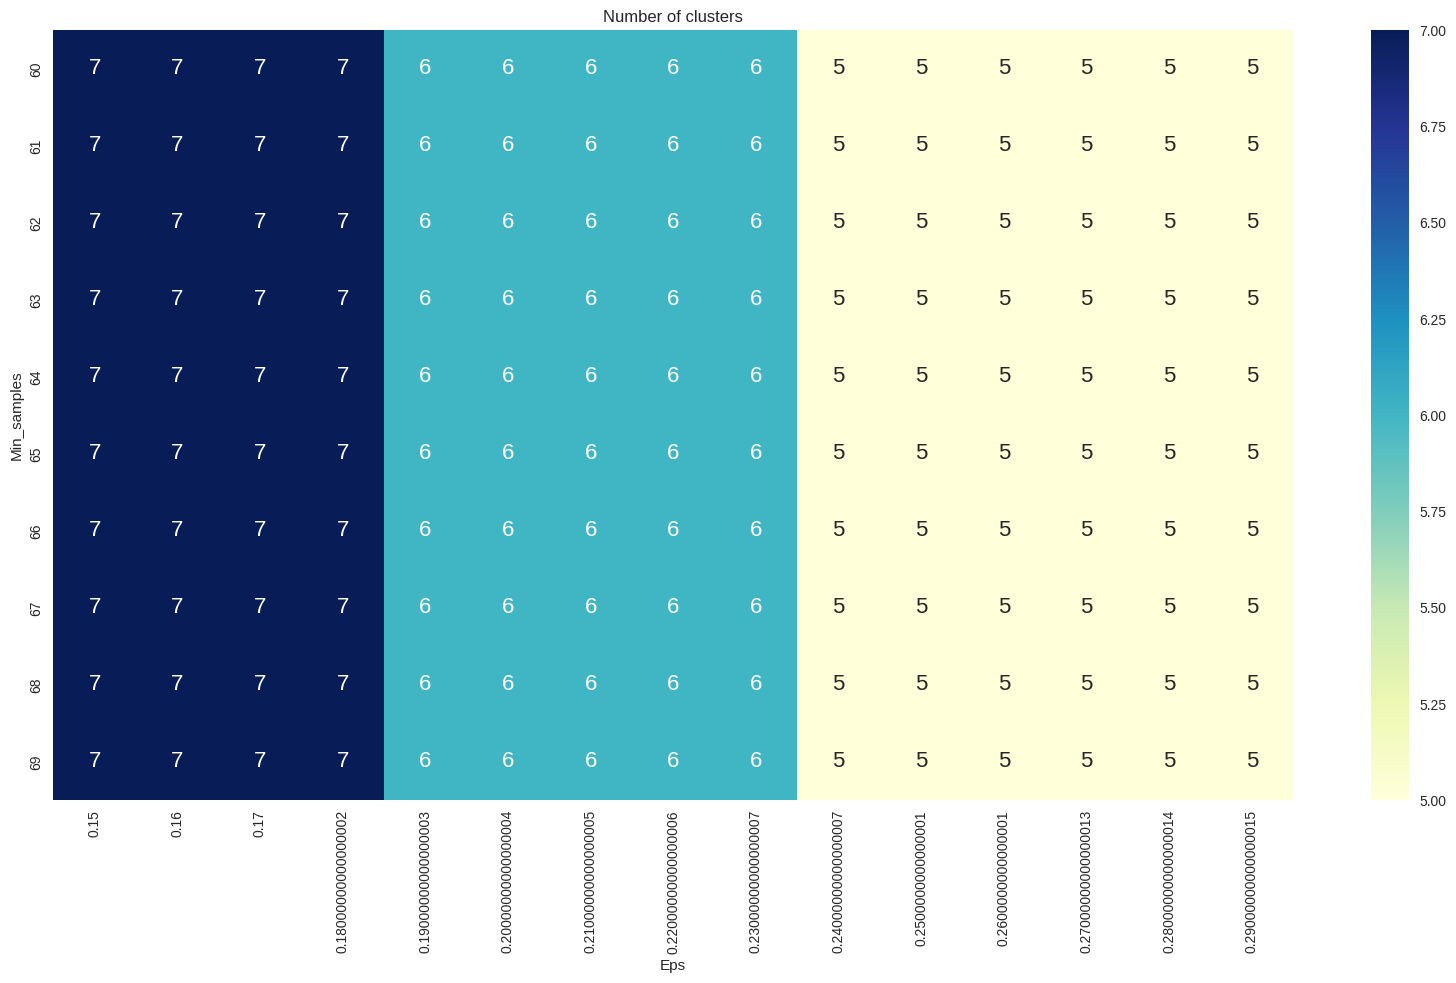

In [ ]:
#ứng với từng cặp có bao nhiêu cluster
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

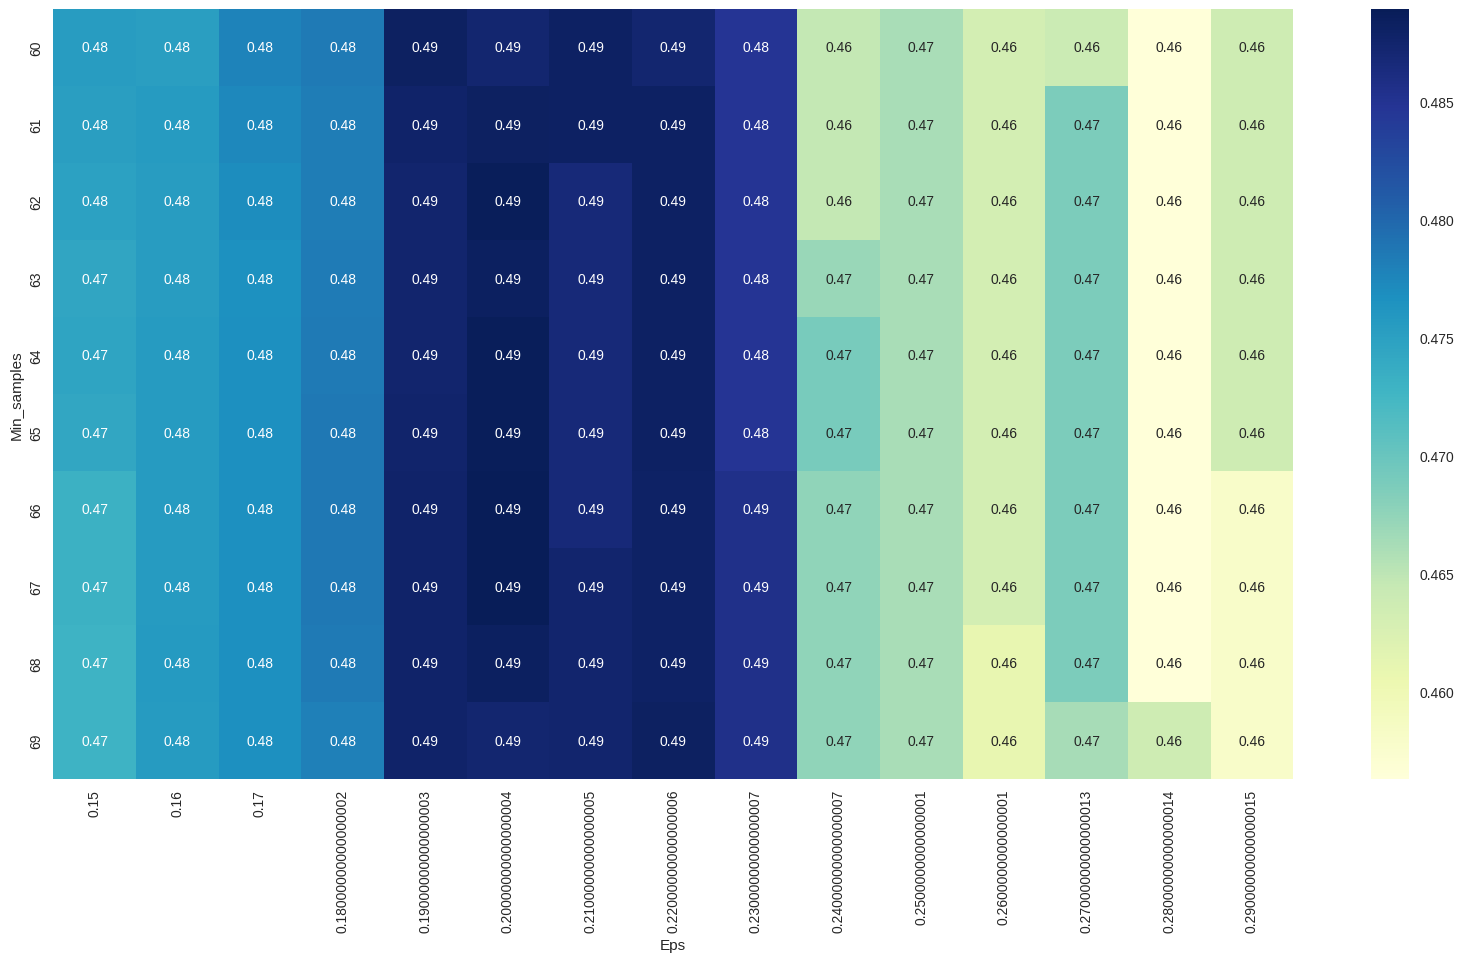

In [ ]:
# tính điểm silloutte với từng cặp tham số truyền vào model
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN

#model1 = DBSCAN(eps =0.2, min_samples =31, metric='euclidean')

model1 = DBSCAN(eps =0.2, min_samples =62, metric='euclidean')
#model1 = DBSCAN(eps =0.09, min_samples =7, metric='euclidean')
model1=model1.fit(rfm_t[['Recency','Frequency',	'Monetary']])
y_db=model1.labels_
print('The Number of Clusters Obtained will be :')
RFM_DB = rfm_t.copy()
RFM_DB["DBLabels"] = y_db
RFM_DB["DBLabels"].value_counts(0)
#calculating Silhoutte Score:

The Number of Clusters Obtained will be :


 2    1498
 0    1058
 4     835
 3     503
 1     381
-1      40
Name: DBLabels, dtype: int64

In [ ]:
#tính số cluster và các điểm nhiểu, ở dưới xác định dc là có 3 cluster tìm dc sau khi chạy vs DBSCAN, còn điểm nhiễu là khi nó ko đáp ứng được các yêu cầu của DBSCAN ( ko đủ số minPTs trong khoảng 
# eps truyền vào cho model)
n_clusters_ = len(set(y_db)) - (1 if -1 in y_db else 0)
n_noise_ = list(y_db).count(-1)
print('Number of Clusters : ', n_clusters_)
print('Number of Outliers : ', n_noise_)

Number of Clusters :  5
Number of Outliers :  40


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
# Tính điểm silhouette score cho từng điểm dữ liệu
silhouette_vals = silhouette_samples(rfm_t[['Recency','Frequency','Monetary']], y_db)

# Tính tổng trung bình của silhouette score
silhouette_avg = silhouette_score(rfm_t[['Recency','Frequency',	'Monetary']],y_db)

# In silhouette score trung bình của mô hình
print("DBSCAN silhouette score:", silhouette_avg)

DBSCAN silhouette score: 0.4887352868695143


In [ ]:
from sklearn import metrics
from sklearn.datasets import make_blobs

# Tính CH index
ch_score = metrics.calinski_harabasz_score(rfm_t[['Recency','Frequency',	'Monetary']], y_db)

# Tính DB index
db_score = metrics.davies_bouldin_score(rfm_t[['Recency','Frequency',	'Monetary']], y_db)

# In kết quả
print("CH index score:", ch_score)
print("DB index score:", db_score)

CH index score: 10403.226074976523
DB index score: 1.0302129437921181


- CH index:
- DB index:

In [ ]:
import plotly.graph_objects as go
trace = go.Scatter3d(
                    x = RFM_DB['Recency'],
                    y = RFM_DB['Frequency'],
                    z = RFM_DB['Monetary'],
                    mode='markers', 
                    marker=dict(color=RFM_DB['DBLabels'],
        opacity=0.8 ))
data = [trace]
layout = go.Layout(
                    title='Clusters',
                    scene= dict(
                                xaxis = dict(title = 'Recency'),
                                yaxis = dict(title = 'Frequency'),
                                zaxis = dict(title = 'Monetary'))
                                )


fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)
plt.show()

In [ ]:
RFM_DB2 = RFM_DB.copy()
indexNames = RFM_DB2[ RFM_DB2['DBLabels'] == -1 ].index
#Xóa những dòng cho DBLabels bằng -1
RFM_DB2.drop(indexNames , inplace=True)

RFM_DB2['DBLabels'].unique()

array([0, 1, 2, 3, 4])

In [ ]:
trace = go.Scatter3d(
                    x = RFM_DB2['Recency'],
                    y = RFM_DB2['Frequency'],
                    z = RFM_DB2['Monetary'],
                    mode='markers', 
                    marker=dict(color=RFM_DB2['DBLabels'],size =3,
                                
        opacity=0.8 ),text=RFM_DB2['DBLabels'])
data = [trace]
layout = go.Layout(
                    title='Clusters',
                    scene= dict(
                                xaxis = dict(title = 'Recency'),
                                yaxis = dict(title = 'Frequency'),
                                zaxis = dict(title = 'Monetary'))
                                )


fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)
plt.show()

<Axes: xlabel='Frequency', ylabel='Monetary'>

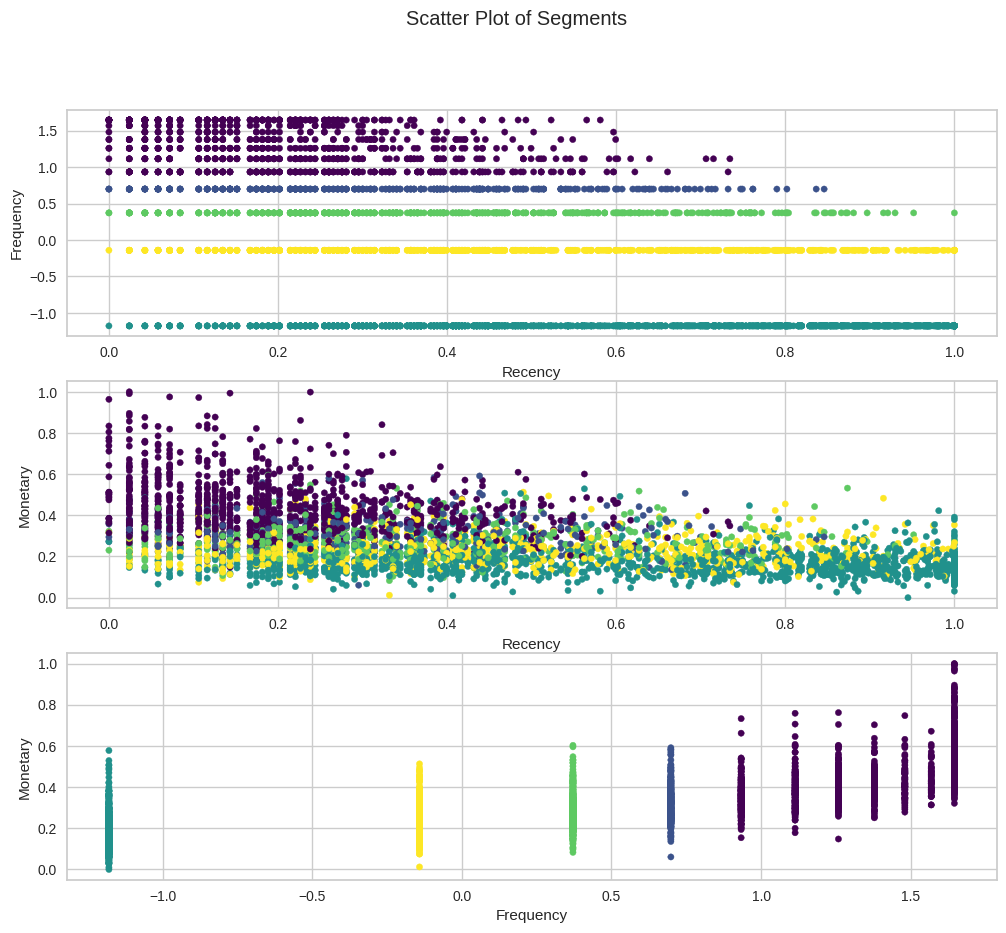

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3);
fig.suptitle('Scatter Plot of Segments');

RFM_DB2.plot.scatter(x = 'Recency', y = 'Frequency', c=RFM_DB2['DBLabels'], colormap='viridis', ax=ax1, colorbar=False,figsize = (12,10))
RFM_DB2.plot.scatter(x = 'Recency', y = 'Monetary',  c=RFM_DB2['DBLabels'], colormap='viridis', ax=ax2, colorbar=False)
RFM_DB2.plot.scatter(x = 'Frequency', y = 'Monetary', c=RFM_DB2['DBLabels'], colormap='viridis', ax=ax3, colorbar=False)

In [ ]:
# dữ liệu sau khi dc gắn labels vào các cụm(ko có nhiễu -1)
RFM_DB2

Recency  Monetary  Frequency  CustomerID         Country  Tenure  \
0     0.042543  0.505367   1.258430     12347.0         Iceland     368   
1     0.448523  0.364068   0.698522     12348.0         Finland     359   
2     0.195204  0.360973  -1.179308     12349.0           Italy      19   
3     0.966761  0.184956  -1.179308     12350.0          Norway     311   
4     0.295387  0.412984   1.378493     12352.0          Norway     297   
...        ...       ...        ...         ...             ...     ...   
4310  0.910862  0.140719  -1.179308     18280.0  United Kingdom     278   
4311  0.723747  0.095095  -1.179308     18281.0  United Kingdom     181   
4312  0.106260  0.139802  -0.141519     18282.0  United Kingdom     127   
4313  0.058115  0.385944   1.645843     18283.0  United Kingdom     338   
4314  0.322973  0.367145   0.371282     18287.0  United Kingdom     202   

      Avg_Monetary  DBLabels  
0        23.681319         0  
1        57.975484         1  
2        24.076027         2  
3        19.670588         2  
4        29.482824         0  
...            ...       ...  
4310     18.060000         2  
4311     11.545714         2  
4312     14.837500         4  
4313      2.771005         0  
4314     26.246857         3  

[4275 rows x 8 columns]

In [ ]:
# dữ liệu sau khi dc gắn labels vào các cụm(có nhiễu -1)
RFM_DB

Recency  Monetary  Frequency  CustomerID         Country  Tenure  \
0     0.042543  0.505367   1.258430     12347.0         Iceland     368   
1     0.448523  0.364068   0.698522     12348.0         Finland     359   
2     0.195204  0.360973  -1.179308     12349.0           Italy      19   
3     0.966761  0.184956  -1.179308     12350.0          Norway     311   
4     0.295387  0.412984   1.378493     12352.0          Norway     297   
...        ...       ...        ...         ...             ...     ...   
4310  0.910862  0.140719  -1.179308     18280.0  United Kingdom     278   
4311  0.723747  0.095095  -1.179308     18281.0  United Kingdom     181   
4312  0.106260  0.139802  -0.141519     18282.0  United Kingdom     127   
4313  0.058115  0.385944   1.645843     18283.0  United Kingdom     338   
4314  0.322973  0.367145   0.371282     18287.0  United Kingdom     202   

      Avg_Monetary  DBLabels  
0        23.681319         0  
1        57.975484         1  
2        24.076027         2  
3        19.670588         2  
4        29.482824         0  
...            ...       ...  
4310     18.060000         2  
4311     11.545714         2  
4312     14.837500         4  
4313      2.771005         0  
4314     26.246857         3  

[4315 rows x 8 columns]

In [ ]:
RFM_DB = pd.merge(rfm, RFM_DB[['CustomerID', 'DBLabels']], on='CustomerID', how='outer')
RFM_DB

CustomerID         Country  Recency  Frequency  Monetary  Avg_Monetary  \
0        12346.0  United Kingdom      326          1  77183.60  77183.600000   
1        12347.0         Iceland        3          7   4310.00     23.681319   
2        12348.0         Finland       76          4   1797.24     57.975484   
3        12349.0           Italy       19          1   1757.55     24.076027   
4        12350.0          Norway      311          1    334.40     19.670588   
...          ...             ...      ...        ...       ...           ...   
4357     18280.0  United Kingdom      278          1    180.60     18.060000   
4358     18281.0  United Kingdom      181          1     80.82     11.545714   
4359     18282.0  United Kingdom        8          2    178.05     14.837500   
4360     18283.0  United Kingdom        4         16   2094.88      2.771005   
4361     18287.0  United Kingdom       43          3   1837.28     26.246857   

      Tenure  DBLabels  
0        326       NaN  
1        368       0.0  
2        359       1.0  
3         19       2.0  
4        311       2.0  
...      ...       ...  
4357     278       2.0  
4358     181       2.0  
4359     127       4.0  
4360     338       0.0  
4361     202       3.0  

[4362 rows x 8 columns]

In [ ]:
pivot_table = pd.pivot_table(
    RFM_DB,
    values=['Monetary', 'Recency', 'Frequency', 'CustomerID'],
    index=['DBLabels'],
    aggfunc={'Monetary': 'mean', 'Recency': 'mean', 'Frequency': 'mean', 'CustomerID': 'count'}
)

# Đổi tên các cột theo ý muốn
pivot_table.columns = ['Count', 'Mean_Frequency', 'Mean_Monetary', 'Mean_Recency']

print(pivot_table)

          Count  Mean_Frequency  Mean_Monetary  Mean_Recency
DBLabels                                                    
-1.0         40        6.625000    4573.986500    207.050000
 0.0       1061        9.879359    3789.419755     25.873704
 1.0        382        3.994764    1425.312594     50.921466
 2.0       1504        1.007979     367.966650    156.994016
 3.0        505        2.992079    1061.605170     70.669307
 4.0        839        2.017878     672.938857     94.672229


In [ ]:
RFM_DB

CustomerID         Country  Recency  Frequency  Monetary  Avg_Monetary  \
0        12346.0  United Kingdom      326          1  77183.60  77183.600000   
1        12347.0         Iceland        3          7   4310.00     23.681319   
2        12348.0         Finland       76          4   1797.24     57.975484   
3        12349.0           Italy       19          1   1757.55     24.076027   
4        12350.0          Norway      311          1    334.40     19.670588   
...          ...             ...      ...        ...       ...           ...   
4357     18280.0  United Kingdom      278          1    180.60     18.060000   
4358     18281.0  United Kingdom      181          1     80.82     11.545714   
4359     18282.0  United Kingdom        8          2    178.05     14.837500   
4360     18283.0  United Kingdom        4         16   2094.88      2.771005   
4361     18287.0  United Kingdom       43          3   1837.28     26.246857   

      Tenure  DBLabels  
0        326       NaN  
1        368       0.0  
2        359       1.0  
3         19       2.0  
4        311       2.0  
...      ...       ...  
4357     278       2.0  
4358     181       2.0  
4359     127       4.0  
4360     338       0.0  
4361     202       3.0  

[4362 rows x 8 columns]

In [ ]:

trace = go.Scatter3d(
                    x = RFM_DB['Recency'],
                    y = RFM_DB['Frequency'],
                    z = RFM_DB['Monetary'],
                    mode='markers', 
                    marker=dict(color=RFM_DB['DBLabels'],size=10,
                                
        opacity=0.8 ),text=RFM_DB['DBLabels'])
data = [trace]
layout = go.Layout(
                    title='Clusters',
                    scene= dict(
                                xaxis = dict(title = 'Recency'),
                                yaxis = dict(title = 'Frequency'),
                                zaxis = dict(title = 'Monetary'))
                                )


fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)
plt.show()

In [ ]:
RFM_DB_f= RFM_DB[RFM_DB['DBLabels'] != -1] # Lọc bỏ các điểm có DBlabel = -1
# Phân dữ liệu RFM_DB_f thành 5 nhóm dựa trên cột 'DBLabels'
n_clusters = 5
colors=['blue', 'green', 'red', 'purple', 'orange']


traces = []
for label in range(5):
    trace = go.Scatter3d(
        x=RFM_DB_f[RFM_DB_f['DBLabels'] == label]['Recency'],
        y=RFM_DB_f[RFM_DB_f['DBLabels'] == label]['Frequency'],
        z=RFM_DB_f[RFM_DB_f['DBLabels'] == label]['Monetary'],
        mode='markers',
        marker=dict(color=colors[label], size=5, opacity=0.8),
        name=f'Cluster {label}',
        visible=True
    )
    traces.append(trace)



layout = go.Layout(
    title='RFM Clustering',
    scene=dict(xaxis=dict(title='Recency'),
               yaxis=dict(title='Frequency'),
               zaxis=dict(title='Monetary'))
)
fig = go.Figure(data=traces, layout=layout)
py.offline.iplot(fig)

# DBSCAN + KMEANS

In [ ]:
df1_clustered1=km_clustered[km_clustered['Cluster']==1]
df1_clustered1

Recency  Monetary  Frequency  CustomerID         Country  Tenure  \
2     0.195204  0.360973  -1.179308     12349.0           Italy      19   
3     0.966761  0.184956  -1.179308     12350.0          Norway     311   
5     0.773971  0.099943  -1.179308     12353.0         Bahrain     205   
6     0.828978  0.298831  -1.179308     12354.0           Spain     233   
7     0.794024  0.211565  -1.179308     12355.0         Bahrain     215   
...        ...       ...        ...         ...             ...     ...   
4307  0.327379  0.185302  -1.179308     18276.0  United Kingdom      44   
4308  0.388277  0.111347  -1.179308     18277.0  United Kingdom      59   
4309  0.441812  0.138289  -1.179308     18278.0  United Kingdom      74   
4310  0.910862  0.140719  -1.179308     18280.0  United Kingdom     278   
4311  0.723747  0.095095  -1.179308     18281.0  United Kingdom     181   

      Avg_Monetary  Cluster  labels  
2        24.076027        1       1  
3        19.670588        1       1  
5        22.250000        1       1  
6        18.610345        1       1  
7        35.338462        1       1  
...            ...      ...     ...  
4307     23.990000        1       1  
4308     13.797500        1       1  
4309     19.322222        1       1  
4310     18.060000        1       1  
4311     11.545714        1       1  

[1498 rows x 9 columns]

In [ ]:
from sklearn.cluster import DBSCAN

model1 = DBSCAN(eps =0.09, min_samples =7, metric='euclidean')
model1=model1.fit(df1_clustered1[['Recency','Frequency',	'Monetary']])
y_db=model1.labels_
print('The Number of Clusters Obtained will be :')
RFM_DB1 = df1_clustered1.copy()
RFM_DB1["DBLabels"] = y_db
RFM_DB1["DBLabels"].value_counts(0)
#calculating Silhoutte Score:

The Number of Clusters Obtained will be :


 0    1492
-1       6
Name: DBLabels, dtype: int64

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
# Tính điểm silhouette score cho từng điểm dữ liệu
silhouette_vals = silhouette_samples(df1_clustered1[['Recency','Frequency','Monetary']], y_db)

# Tính tổng trung bình của silhouette score
silhouette_avg = silhouette_score(df1_clustered1[['Recency','Frequency',	'Monetary']],y_db)

# In silhouette score trung bình của mô hình
print("DBSCAN silhouette score:", silhouette_avg)


DBSCAN silhouette score: 0.2859905966159576


In [ ]:
RFM_DB1[RFM_DB1['DBLabels']==-1]

Recency  Monetary  Frequency  CustomerID         Country  Tenure  \
9     0.280753  0.577619  -1.179308     12357.0     Switzerland      34   
27    0.604502  0.492028  -1.179308     12378.0     Switzerland     130   
284   0.562387  0.528738  -1.179308     12688.0          Israel     114   
334   0.468142  0.507810  -1.179308     12752.0          Norway      82   
2080  0.042543  0.485250  -1.179308     15195.0  United Kingdom       3   
4291  0.487055  0.505571  -1.179308     18251.0  United Kingdom      88   

      Avg_Monetary  Cluster  labels  DBLabels  
9        47.386794        1       1        -1  
27       18.304201        1       1        -1  
284      28.501813        1       1        -1  
334      82.392075        1       1        -1  
2080   3861.000000        1       1        -1  
4291    269.670000        1       1        -1

In [ ]:
RFM_DB1['labels'] = labels

trace = go.Scatter3d(
                    x = RFM_DB1['Recency'],
                    y = RFM_DB1['Frequency'],
                    z = RFM_DB1['Monetary'],
                    mode = 'markers',
                    marker=dict(color=RFM_DB1['DBLabels'], size =8, line=dict(color=RFM_DB1['DBLabels'], width=15), opacity=0.8),text=RFM_DB1['DBLabels']
                    )

    
data = [trace]
layout = go.Layout(
                    title='DBLabels',
                    scene= dict(
                                xaxis = dict(title = 'Recency'),
                                yaxis = dict(title = 'Frequency'),
                                zaxis = dict(title = 'Monetary'))
                                )


fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)
plt.show()

In [ ]:
df1_clustered2=km_clustered[km_clustered['Cluster']==2]
df1_clustered2

Recency  Monetary  Frequency  CustomerID         Country  Tenure  \
8     0.220596  0.431205   0.371282     12356.0        Portugal     326   
10    0.024072  0.308220  -0.141519     12358.0         Austria     151   
12    0.364971  0.422467   0.371282     12360.0         Austria     201   
15    0.551404  0.228286  -0.141519     12363.0     Unspecified     243   
17    0.934961  0.242733  -0.141519     12365.0          Cyprus     292   
...        ...       ...        ...         ...             ...     ...   
4300  0.438423  0.265566  -0.141519     18265.0  United Kingdom     159   
4303  0.304815  0.172101  -0.141519     18270.0  United Kingdom     267   
4305  0.042543  0.148762   0.371282     18273.0  United Kingdom     258   
4312  0.106260  0.139802  -0.141519     18282.0  United Kingdom     127   
4314  0.322973  0.367145   0.371282     18287.0  United Kingdom     202   

      Avg_Monetary  Cluster  labels  
8        47.651356        2       2  
10       61.476842        2       2  
12       20.636124        2       2  
15       24.000000        2       2  
17       29.153636        2       2  
...            ...      ...     ...  
4300     17.424130        2       2  
4303     25.740909        2       2  
4305     68.000000        2       2  
4312     14.837500        2       2  
4314     26.246857        2       2  

[1349 rows x 9 columns]

In [ ]:

model1=model1.fit(df1_clustered2[['Recency','Frequency',	'Monetary']])
y_db=model1.labels_
print('The Number of Clusters Obtained will be :')
RFM_DB2 = df1_clustered2.copy()
RFM_DB2["DBLabels"] = y_db
RFM_DB2["DBLabels"].value_counts(0)
#calculating Silhoutte Score:

The Number of Clusters Obtained will be :


 1    831
 0    500
-1     18
Name: DBLabels, dtype: int64

In [ ]:
RFM_DB2

Recency  Monetary  Frequency  CustomerID         Country  Tenure  \
8     0.220596  0.431205   0.371282     12356.0        Portugal     326   
10    0.024072  0.308220  -0.141519     12358.0         Austria     151   
12    0.364971  0.422467   0.371282     12360.0         Austria     201   
15    0.551404  0.228286  -0.141519     12363.0     Unspecified     243   
17    0.934961  0.242733  -0.141519     12365.0          Cyprus     292   
...        ...       ...        ...         ...             ...     ...   
4300  0.438423  0.265566  -0.141519     18265.0  United Kingdom     159   
4303  0.304815  0.172101  -0.141519     18270.0  United Kingdom     267   
4305  0.042543  0.148762   0.371282     18273.0  United Kingdom     258   
4312  0.106260  0.139802  -0.141519     18282.0  United Kingdom     127   
4314  0.322973  0.367145   0.371282     18287.0  United Kingdom     202   

      Avg_Monetary  Cluster  labels  DBLabels  
8        47.651356        2       2         0  
10       61.476842        2       2         1  
12       20.636124        2       2         0  
15       24.000000        2       2         1  
17       29.153636        2       2         1  
...            ...      ...     ...       ...  
4300     17.424130        2       2         1  
4303     25.740909        2       2         1  
4305     68.000000        2       2         0  
4312     14.837500        2       2         1  
4314     26.246857        2       2         0  

[1349 rows x 10 columns]

In [ ]:
# Tính điểm silhouette score cho từng điểm dữ liệu
silhouette_vals = silhouette_samples(df1_clustered2[['Recency','Frequency','Monetary']], y_db)

# Tính tổng trung bình của silhouette score
silhouette_avg = silhouette_score(df1_clustered2[['Recency','Frequency',	'Monetary']],y_db)

# In silhouette score trung bình của mô hình
print("DBSCAN silhouette score:", silhouette_avg)


DBSCAN silhouette score: 0.49368718289494606


In [ ]:
RFM_DB2['labels'] = labels

trace = go.Scatter3d(
                    x = RFM_DB2['Recency'],
                    y = RFM_DB2['Frequency'],
                    z = RFM_DB2['Monetary'],
                    mode = 'markers',
                    marker=dict(color=RFM_DB2['DBLabels'], size =8, line=dict(color=RFM_DB2['DBLabels'], width=15), opacity=0.8),text=RFM_DB2['DBLabels']
                    )

    
data = [trace]
layout = go.Layout(
                    title='DBLabels',
                    scene= dict(
                                xaxis = dict(title = 'Recency'),
                                yaxis = dict(title = 'Frequency'),
                                zaxis = dict(title = 'Monetary'))
                                )


fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)
plt.show()

In [ ]:
df1_clustered0=km_clustered[km_clustered['Cluster']==0]
df1_clustered0

Recency  Monetary  Frequency  CustomerID         Country  Tenure  \
0     0.042543  0.505367   1.258430     12347.0         Iceland     368   
1     0.448523  0.364068   0.698522     12348.0         Finland     359   
4     0.295387  0.412984   1.378493     12352.0          Norway     297   
11    0.384478  0.583157   0.698522     12359.0          Cyprus     332   
14    0.058115  0.542442   1.568533     12362.0         Belgium     296   
...        ...       ...        ...         ...             ...     ...   
4286  0.106260  0.416739   1.258430     18245.0  United Kingdom     356   
4294  0.309439  0.402295   1.378493     18257.0  United Kingdom     297   
4296  0.706273  0.421341   1.113609     18260.0  United Kingdom     359   
4304  0.042543  0.446091   1.113609     18272.0  United Kingdom     247   
4313  0.058115  0.385944   1.645843     18283.0  United Kingdom     338   

      Avg_Monetary  Cluster  labels  
0        23.681319        0       0  
1        57.975484        0       0  
4        29.482824        0       0  
11       25.695887        0       0  
14       19.647481        0       0  
...            ...      ...     ...  
4286     14.668914        0       0  
4294     19.810424        0       0  
4296     19.725373        0       0  
4304     18.545663        0       0  
4313      2.771005        0       0  

[1468 rows x 9 columns]

In [ ]:

model1=model1.fit(df1_clustered0[['Recency','Frequency',	'Monetary']])
y_db=model1.labels_
print('The Number of Clusters Obtained will be :')
RFM_DB0 = df1_clustered0.copy()
RFM_DB0["DBLabels"] = y_db
RFM_DB0["DBLabels"].value_counts(0)
#calculating Silhoutte Score:

The Number of Clusters Obtained will be :


 3    405
 1    378
 4    231
 5    158
 0    133
 2     90
-1     73
Name: DBLabels, dtype: int64

In [ ]:
RFM_DB0

Recency  Monetary  Frequency  CustomerID         Country  Tenure  \
0     0.042543  0.505367   1.258430     12347.0         Iceland     368   
1     0.448523  0.364068   0.698522     12348.0         Finland     359   
4     0.295387  0.412984   1.378493     12352.0          Norway     297   
11    0.384478  0.583157   0.698522     12359.0          Cyprus     332   
14    0.058115  0.542442   1.568533     12362.0         Belgium     296   
...        ...       ...        ...         ...             ...     ...   
4286  0.106260  0.416739   1.258430     18245.0  United Kingdom     356   
4294  0.309439  0.402295   1.378493     18257.0  United Kingdom     297   
4296  0.706273  0.421341   1.113609     18260.0  United Kingdom     359   
4304  0.042543  0.446091   1.113609     18272.0  United Kingdom     247   
4313  0.058115  0.385944   1.645843     18283.0  United Kingdom     338   

      Avg_Monetary  Cluster  labels  DBLabels  
0        23.681319        0       0         0  
1        57.975484        0       0         1  
4        29.482824        0       0         2  
11       25.695887        0       0        -1  
14       19.647481        0       0         3  
...            ...      ...     ...       ...  
4286     14.668914        0       0         0  
4294     19.810424        0       0         2  
4296     19.725373        0       0        -1  
4304     18.545663        0       0         5  
4313      2.771005        0       0         3  

[1468 rows x 10 columns]

In [ ]:
RFM_DB0['labels'] = labels

trace = go.Scatter3d(
                    x = RFM_DB0['Recency'],
                    y = RFM_DB0['Frequency'],
                    z = RFM_DB0['Monetary'],
                    mode = 'markers',
                    marker=dict(color=RFM_DB0['DBLabels'], size =8, line=dict(color=RFM_DB0['DBLabels'], width=15), opacity=0.8),text=RFM_DB0['DBLabels']
                    )

    
data = [trace]
layout = go.Layout(
                    title='DBLabels',
                    scene= dict(
                                xaxis = dict(title = 'Recency'),
                                yaxis = dict(title = 'Frequency'),
                                zaxis = dict(title = 'Monetary'))
                                )


fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)
plt.show()

In [ ]:
RFM_DB = pd.merge(km_clustered, RFM_DB1, on=['CustomerID','Recency','Frequency','Monetary','Cluster','labels','Country','Tenure','Avg_Monetary'], how='outer')
RFM_DB

Recency  Monetary  Frequency  CustomerID         Country  Tenure  \
0     0.042543  0.505367   1.258430     12347.0         Iceland     368   
1     0.448523  0.364068   0.698522     12348.0         Finland     359   
2     0.195204  0.360973  -1.179308     12349.0           Italy      19   
3     0.966761  0.184956  -1.179308     12350.0          Norway     311   
4     0.295387  0.412984   1.378493     12352.0          Norway     297   
...        ...       ...        ...         ...             ...     ...   
4310  0.910862  0.140719  -1.179308     18280.0  United Kingdom     278   
4311  0.723747  0.095095  -1.179308     18281.0  United Kingdom     181   
4312  0.106260  0.139802  -0.141519     18282.0  United Kingdom     127   
4313  0.058115  0.385944   1.645843     18283.0  United Kingdom     338   
4314  0.322973  0.367145   0.371282     18287.0  United Kingdom     202   

      Avg_Monetary  Cluster  labels  DBLabels  
0        23.681319        0       0       NaN  
1        57.975484        0       0       NaN  
2        24.076027        1       1       0.0  
3        19.670588        1       1       0.0  
4        29.482824        0       0       NaN  
...            ...      ...     ...       ...  
4310     18.060000        1       1       0.0  
4311     11.545714        1       1       0.0  
4312     14.837500        2       2       NaN  
4313      2.771005        0       0       NaN  
4314     26.246857        2       2       NaN  

[4315 rows x 10 columns]

In [ ]:
RFM_DB = pd.merge(RFM_DB, RFM_DB0, on=['CustomerID','Recency','Frequency','Monetary','Cluster','labels','Country','Tenure','Avg_Monetary'], how='outer')
RFM_DB

Recency  Monetary  Frequency  CustomerID         Country  Tenure  \
0     0.042543  0.505367   1.258430     12347.0         Iceland     368   
1     0.448523  0.364068   0.698522     12348.0         Finland     359   
2     0.195204  0.360973  -1.179308     12349.0           Italy      19   
3     0.966761  0.184956  -1.179308     12350.0          Norway     311   
4     0.295387  0.412984   1.378493     12352.0          Norway     297   
...        ...       ...        ...         ...             ...     ...   
4310  0.910862  0.140719  -1.179308     18280.0  United Kingdom     278   
4311  0.723747  0.095095  -1.179308     18281.0  United Kingdom     181   
4312  0.106260  0.139802  -0.141519     18282.0  United Kingdom     127   
4313  0.058115  0.385944   1.645843     18283.0  United Kingdom     338   
4314  0.322973  0.367145   0.371282     18287.0  United Kingdom     202   

      Avg_Monetary  Cluster  labels  DBLabels_x  DBLabels_y  
0        23.681319        0       0         NaN         0.0  
1        57.975484        0       0         NaN         1.0  
2        24.076027        1       1         0.0         NaN  
3        19.670588        1       1         0.0         NaN  
4        29.482824        0       0         NaN         2.0  
...            ...      ...     ...         ...         ...  
4310     18.060000        1       1         0.0         NaN  
4311     11.545714        1       1         0.0         NaN  
4312     14.837500        2       2         NaN         NaN  
4313      2.771005        0       0         NaN         3.0  
4314     26.246857        2       2         NaN         NaN  

[4315 rows x 11 columns]

In [ ]:
RFM_DB = pd.merge(RFM_DB, RFM_DB2, on=['CustomerID','Recency','Frequency','Monetary','Cluster','labels','Country','Tenure','Avg_Monetary'], how='outer')
RFM_DB

Recency  Monetary  Frequency  CustomerID         Country  Tenure  \
0     0.042543  0.505367   1.258430     12347.0         Iceland     368   
1     0.448523  0.364068   0.698522     12348.0         Finland     359   
2     0.195204  0.360973  -1.179308     12349.0           Italy      19   
3     0.966761  0.184956  -1.179308     12350.0          Norway     311   
4     0.295387  0.412984   1.378493     12352.0          Norway     297   
...        ...       ...        ...         ...             ...     ...   
4310  0.910862  0.140719  -1.179308     18280.0  United Kingdom     278   
4311  0.723747  0.095095  -1.179308     18281.0  United Kingdom     181   
4312  0.106260  0.139802  -0.141519     18282.0  United Kingdom     127   
4313  0.058115  0.385944   1.645843     18283.0  United Kingdom     338   
4314  0.322973  0.367145   0.371282     18287.0  United Kingdom     202   

      Avg_Monetary  Cluster  labels  DBLabels_x  DBLabels_y  DBLabels  
0        23.681319        0       0         NaN         0.0       NaN  
1        57.975484        0       0         NaN         1.0       NaN  
2        24.076027        1       1         0.0         NaN       NaN  
3        19.670588        1       1         0.0         NaN       NaN  
4        29.482824        0       0         NaN         2.0       NaN  
...            ...      ...     ...         ...         ...       ...  
4310     18.060000        1       1         0.0         NaN       NaN  
4311     11.545714        1       1         0.0         NaN       NaN  
4312     14.837500        2       2         NaN         NaN       1.0  
4313      2.771005        0       0         NaN         3.0       NaN  
4314     26.246857        2       2         NaN         NaN       0.0  

[4315 rows x 12 columns]

In [ ]:
RFM_DB['DBLabels'].fillna(RFM_DB['DBLabels_x'], inplace=True)
RFM_DB['DBLabels'].fillna(RFM_DB['DBLabels_y'], inplace=True)
RFM_DB.drop(['DBLabels_y'], axis=1, inplace=True)
RFM_DB.drop(['DBLabels_x'], axis=1, inplace=True)


In [ ]:
result_table = RFM_DB[['CustomerID',	'Recency',	'Frequency','Monetary','Cluster' ,'DBLabels']]
result_table

CustomerID   Recency  Frequency  Monetary  Cluster  DBLabels
0        12347.0  0.042543   1.258430  0.505367        0       0.0
1        12348.0  0.448523   0.698522  0.364068        0       1.0
2        12349.0  0.195204  -1.179308  0.360973        1       0.0
3        12350.0  0.966761  -1.179308  0.184956        1       0.0
4        12352.0  0.295387   1.378493  0.412984        0       2.0
...          ...       ...        ...       ...      ...       ...
4310     18280.0  0.910862  -1.179308  0.140719        1       0.0
4311     18281.0  0.723747  -1.179308  0.095095        1       0.0
4312     18282.0  0.106260  -0.141519  0.139802        2       1.0
4313     18283.0  0.058115   1.645843  0.385944        0       3.0
4314     18287.0  0.322973   0.371282  0.367145        2       0.0

[4315 rows x 6 columns]

In [ ]:
RFM_DB_2=result_table[result_table['DBLabels']>-1].reset_index()
RFM_DB_2

index  CustomerID   Recency  Frequency  Monetary  Cluster  DBLabels
0         0     12347.0  0.042543   1.258430  0.505367        0       0.0
1         1     12348.0  0.448523   0.698522  0.364068        0       1.0
2         2     12349.0  0.195204  -1.179308  0.360973        1       0.0
3         3     12350.0  0.966761  -1.179308  0.184956        1       0.0
4         4     12352.0  0.295387   1.378493  0.412984        0       2.0
...     ...         ...       ...        ...       ...      ...       ...
4213   4310     18280.0  0.910862  -1.179308  0.140719        1       0.0
4214   4311     18281.0  0.723747  -1.179308  0.095095        1       0.0
4215   4312     18282.0  0.106260  -0.141519  0.139802        2       1.0
4216   4313     18283.0  0.058115   1.645843  0.385944        0       3.0
4217   4314     18287.0  0.322973   0.371282  0.367145        2       0.0

[4218 rows x 7 columns]

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

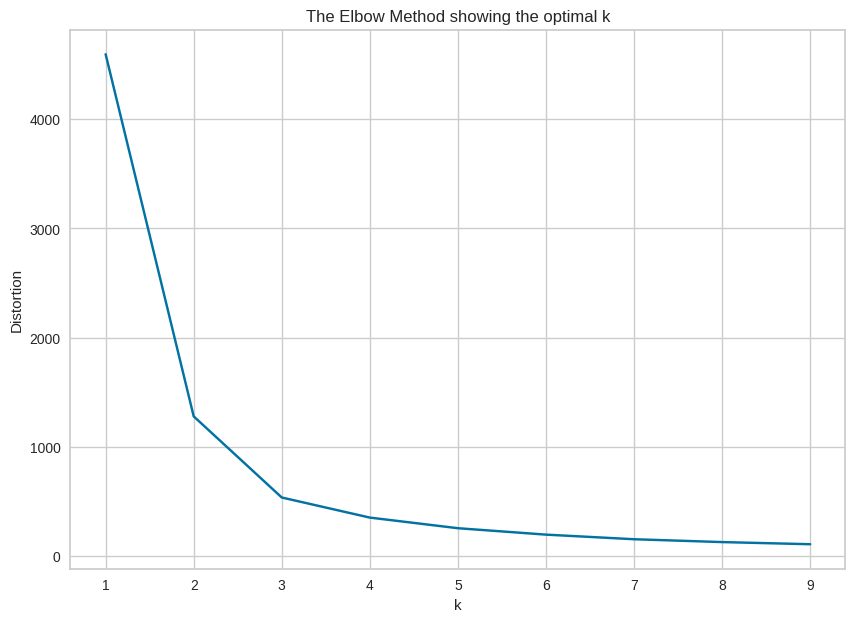

In [ ]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(RFM_DB_2[['Recency','Frequency','Monetary']])
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()    

In [ ]:
# Tính Silhouette_score khi k chạy từ 2-9
score = []
K = range(2,10)
for k in K:
    km = KMeans (n_clusters = k)
    km.fit(RFM_DB_2[['Recency','Frequency','Monetary']])
    score.append(silhouette_score (RFM_DB_2[['Recency','Frequency','Monetary']], km.labels_, metric = 'euclidean'))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

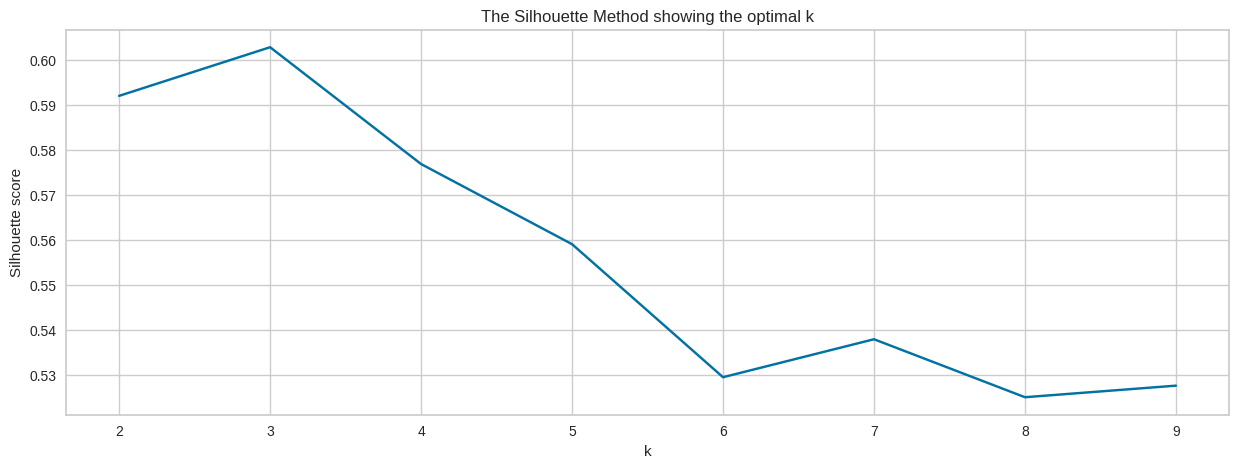

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('The Silhouette Method showing the optimal k')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3)
cluster_labels = kmeans.fit_predict(RFM_DB_2[['Recency','Frequency','Monetary']])
silhouette_avg = silhouette_score(RFM_DB_2[['Recency','Frequency','Monetary']], cluster_labels)
print("Điểm Silhouette với k=3 là:", silhouette_avg)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Điểm Silhouette với k=3 là: 0.6029225358101336


In [ ]:
from sklearn import metrics
from sklearn.datasets import make_blobs

# Tính CH index
ch_score = metrics.calinski_harabasz_score(RFM_DB_2[['Recency','Frequency',	'Monetary']], cluster_labels)

# Tính DB index
db_score = metrics.davies_bouldin_score(RFM_DB_2[['Recency','Frequency',	'Monetary']], cluster_labels)

# In kết quả
print("CH index score:", ch_score)
print("DB index score:", db_score)

CH index score: 15928.675631410404
DB index score: 0.5934396862400194


In [ ]:
km4a = KMeans(n_clusters=3,init='k-means++', max_iter=1000)
km4a= km4a.fit(RFM_DB_2[['Recency','Frequency','Monetary']])

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
RFM_DB_2

index  CustomerID   Recency  Frequency  Monetary  Cluster  DBLabels
0         0     12347.0  0.042543   1.258430  0.505367        0       0.0
1         1     12348.0  0.448523   0.698522  0.364068        0       1.0
2         2     12349.0  0.195204  -1.179308  0.360973        1       0.0
3         3     12350.0  0.966761  -1.179308  0.184956        1       0.0
4         4     12352.0  0.295387   1.378493  0.412984        0       2.0
...     ...         ...       ...        ...       ...      ...       ...
4213   4310     18280.0  0.910862  -1.179308  0.140719        1       0.0
4214   4311     18281.0  0.723747  -1.179308  0.095095        1       0.0
4215   4312     18282.0  0.106260  -0.141519  0.139802        2       1.0
4216   4313     18283.0  0.058115   1.645843  0.385944        0       3.0
4217   4314     18287.0  0.322973   0.371282  0.367145        2       0.0

[4218 rows x 7 columns]

In [ ]:
labels=km4a.labels_
labels=pd.DataFrame(labels, columns=['Cluster2'])
df4a_clustered=pd.concat([RFM_DB_2[['CustomerID','Recency','Frequency','Monetary']],labels] , axis=1)
df4a_clustered

CustomerID   Recency  Frequency  Monetary  Cluster2
0        12347.0  0.042543   1.258430  0.505367         1
1        12348.0  0.448523   0.698522  0.364068         1
2        12349.0  0.195204  -1.179308  0.360973         2
3        12350.0  0.966761  -1.179308  0.184956         2
4        12352.0  0.295387   1.378493  0.412984         1
...          ...       ...        ...       ...       ...
4213     18280.0  0.910862  -1.179308  0.140719         2
4214     18281.0  0.723747  -1.179308  0.095095         2
4215     18282.0  0.106260  -0.141519  0.139802         0
4216     18283.0  0.058115   1.645843  0.385944         1
4217     18287.0  0.322973   0.371282  0.367145         0

[4218 rows x 5 columns]

In [ ]:
trace = go.Scatter3d(
                    x = df4a_clustered['Recency'],
                    y = df4a_clustered['Frequency'],
                    z = df4a_clustered['Monetary'],
                    mode='markers', 
                    marker=dict(color=df4a_clustered['Cluster2'],size=3,
        opacity=0.8 ))
data = [trace]
layout = go.Layout(
                    title='Clusters',
                    scene= dict(
                                xaxis = dict(title = 'Recency'),
                                yaxis = dict(title = 'Frequency'),
                                zaxis = dict(title = 'Monetary'))
                                )


fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)
plt.show()

<Axes: xlabel='Frequency', ylabel='Monetary'>

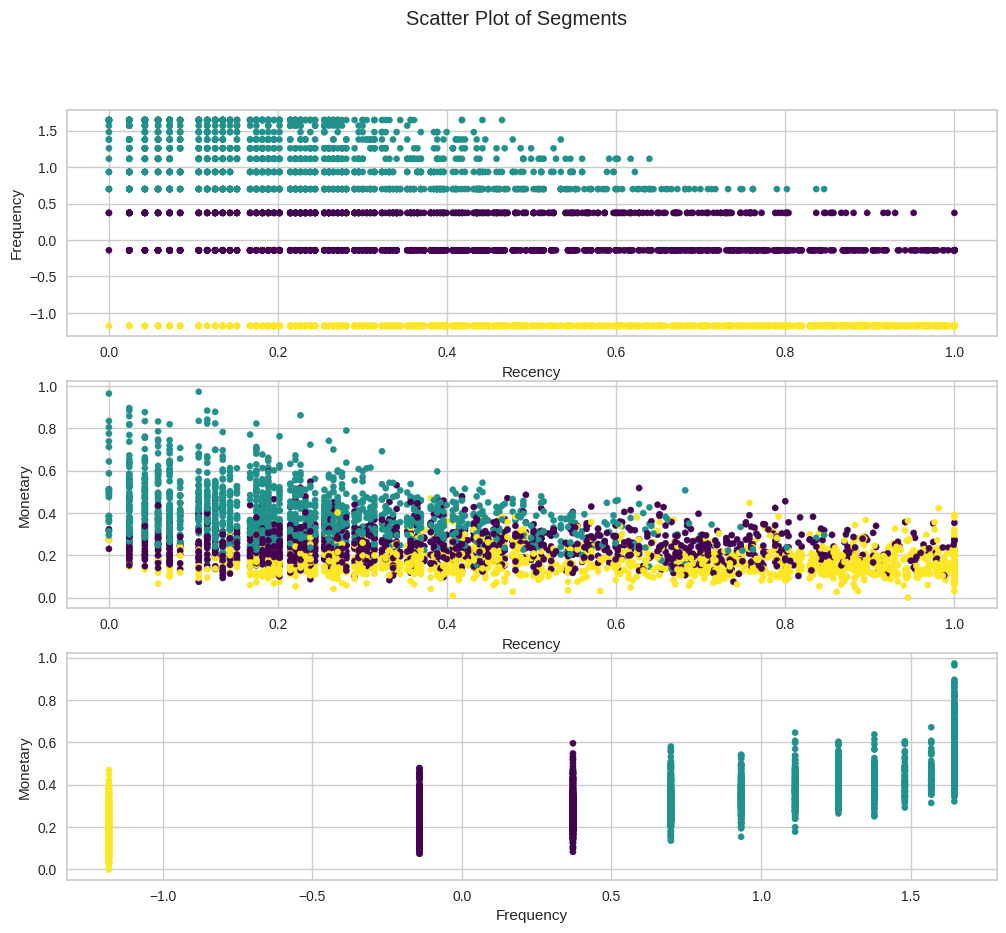

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3);
fig.suptitle('Scatter Plot of Segments');

df4a_clustered.plot.scatter(x = 'Recency', y = 'Frequency', c=df4a_clustered['Cluster2'], colormap='viridis', ax=ax1, colorbar=False,figsize = (12,10))
df4a_clustered.plot.scatter(x = 'Recency', y = 'Monetary',  c=df4a_clustered['Cluster2'], colormap='viridis', ax=ax2, colorbar=False)
df4a_clustered.plot.scatter(x = 'Frequency', y = 'Monetary', c=df4a_clustered['Cluster2'], colormap='viridis', ax=ax3, colorbar=False)

In [ ]:
RFM_DB_3 = pd.merge(rfm, df4a_clustered[['CustomerID', 'Cluster2']], left_on='CustomerID', right_on='CustomerID')
RFM_DB_3

CustomerID         Country  Recency  Frequency  Monetary  Avg_Monetary  \
0        12347.0         Iceland        3          7   4310.00     23.681319   
1        12348.0         Finland       76          4   1797.24     57.975484   
2        12349.0           Italy       19          1   1757.55     24.076027   
3        12350.0          Norway      311          1    334.40     19.670588   
4        12352.0          Norway       37          8   2506.04     29.482824   
...          ...             ...      ...        ...       ...           ...   
4229     18280.0  United Kingdom      278          1    180.60     18.060000   
4230     18281.0  United Kingdom      181          1     80.82     11.545714   
4231     18282.0  United Kingdom        8          2    178.05     14.837500   
4232     18283.0  United Kingdom        4         16   2094.88      2.771005   
4233     18287.0  United Kingdom       43          3   1837.28     26.246857   

      Tenure  Cluster2  
0        368         1  
1        359         1  
2         19         2  
3        311         2  
4        297         1  
...      ...       ...  
4229     278         2  
4230     181         2  
4231     127         0  
4232     338         1  
4233     202         0  

[4234 rows x 8 columns]

In [ ]:
pivot_table = pd.pivot_table(
    RFM_DB_3,
    values=['Monetary', 'Recency', 'Frequency', 'CustomerID'],
    index=['Cluster2'],
    aggfunc={'Monetary': 'mean', 'Recency': 'mean', 'Frequency': 'mean', 'CustomerID': 'count'}
)

# Đổi tên các cột theo ý muốn
pivot_table.columns = ['Count', 'Mean_Frequency', 'Mean_Monetary', 'Mean_Recency']

print(pivot_table)

          Count  Mean_Frequency  Mean_Monetary  Mean_Recency
Cluster2                                                    
0          1337        2.383695     802.844811     85.340314
1          1399        8.257327    3006.163196     31.359543
2          1498        1.008011     350.994153    157.321762


In [ ]:

trace = go.Scatter3d(
                    x = RFM_DB_3['Recency'],
                    y = RFM_DB_3['Frequency'],
                    z = RFM_DB_3['Monetary'],
                    mode='markers', 
                    marker=dict(color=RFM_DB_3['Cluster2'],size=10,
                                
        opacity=0.8 ),text=RFM_DB_3['Cluster2'])
data = [trace]
layout = go.Layout(
                    title='Clusters',
                    scene= dict(
                                xaxis = dict(title = 'Recency'),
                                yaxis = dict(title = 'Frequency'),
                                zaxis = dict(title = 'Monetary'))
                                )


fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)
plt.show()

In [ ]:
RFM_DB_3

CustomerID         Country  Recency  Frequency  Monetary  Avg_Monetary  \
0        12347.0         Iceland        3          7   4310.00     23.681319   
1        12348.0         Finland       76          4   1797.24     57.975484   
2        12349.0           Italy       19          1   1757.55     24.076027   
3        12350.0          Norway      311          1    334.40     19.670588   
4        12352.0          Norway       37          8   2506.04     29.482824   
...          ...             ...      ...        ...       ...           ...   
4229     18280.0  United Kingdom      278          1    180.60     18.060000   
4230     18281.0  United Kingdom      181          1     80.82     11.545714   
4231     18282.0  United Kingdom        8          2    178.05     14.837500   
4232     18283.0  United Kingdom        4         16   2094.88      2.771005   
4233     18287.0  United Kingdom       43          3   1837.28     26.246857   

      Tenure  Cluster2  
0        368         1  
1        359         1  
2         19         2  
3        311         2  
4        297         1  
...      ...       ...  
4229     278         2  
4230     181         2  
4231     127         0  
4232     338         1  
4233     202         0  

[4234 rows x 8 columns]

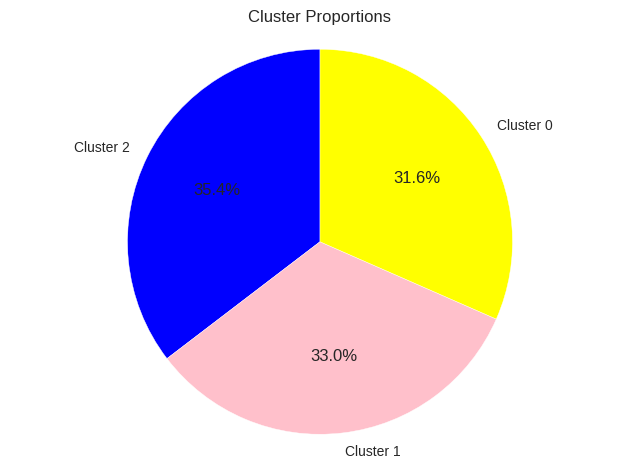

In [ ]:

colors = ['blue', 'pink', 'yellow']
cluster_proportions = RFM_DB_3['Cluster2'].value_counts(normalize=True)
# Vẽ biểu đồ tròn
labels = ['Cluster ' + str(i) for i in cluster_proportions.index]
sizes = cluster_proportions.values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Cluster Proportions')
plt.show()


In [ ]:
RFM_DB_3[RFM_DB_3['Cluster2'] == 0].describe()

CustomerID      Recency    Frequency     Monetary  Avg_Monetary  \
count   1337.000000  1337.000000  1337.000000  1337.000000   1337.000000   
mean   15303.946896    85.340314     2.383695   802.844811     27.317527   
std     1732.572982    81.381798     0.573990   666.371365     64.995251   
min    12356.000000     1.000000     1.000000    52.000000      2.432500   
25%    13799.000000    23.000000     2.000000   386.200000     11.790588   
50%    15297.000000    57.000000     2.000000   635.410000     17.372162   
75%    16835.000000   129.000000     3.000000   992.500000     23.625143   
max    18287.000000   374.000000    13.000000  6748.800000   1687.200000   

            Tenure  Cluster2  
count  1337.000000    1337.0  
mean    218.053852       0.0  
std     106.983238       0.0  
min      11.000000       0.0  
25%     130.000000       0.0  
50%     235.000000       0.0  
75%     309.000000       0.0  
max     374.000000       0.0

In [ ]:
RFM_DB_3[RFM_DB_3['Cluster2'] == 1].describe()

CustomerID      Recency    Frequency      Monetary  Avg_Monetary  \
count   1399.000000  1399.000000  1399.000000   1399.000000   1399.000000   
mean   15267.357398    31.359543     8.257327   3006.163196     26.858479   
std     1697.512934    36.243791     6.700381   3039.654114     41.803868   
min    12347.000000     1.000000     1.000000    167.500000      2.504876   
25%    13863.500000     8.000000     4.000000   1258.810000     12.310507   
50%    15220.000000    18.000000     6.000000   2068.150000     18.432799   
75%    16739.000000    40.000000     9.000000   3607.085000     25.281182   
max    18283.000000   296.000000    93.000000  26626.800000    643.858571   

            Tenure  Cluster2  
count  1399.000000    1399.0  
mean    291.893495       1.0  
std      84.653020       0.0  
min      10.000000       1.0  
25%     249.000000       1.0  
50%     317.000000       1.0  
75%     365.000000       1.0  
max     374.000000       1.0

In [ ]:
RFM_DB_3[RFM_DB_3['Cluster2'] == 2].describe()

CustomerID      Recency    Frequency     Monetary  Avg_Monetary  \
count   1498.000000  1498.000000  1498.000000  1498.000000   1498.000000   
mean   15300.296395   157.321762     1.008011   350.994153     34.815383   
std     1735.631111   115.667165     0.196672   356.632443    115.465389   
min    12349.000000     1.000000     1.000000     3.750000      2.101286   
25%    13778.750000    53.000000     1.000000   153.925000     12.487444   
50%    15325.500000   134.000000     1.000000   259.090000     17.186964   
75%    16755.500000   262.000000     1.000000   406.382500     23.997500   
max    18281.000000   374.000000     8.000000  3528.340000   3096.000000   

            Tenure  Cluster2  
count  1498.000000    1498.0  
mean    158.154873       2.0  
std     115.933428       0.0  
min       1.000000       2.0  
25%      53.000000       2.0  
50%     134.000000       2.0  
75%     262.000000       2.0  
max     374.000000       2.0

In [ ]:
# Tính tổng doanh thu và số lượng khách hàng cho mỗi cụm khách hàng
cluster_stats = RFM_DB_3.groupby('Cluster2').agg({'Monetary': 'sum', 'CustomerID': 'count'})

# Tính phần trăm doanh thu và phần trăm số lượng khách hàng cho từng cụm khách hàng
total_monetary = cluster_stats['Monetary'].sum()
total_customers = cluster_stats['CustomerID'].sum()
cluster_stats['Monetary_pct'] = cluster_stats['Monetary'] / total_monetary * 100
cluster_stats['Customer_pct'] = cluster_stats['CustomerID'] / total_customers * 100


In [ ]:
import plotly.graph_objs as go

# Tạo biểu đồ stacked bar chart
fig = go.Figure()
fig.add_trace(go.Bar(x=cluster_stats.index, y=cluster_stats['Monetary_pct'], name='Doanh thu', text=[f"{val:.2f}%" for val in cluster_stats['Monetary_pct']],
    textposition='auto'))
fig.add_trace(go.Bar(x=cluster_stats.index, y=cluster_stats['Customer_pct'], name='Số lượng khách hàng',text=[f"{val:.2f}%" for val in cluster_stats['Customer_pct']],
    textposition='auto'))
fig.update_layout(barmode='group', title='Phần trăm doanh thu và số lượng khách hàng theo từng cụm khách hàng',
                  xaxis_title='Cụm khách hàng', yaxis_title='Phần trăm')
fig.show()


In [ ]:

# Tính tỷ lệ phần trăm của số lượng khách hàng theo quốc gia
country_proportions = RFM_DB_3['Country'].value_counts(normalize=True) * 100

# Vẽ biểu đồ cột
fig = go.Figure(data=[go.Bar(x=country_proportions.index, y=country_proportions.values)])
fig.update_layout(title='Tỉ lệ phần trăm số lượng khách hàng theo quốc gia', xaxis_title='Quốc gia', yaxis_title='Phần trăm')
fig.show()


# BG/NBD

In [ ]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.2 MB/s eta 0:00:00


In [ ]:
#import các thư viện cần thiết trong việc dự đoán giá trị vòng đời
from matplotlib.pyplot import figure
from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data #tách data để đánh giá mô hình
from lifetimes.utils import summary_data_from_transaction_data #dùng khi train dữ liệu và nó sẽ tự groupdata
from lifetimes.plotting import plot_frequency_recency_matrix #ma trận R và F để xem yếu tố nào quan trọng hơn
from lifetimes.plotting import plot_probability_alive_matrix #ma trận "sống" xem tỷ lệ khách hàng "sống", nghĩa là còn mua
from lifetimes.plotting import plot_period_transactions # dự đoán số lần mua 
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases #phân chia dữ liệu thành calibration và holdout
from scipy.special import logsumexp
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# penalizer_coef: giảm việc overfitting khi dữ liệu quá nhỏ, có thể cho bằng 0 nếu dữ liệu đủ lớn
#nhưng khi chạy coef bằng 0 thì nó lỗi và kêu set số lớn hơn??
bgf = BetaGeoFitter(penalizer_coef = 0.1)

bgf.fit(rfm1['Frequency'],
       rfm1['Recency'],
       rfm1['Tenure'])
bgf

<lifetimes.BetaGeoFitter: fitted with 4315 subjects, a: 0.46, alpha: 1.30, b: 0.93, r: 0.36>

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

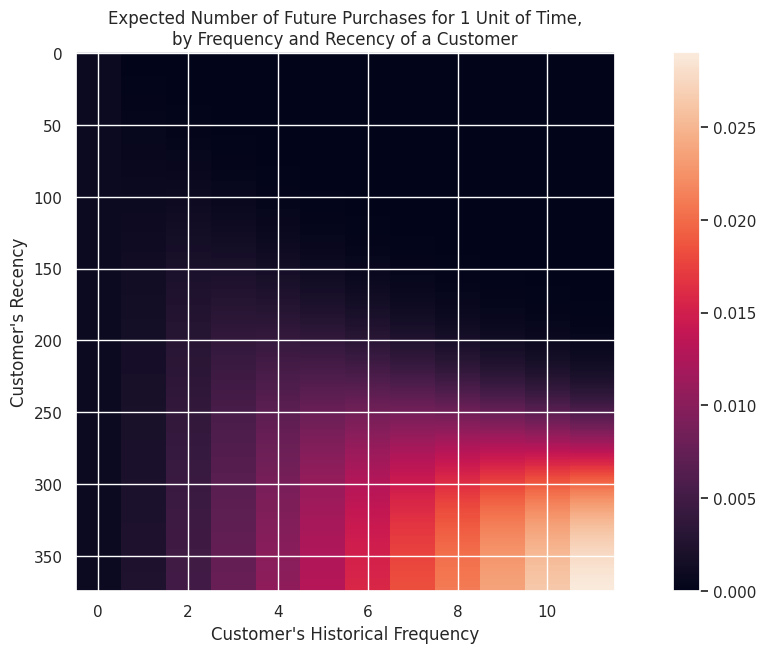

In [ ]:
#dự đoán số lượng mua trong 1 ngày tiếp theo
fig = plt.figure(figsize=(15,7))
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

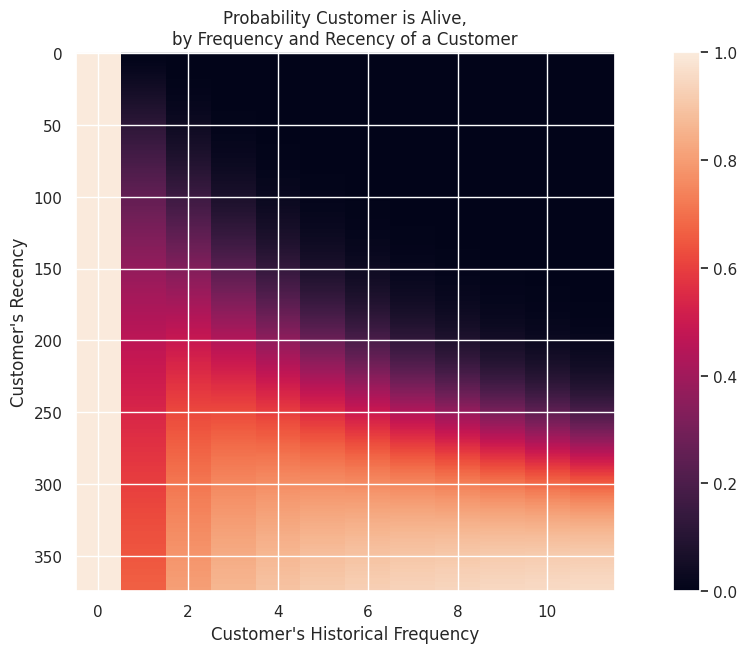

In [ ]:
#dự đoán tỷ lệ khách hàng còn sống
fig = plt.figure(figsize=(15,7))
plot_probability_alive_matrix(bgf)

## Bắt đầu dự đoán số lần mua của khách hàng trong một khoảng thời gian trong tương lai (BG/NBD)

In [ ]:
modeldata=rfm1.copy()
modeldata

CustomerID         Country  Recency  Frequency  Monetary  Avg_Monetary  \
0        12347.0         Iceland      3.0        7.0   4310.00     23.681319   
1        12348.0         Finland     76.0        4.0   1797.24     57.975484   
2        12349.0           Italy     19.0        1.0   1757.55     24.076027   
3        12350.0          Norway    311.0        1.0    334.40     19.670588   
4        12352.0          Norway     37.0        8.0   2506.04     29.482824   
...          ...             ...      ...        ...       ...           ...   
4310     18280.0  United Kingdom    278.0        1.0    180.60     18.060000   
4311     18281.0  United Kingdom    181.0        1.0     80.82     11.545714   
4312     18282.0  United Kingdom      8.0        2.0    178.05     14.837500   
4313     18283.0  United Kingdom      4.0       11.0   2094.88      2.771005   
4314     18287.0  United Kingdom     43.0        3.0   1837.28     26.246857   

      Tenure  
0        368  
1        359  
2         19  
3        311  
4        297  
...      ...  
4310     278  
4311     181  
4312     127  
4313     338  
4314     202  

[4315 rows x 7 columns]

In [ ]:
#dự đoán số lần mua trong 120 ngày tiếp theo
t = 120 #ngày
modeldata['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      modeldata['Frequency'], 
                                                                                      modeldata['Recency'], 
                                                                                      modeldata['Tenure'])

modeldata.sort_values(by='predicted_purchases',ascending=False)

CustomerID         Country  Recency  Frequency  Monetary  Avg_Monetary  \
2667     16000.0  United Kingdom      3.0        3.0  12393.70   1377.077778   
4205     18139.0  United Kingdom     18.0        6.0   8438.34     53.071321   
1977     15060.0  United Kingdom      9.0        4.0    303.09      2.504876   
303      12713.0         Germany      1.0        1.0    848.55     22.330263   
1309     14126.0  United Kingdom      8.0        3.0    706.13     47.075333   
...          ...             ...      ...        ...       ...           ...   
554      13069.0  United Kingdom      1.0       11.0   4436.12     10.437929   
3803     17581.0  United Kingdom      1.0       11.0  11045.04     25.102364   
2453     15694.0  United Kingdom      1.0       11.0   6479.40     83.069231   
264      12662.0         Germany      1.0       11.0   3849.78     16.738174   
1060     13777.0  United Kingdom      1.0       11.0  25977.16    131.863756   

      Tenure  predicted_purchases  
2667       3         2.761558e+01  
4205      19         1.954146e+01  
1977      10         1.891817e+01  
303        1         1.270195e+01  
1309      11         1.154809e+01  
...      ...                  ...  
554      370         6.947437e-24  
3803     373         6.292866e-24  
2453     373         6.292866e-24  
264      374         6.089748e-24  
1060     374         6.089748e-24  

[4315 rows x 8 columns]

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

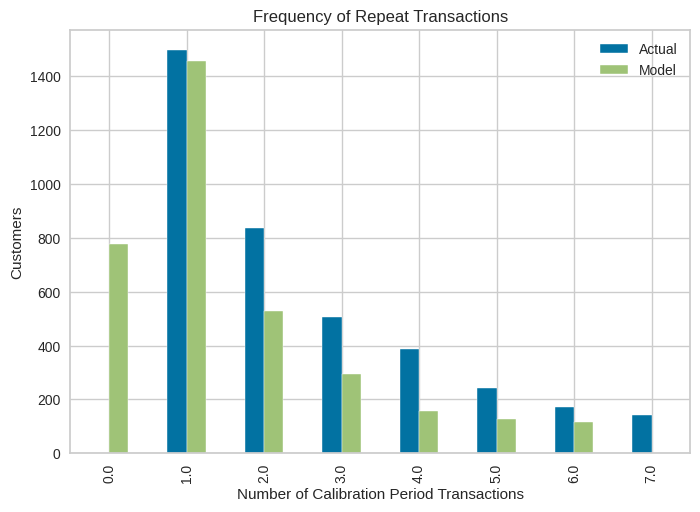

In [ ]:
plot_period_transactions(bgf)

## Train lại mô hình BG/NBD

In [ ]:
df1

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

       InvoiceDate  UnitPrice  CustomerID         Country  
0       2010-12-01       2.55     17850.0  United Kingdom  
1       2010-12-01       3.39     17850.0  United Kingdom  
2       2010-12-01       2.75     17850.0  United Kingdom  
3       2010-12-01       3.39     17850.0  United Kingdom  
4       2010-12-01       3.39     17850.0  United Kingdom  
...            ...        ...         ...             ...  
541904  2011-12-09       0.85     12680.0          France  
541905  2011-12-09       2.10     12680.0          France  
541906  2011-12-09       4.15     12680.0          France  
541907  2011-12-09       4.15     12680.0          France  
541908  2011-12-09       4.95     12680.0          France  

[397884 rows x 8 columns]

In [ ]:
summary_cal_holdout = calibration_and_holdout_data(df1, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-08-09',
                                        observation_period_end='2011-12-09' )
summary_cal_holdout.head()

frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346.0               0.0          0.0  203.0                0.0   
12347.0               4.0        238.0  245.0                2.0   
12348.0               2.0        110.0  236.0                1.0   
12350.0               0.0          0.0  188.0                0.0   
12352.0               3.0         34.0  174.0                3.0   

            duration_holdout  
CustomerID                    
12346.0                122.0  
12347.0                122.0  
12348.0                122.0  
12350.0                122.0  
12352.0                122.0

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

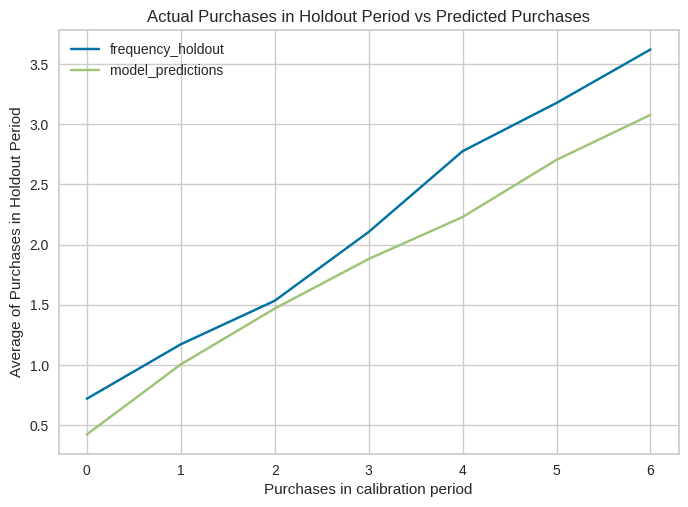

In [ ]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf2 = BetaGeoFitter(penalizer_coef=0.1)
bgf2.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf2, summary_cal_holdout)

In [ ]:
t = 120
summary_cal_holdout['predicted_purchases'] = bgf2.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      summary_cal_holdout['frequency_cal'], 
                                                                                      summary_cal_holdout['recency_cal'], 
                                                                                      summary_cal_holdout['T_cal'])

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

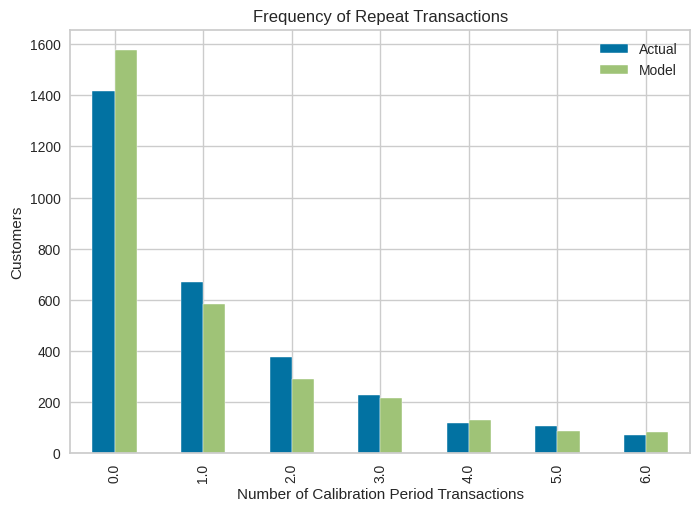

In [ ]:
plot_period_transactions(bgf2)

In [ ]:
#dataframe với mã khách hàng và số lần mua được dự đoán trong 4 tháng (120 ngày) tới
pred_purchase=summary_cal_holdout.reset_index()[['CustomerID','predicted_purchases']]
pred_purchase=pred_purchase.dropna()
pred_purchase

CustomerID  predicted_purchases
0        12346.0             0.252981
1        12347.0             1.863848
2        12348.0             1.073334
3        12350.0             0.269172
4        12352.0             1.919811
...          ...                  ...
3198     18273.0             0.347825
3199     18280.0             0.313281
3200     18281.0             0.604411
3202     18283.0             3.455074
3203     18287.0             0.503178

[3094 rows x 2 columns]

# Gamma Gamma model dự đoán giá trị trung bình của mỗi lần mua
cltv = predicted_purchase * aov * margin(discount....)

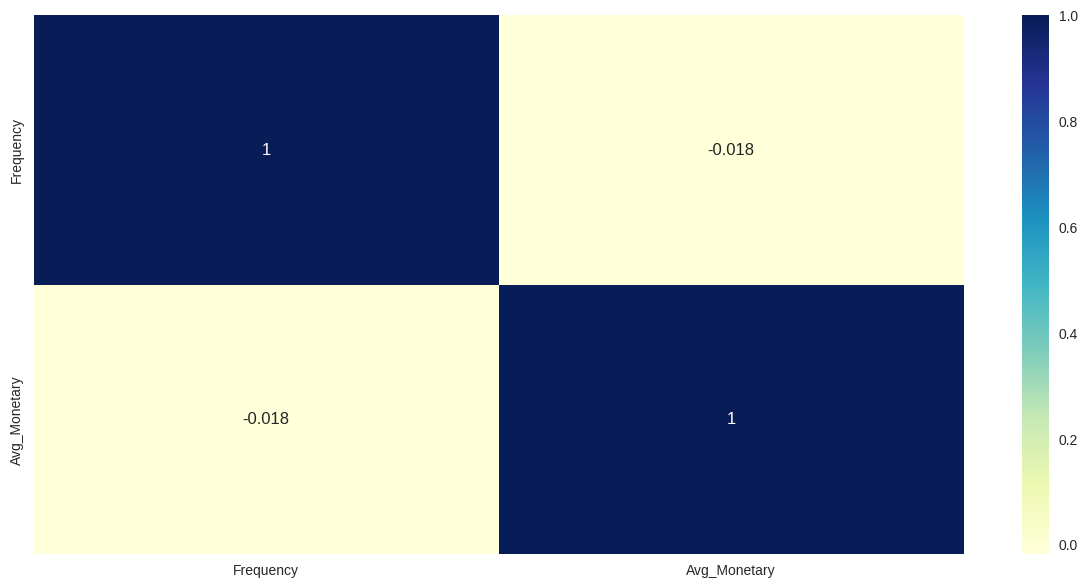

In [ ]:
#tương quan giữa các biến
#lấy model data (chính là rfm1)
plt.figure(figsize=(15,7))
df_heatmap=sns.heatmap(modeldata[['Frequency','Avg_Monetary']].corr(), cmap="YlGnBu", annot=True)
plt.show()

In [ ]:
#chỉ lấy khách hàng giao dịch trên một lần (khách hàng quay lại) và monetary lớn hơn 0
returning_customers = rfm[ (rfm['Frequency'] > 1) & (rfm['Monetary'] > 0)]
returning_customers

CustomerID         Country  Recency  Frequency  Monetary  Avg_Monetary  \
1        12347.0         Iceland        3          7   4310.00     23.681319   
2        12348.0         Finland       76          4   1797.24     57.975484   
5        12352.0          Norway       37          8   2506.04     29.482824   
9        12356.0        Portugal       23          3   2811.43     47.651356   
11       12358.0         Austria        2          2   1168.06     61.476842   
...          ...             ...      ...        ...       ...           ...   
4335     18272.0  United Kingdom        3          6   3078.58     18.545663   
4336     18273.0  United Kingdom        3          3    204.00     68.000000   
4343     18282.0  United Kingdom        8          2    178.05     14.837500   
4344     18283.0  United Kingdom        4         16   2094.88      2.771005   
4345     18287.0  United Kingdom       43          3   1837.28     26.246857   

      Tenure  
1        368  
2        359  
5        297  
9        326  
11       151  
...      ...  
4335     247  
4336     258  
4343     127  
4344     338  
4345     202  

[2847 rows x 7 columns]

In [ ]:
#dự đoán giá trị trung bình cho mỗi lần mua trong tương lai 
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.1)
ggf.fit(returning_customers['Frequency'],
        returning_customers['Avg_Monetary'])

<lifetimes.GammaGammaFitter: fitted with 2847 subjects, p: 1.24, q: 0.38, v: 1.17>

In [ ]:
#dự đoán giá trị trung bình của mỗi lần mua (average order value - aov)
pred_aov=pd.DataFrame({'CustomerID': returning_customers['CustomerID'],
                    'AOV':ggf.conditional_expected_average_profit(returning_customers['Frequency'], returning_customers['Avg_Monetary'])
    
}).reset_index()
pred_aov=pred_aov.drop(['index'],axis=1)
pred_aov

CustomerID        AOV
0        12347.0  25.664820
1        12348.0  66.505483
2        12352.0  31.585052
3        12356.0  57.544751
4        12358.0  82.499034
...          ...        ...
2842     18272.0  20.427233
2843     18273.0  81.918997
2844     18282.0  20.500316
2845     18283.0   2.934907
2846     18287.0  31.905770

[2847 rows x 2 columns]

In [ ]:
df_cltv=pred_purchase.merge(pred_aov, on="CustomerID", how="inner")
df_cltv

CustomerID  predicted_purchases        AOV
0        12347.0             1.863848  25.664820
1        12348.0             1.073334  66.505483
2        12352.0             1.919811  31.585052
3        12356.0             0.734174  57.544751
4        12358.0             0.848189  82.499034
...          ...                  ...        ...
2370     18270.0             0.331382  34.994461
2371     18272.0             1.778894  20.427233
2372     18273.0             0.347825  81.918997
2373     18283.0             3.455074   2.934907
2374     18287.0             0.503178  31.905770

[2375 rows x 3 columns]

In [ ]:
df_cltv['CLTV']=df_cltv['predicted_purchases']*df_cltv['AOV']
df_cltv

CustomerID  predicted_purchases        AOV       CLTV
0        12347.0             1.863848  25.664820  47.835311
1        12348.0             1.073334  66.505483  71.382628
2        12352.0             1.919811  31.585052  60.637320
3        12356.0             0.734174  57.544751  42.247863
4        12358.0             0.848189  82.499034  69.974752
...          ...                  ...        ...        ...
2370     18270.0             0.331382  34.994461  11.596529
2371     18272.0             1.778894  20.427233  36.337878
2372     18273.0             0.347825  81.918997  28.493462
2373     18283.0             3.455074   2.934907  10.140322
2374     18287.0             0.503178  31.905770  16.054269

[2375 rows x 4 columns]

In [ ]:
returning_customers

CustomerID         Country  Recency  Frequency  Monetary  Avg_Monetary  \
1        12347.0         Iceland        3          7   4310.00     23.681319   
2        12348.0         Finland       76          4   1797.24     57.975484   
5        12352.0          Norway       37          8   2506.04     29.482824   
9        12356.0        Portugal       23          3   2811.43     47.651356   
11       12358.0         Austria        2          2   1168.06     61.476842   
...          ...             ...      ...        ...       ...           ...   
4335     18272.0  United Kingdom        3          6   3078.58     18.545663   
4336     18273.0  United Kingdom        3          3    204.00     68.000000   
4343     18282.0  United Kingdom        8          2    178.05     14.837500   
4344     18283.0  United Kingdom        4         16   2094.88      2.771005   
4345     18287.0  United Kingdom       43          3   1837.28     26.246857   

      Tenure  
1        368  
2        359  
5        297  
9        326  
11       151  
...      ...  
4335     247  
4336     258  
4343     127  
4344     338  
4345     202  

[2847 rows x 7 columns]

In [ ]:
df2_cltv=df_cltv.merge(returning_customers,on='CustomerID',how='inner')
df2_cltv

CustomerID  predicted_purchases        AOV       CLTV         Country  \
0        12347.0             1.863848  25.664820  47.835311         Iceland   
1        12348.0             1.073334  66.505483  71.382628         Finland   
2        12352.0             1.919811  31.585052  60.637320          Norway   
3        12356.0             0.734174  57.544751  42.247863        Portugal   
4        12358.0             0.848189  82.499034  69.974752         Austria   
...          ...                  ...        ...        ...             ...   
2376     18270.0             0.331382  34.994461  11.596529  United Kingdom   
2377     18272.0             1.778894  20.427233  36.337878  United Kingdom   
2378     18273.0             0.347825  81.918997  28.493462  United Kingdom   
2379     18283.0             3.455074   2.934907  10.140322  United Kingdom   
2380     18287.0             0.503178  31.905770  16.054269  United Kingdom   

      Recency  Frequency  Monetary  Avg_Monetary  Tenure  
0           3          7   4310.00     23.681319     368  
1          76          4   1797.24     57.975484     359  
2          37          8   2506.04     29.482824     297  
3          23          3   2811.43     47.651356     326  
4           2          2   1168.06     61.476842     151  
...       ...        ...       ...           ...     ...  
2376       39          2    283.15     25.740909     267  
2377        3          6   3078.58     18.545663     247  
2378        3          3    204.00     68.000000     258  
2379        4         16   2094.88      2.771005     338  
2380       43          3   1837.28     26.246857     202  

[2381 rows x 10 columns]

<Axes: xlabel='AOV', ylabel='Density'>

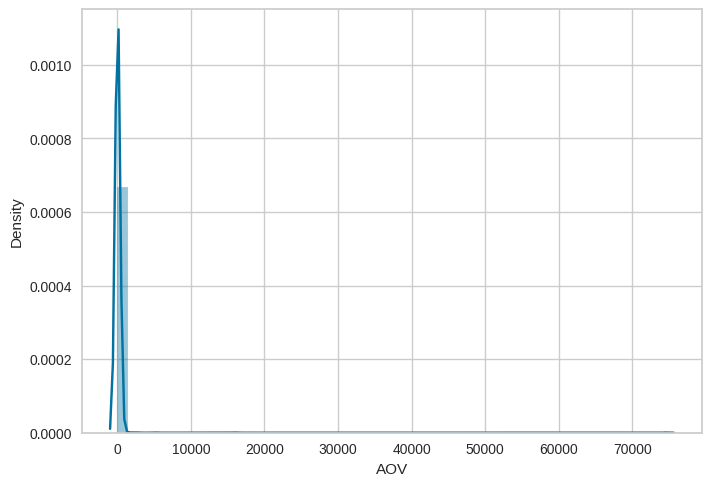

In [ ]:
#visualise phân phối của các biến
# fig,ax=plt.subplots(nrows=2,figsize=(20,10))
# ax[0]=sns.distplot(cltv_final['AOV'])
# ax[1]=sns.distplot(cltv_final['CLTV'])
# plt.show()
sns.distplot(df2_cltv['AOV'])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

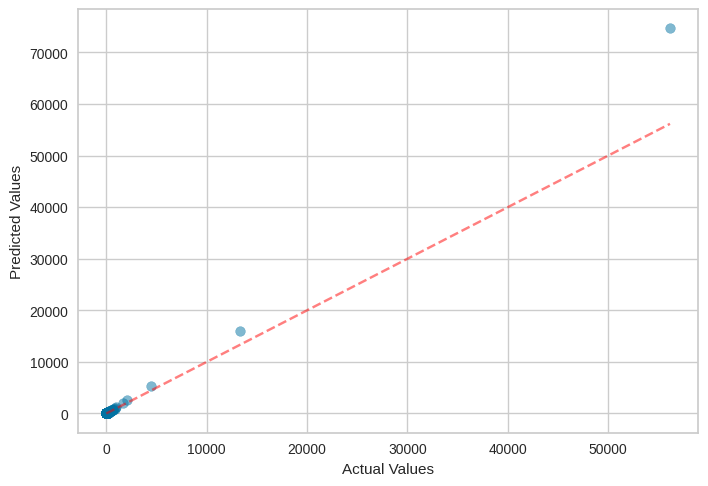

In [ ]:
# tạo biểu đồ phân tán
plt.scatter(df2_cltv['Avg_Monetary'], df2_cltv['AOV'], alpha=0.5)

# thêm đường thẳng tuyến tính
plt.plot([0, max(df2_cltv['Avg_Monetary'])], [0, max(df2_cltv['Avg_Monetary'])], linestyle='--', color='red', alpha=0.5)

# thêm nhãn cho trục
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")


plt.show()

In [ ]:
#đánh giá mô hình bằng chỉ số RMSE
print('RMSE: ', mean_squared_error(df2_cltv['Avg_Monetary'], df2_cltv['AOV'], squared=False))

RMSE:  383.8668978285207


## Train lại gamma gamma model

In [ ]:
rfm_train_test = calibration_and_holdout_data(df2, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-07-09',
                                        observation_period_end='2011-12-09',
                                                  monetary_value_col = 'TotalPrice')

rfm_train_test = rfm_train_test.loc[rfm_train_test.frequency_cal > 1, :]

rfm_train_test.head()

frequency_cal  recency_cal  T_cal  monetary_value_cal  \
CustomerID                                                          
12347.0               3.0        184.0  214.0          498.053333   
12348.0               2.0        110.0  205.0          297.220000   
12352.0               3.0         34.0  143.0          421.770000   
12359.0               2.0        142.0  178.0         1474.115000   
12362.0               2.0        140.0  142.0          399.500000   

            frequency_holdout  monetary_value_holdout  duration_holdout  
CustomerID                                                               
12347.0                   3.0               26.300625             153.0  
12348.0                   1.0              103.333333             153.0  
12352.0                   3.0               20.090000             153.0  
12359.0                   1.0               27.398571             153.0  
12362.0                   7.0               20.670838             153.0

In [ ]:
rfm_train_test.reset_index()

CustomerID  frequency_cal  recency_cal  T_cal  monetary_value_cal  \
0       12347.0            3.0        184.0  214.0          498.053333   
1       12348.0            2.0        110.0  205.0          297.220000   
2       12352.0            3.0         34.0  143.0          421.770000   
3       12359.0            2.0        142.0  178.0         1474.115000   
4       12362.0            2.0        140.0  142.0          399.500000   
..          ...            ...          ...    ...                 ...   
954     18241.0            2.0         53.0   64.0           61.000000   
955     18245.0            2.0        144.0  202.0          470.280000   
956     18257.0            3.0        128.0  143.0          202.400000   
957     18260.0            5.0        186.0  205.0          482.500000   
958     18283.0            6.0        168.0  184.0          122.355000   

     frequency_holdout  monetary_value_holdout  duration_holdout  
0                  3.0               26.300625             153.0  
1                  1.0              103.333333             153.0  
2                  3.0               20.090000             153.0  
3                  1.0               27.398571             153.0  
4                  7.0               20.670838             153.0  
..                 ...                     ...               ...  
954               14.0               21.136800             153.0  
955                2.0               15.190000             153.0  
956                3.0               18.693733             153.0  
957                0.0                0.000000             153.0  
958                7.0                3.032203             153.0  

[959 rows x 8 columns]

In [ ]:
ggf2 = GammaGammaFitter(penalizer_coef = 0.1)
ggf2.fit(rfm_train_test['frequency_cal'],
        rfm_train_test['monetary_value_cal'])

<lifetimes.GammaGammaFitter: fitted with 959 subjects, p: 0.99, q: 0.18, v: 0.93>

In [ ]:
df2_pred_aov=ggf2.conditional_expected_average_profit(rfm_train_test['frequency_holdout'], rfm_train_test['monetary_value_holdout'])
df2_pred_aov=df2_pred_aov.to_frame().reset_index()

In [ ]:
df3_pred_aov=df2_pred_aov.rename(columns = {df2_pred_aov.columns[1]: 'AOV'})  # Apply rename function
df3_pred_aov

CustomerID         AOV
0       12347.0   36.786136
1       12348.0  612.978653
2       12352.0   28.200369
3       12359.0  166.536043
4       12362.0   23.601470
..          ...         ...
954     18241.0   22.539142
955     18245.0   26.756349
956     18257.0   26.270125
957     18260.0   -1.117345
958     18283.0    3.590341

[959 rows x 2 columns]

In [ ]:
df3_cltv=pred_purchase.merge(df3_pred_aov, on="CustomerID", how="inner")
df3_cltv

CustomerID  predicted_purchases         AOV
0       12347.0             1.863848   36.786136
1       12348.0             1.073334  612.978653
2       12352.0             1.919811   28.200369
3       12359.0             1.186812  166.536043
4       12362.0             1.381567   23.601470
..          ...                  ...         ...
954     18241.0             4.690103   22.539142
955     18245.0             1.514382   26.756349
956     18257.0             1.919811   26.270125
957     18260.0             2.348211   -1.117345
958     18283.0             3.455074    3.590341

[959 rows x 3 columns]

<Axes: xlabel='AOV', ylabel='Density'>

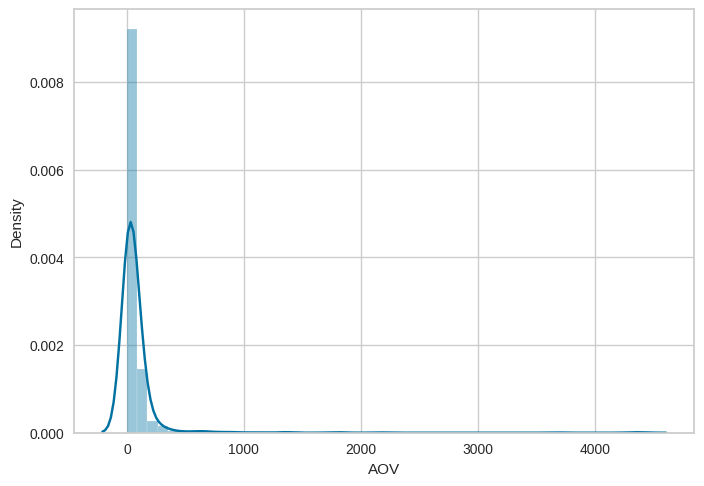

In [ ]:
sns.distplot(df3_cltv['AOV'])

In [ ]:
df3_cltv['CLTV']=df3_cltv['predicted_purchases']*df3_cltv['AOV']
df3_cltv

CustomerID  predicted_purchases         AOV        CLTV
0       12347.0             1.863848   36.786136   68.563749
1       12348.0             1.073334  612.978653  657.931128
2       12352.0             1.919811   28.200369   54.139369
3       12359.0             1.186812  166.536043  197.647039
4       12362.0             1.381567   23.601470   32.607002
..          ...                  ...         ...         ...
954     18241.0             4.690103   22.539142  105.710906
955     18245.0             1.514382   26.756349   40.519332
956     18257.0             1.919811   26.270125   50.433666
957     18260.0             2.348211   -1.117345   -2.623761
958     18283.0             3.455074    3.590341   12.404894

[959 rows x 4 columns]

In [ ]:
df4_cltv=df3_cltv.merge(rfm_train_test, on='CustomerID',how='inner')

In [ ]:
df5_cltv=df4_cltv[df4_cltv['AOV']>0]

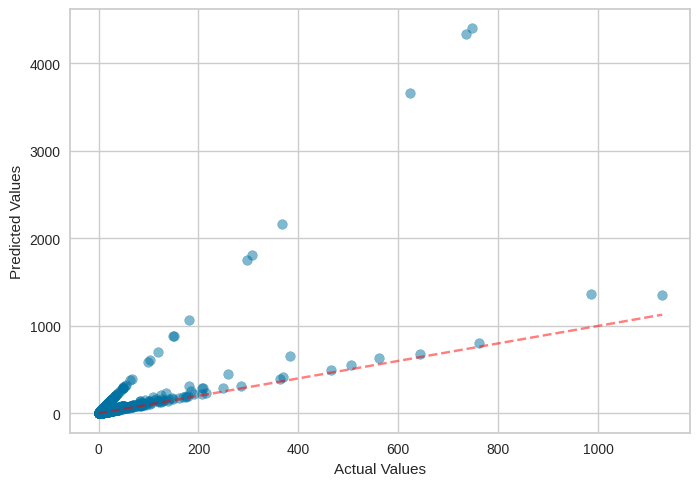

In [ ]:

plt.scatter(df4_cltv['monetary_value_holdout'], df4_cltv['AOV'], alpha=0.5)


plt.plot([0, max(df4_cltv['monetary_value_holdout'])], [0, max(df4_cltv['monetary_value_holdout'])], linestyle='--', color='red', alpha=0.5)


plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")


plt.show()

In [ ]:
print('RMSE',mean_squared_error(df4_cltv['monetary_value_holdout'], df4_cltv['AOV'], squared=False))

RMSE 223.99959163950027


## Khi không train model nhưng sử dụng bộ data đã bỏ outlier


In [ ]:
returning_customers_no_outlier = rfm1[ (rfm1['Frequency'] > 1) & (rfm1['Monetary'] > 0)]
returning_customers_no_outlier

CustomerID         Country  Recency  Frequency  Monetary  Avg_Monetary  \
0        12347.0         Iceland      3.0        7.0   4310.00     23.681319   
1        12348.0         Finland     76.0        4.0   1797.24     57.975484   
4        12352.0          Norway     37.0        8.0   2506.04     29.482824   
8        12356.0        Portugal     23.0        3.0   2811.43     47.651356   
10       12358.0         Austria      2.0        2.0   1168.06     61.476842   
...          ...             ...      ...        ...       ...           ...   
4304     18272.0  United Kingdom      3.0        6.0   3078.58     18.545663   
4305     18273.0  United Kingdom      3.0        3.0    204.00     68.000000   
4312     18282.0  United Kingdom      8.0        2.0    178.05     14.837500   
4313     18283.0  United Kingdom      4.0       11.0   2094.88      2.771005   
4314     18287.0  United Kingdom     43.0        3.0   1837.28     26.246857   

      Tenure  
0        368  
1        359  
4        297  
8        326  
10       151  
...      ...  
4304     247  
4305     258  
4312     127  
4313     338  
4314     202  

[2817 rows x 7 columns]

In [ ]:
ggf_no_outlier = GammaGammaFitter(penalizer_coef = 0.1)
ggf_no_outlier.fit(returning_customers_no_outlier['Frequency'],
        returning_customers_no_outlier['Avg_Monetary'])

<lifetimes.GammaGammaFitter: fitted with 2817 subjects, p: 1.25, q: 0.39, v: 1.17>

- "p" là tham số hình dạng (shape) của phân phối Gamma được ước tính. Tham số này ảnh hưởng đến hình dạng của đường cong phân phối Gamma.
- "q" là tham số tỷ lệ (scale) của phân phối Gamma được ước tính. Tham số này ảnh hưởng đến độ rộng của đường cong phân phối Gamma và tỷ lệ giữa giá trị đầu ra và giá trị đầu vào của hàm mật độ xác suất.
- "v" là giá trị hệ số biến động (coefficient of variation), được tính bằng tỷ lệ giữa độ lệch chuẩn và giá trị trung bình. Giá trị này cho biết độ biến động của dữ liệu, càng cao thì dữ liệu càng biến động.

In [ ]:
pred_aov_no_outlier=pd.DataFrame({'CustomerID': returning_customers_no_outlier['CustomerID'],
                    'AOV':ggf_no_outlier.conditional_expected_average_profit(returning_customers_no_outlier['Frequency'], returning_customers_no_outlier['Avg_Monetary'])
    
}).reset_index()
pred_aov_no_outlier=pred_aov_no_outlier.drop(['index'],axis=1)
pred_aov_no_outlier

CustomerID        AOV
0        12347.0  25.643311
1        12348.0  66.399972
2        12352.0  31.561962
3        12356.0  57.417340
4        12358.0  82.194059
...          ...        ...
2812     18272.0  20.407181
2813     18273.0  81.736821
2814     18282.0  20.426881
2815     18283.0   3.011754
2816     18287.0  31.835964

[2817 rows x 2 columns]

In [ ]:
df_cltv_no_outlier=pred_purchase.merge(pred_aov_no_outlier, on="CustomerID", how="inner")
df_cltv_no_outlier

CustomerID  predicted_purchases        AOV
0        12347.0             1.863848  25.643311
1        12348.0             1.073334  66.399972
2        12352.0             1.919811  31.561962
3        12356.0             0.734174  57.417340
4        12358.0             0.848189  82.194059
...          ...                  ...        ...
2341     18270.0             0.331382  34.866896
2342     18272.0             1.778894  20.407181
2343     18273.0             0.347825  81.736821
2344     18283.0             3.455074   3.011754
2345     18287.0             0.503178  31.835964

[2346 rows x 3 columns]

<Axes: xlabel='AOV', ylabel='Density'>

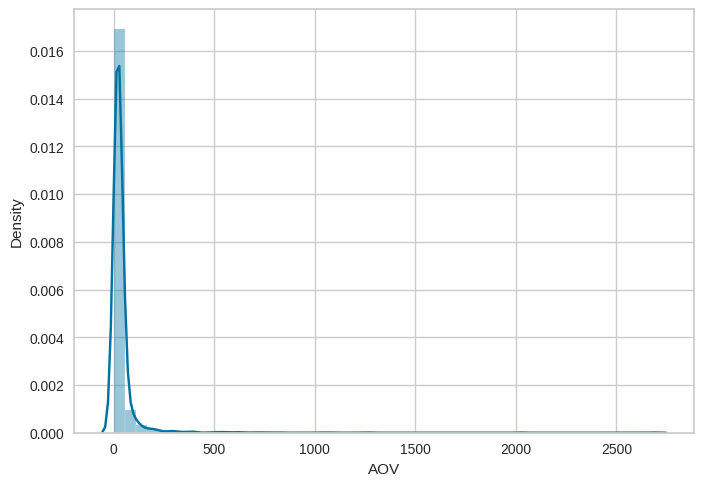

In [ ]:
sns.distplot(df_cltv_no_outlier['AOV'])

In [ ]:
df_cltv_no_outlier['CLTV']=df_cltv_no_outlier['predicted_purchases']*df_cltv_no_outlier['AOV']
df_cltv_no_outlier

CustomerID  predicted_purchases        AOV       CLTV
0        12347.0             1.863848  25.643311  47.795222
1        12348.0             1.073334  66.399972  71.269379
2        12352.0             1.919811  31.561962  60.592990
3        12356.0             0.734174  57.417340  42.154320
4        12358.0             0.848189  82.194059  69.716076
...          ...                  ...        ...        ...
2341     18270.0             0.331382  34.866896  11.554257
2342     18272.0             1.778894  20.407181  36.302208
2343     18273.0             0.347825  81.736821  28.430097
2344     18283.0             3.455074   3.011754  10.405834
2345     18287.0             0.503178  31.835964  16.019145

[2346 rows x 4 columns]

In [ ]:
df2_cltv_no_outlier=df_cltv_no_outlier.merge(returning_customers_no_outlier,on='CustomerID',how='inner')
df2_cltv_no_outlier

CustomerID  predicted_purchases        AOV       CLTV         Country  \
0        12347.0             1.863848  25.643311  47.795222         Iceland   
1        12348.0             1.073334  66.399972  71.269379         Finland   
2        12352.0             1.919811  31.561962  60.592990          Norway   
3        12356.0             0.734174  57.417340  42.154320        Portugal   
4        12358.0             0.848189  82.194059  69.716076         Austria   
...          ...                  ...        ...        ...             ...   
2347     18270.0             0.331382  34.866896  11.554257  United Kingdom   
2348     18272.0             1.778894  20.407181  36.302208  United Kingdom   
2349     18273.0             0.347825  81.736821  28.430097  United Kingdom   
2350     18283.0             3.455074   3.011754  10.405834  United Kingdom   
2351     18287.0             0.503178  31.835964  16.019145  United Kingdom   

      Recency  Frequency  Monetary  Avg_Monetary  Tenure  
0         3.0        7.0   4310.00     23.681319     368  
1        76.0        4.0   1797.24     57.975484     359  
2        37.0        8.0   2506.04     29.482824     297  
3        23.0        3.0   2811.43     47.651356     326  
4         2.0        2.0   1168.06     61.476842     151  
...       ...        ...       ...           ...     ...  
2347     39.0        2.0    283.15     25.740909     267  
2348      3.0        6.0   3078.58     18.545663     247  
2349      3.0        3.0    204.00     68.000000     258  
2350      4.0       11.0   2094.88      2.771005     338  
2351     43.0        3.0   1837.28     26.246857     202  

[2352 rows x 10 columns]

In [ ]:
print('RMSE: ', mean_squared_error(df2_cltv_no_outlier['Avg_Monetary'], df2_cltv_no_outlier['AOV'], squared=False))

RMSE:  21.21758389367782


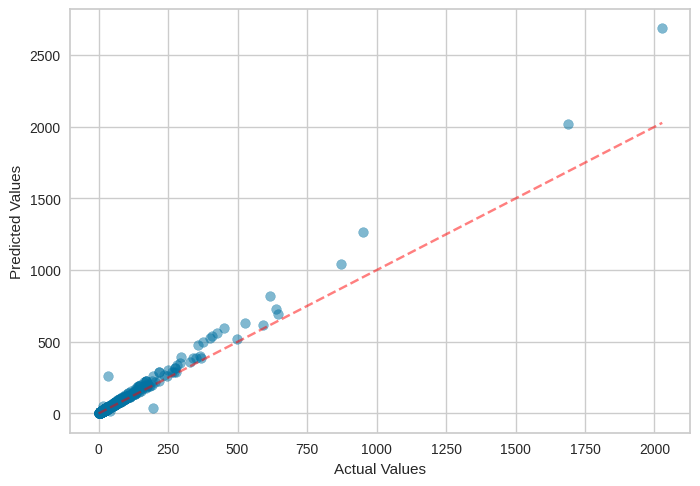

In [ ]:
# y_actual = df2_cltv_no_outlier["Avg_Monetary"]
# y_predicted = GammaGammaFitter.predict(test_data)


plt.scatter(df2_cltv_no_outlier["Avg_Monetary"], df2_cltv_no_outlier["AOV"], alpha=0.5)


plt.plot([0, max(df2_cltv_no_outlier["Avg_Monetary"])], [0, max(df2_cltv_no_outlier["Avg_Monetary"])], linestyle='--', color='red', alpha=0.5)


plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")


plt.show()

In [ ]:
#giá trị mua ở các quốc gia
df_aov_country=pd.DataFrame({'Avg_AOV': df2_cltv_no_outlier.groupby('Country')['AOV'].mean(),
                             'Sum_AOV':df2_cltv_no_outlier.groupby('Country')['AOV'].sum()
    
}).reset_index()
df_aov_country


Country     Avg_AOV       Sum_AOV
0            Australia   36.688465    330.196188
1              Austria   48.377952    145.133856
2              Belgium   25.694805    436.811687
3               Canada   26.495142     26.495142
4      Channel Islands   28.923382    144.616908
5               Cyprus   66.347732    464.434122
6       Czech Republic   44.572706     44.572706
7              Denmark   88.007331    440.036654
8                 EIRE   31.060962     31.060962
9   European Community   25.029106     25.029106
10             Finland   58.976898    294.884489
11              France   29.936929   1407.035646
12             Germany   32.829119   1739.943319
13              Greece   25.601930     25.601930
14             Iceland   25.643311     25.643311
15              Israel   68.837935     68.837935
16               Italy   33.087987    132.351947
17               Japan  503.806184   2519.030920
18           Lithuania   54.415778     54.415778
19               Malta   31.290564     31.290564
20         Netherlands   22.392127     89.568507
21              Norway   38.005500    190.027501
22              Poland   25.776634    103.106537
23            Portugal   30.082696    240.661566
24           Singapore  103.244924    103.244924
25               Spain   48.297622    917.654819
26              Sweden   32.086848     96.260543
27         Switzerland   62.292764    809.805927
28      United Kingdom   35.182843  74693.175495
29         Unspecified   27.107829     81.323487

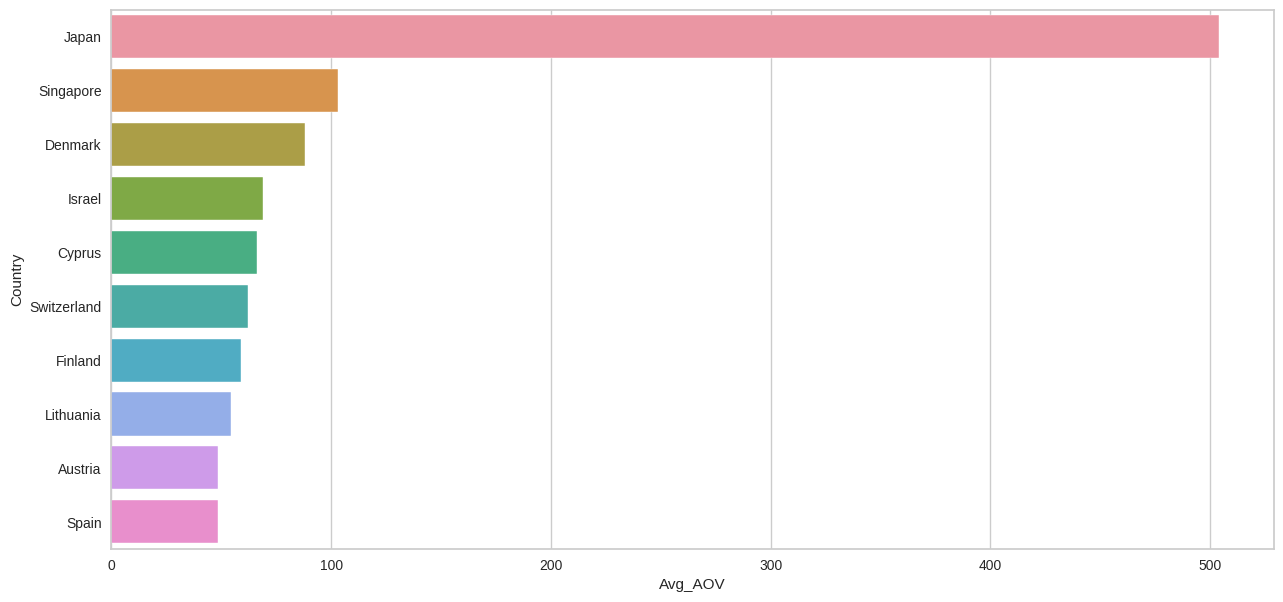

In [ ]:
#visualize
#top 10 quốc gia có giá trị mua trung bình cao nhất
plt.figure(figsize=(15,7))
sns.barplot(data=df_aov_country.sort_values(by='Avg_AOV', ascending=False)[:10],x='Avg_AOV',y='Country')
plt.show()


Nhật Bản có giá trị mua trung bình cao nhất, nghĩa là mức chi tiêu trung bình của khách hàng tại đây cho sản phẩm và dịch vụ tại doanh nghiệp rất cao (cao gấp 2-3 lần) so với các nước khác. Điều đó cho thấy giá trị mỗi lần mua của họ cao, có thể họ tiêu dùng mặt hàng xa xỉ. Doanh nghiệp nên ưu tiên quảng cao những món đồ đắt tiền tại đây. Trường hợp khác là họ mua ít lần, mua dồn vào những dịp đặt biệt. Cần kiểm tra frequency của họ.

In [ ]:
#số lần giao dịch trung bình tại các quốc gia
df_purchase_country=df2_cltv_no_outlier.groupby('Country')['predicted_purchases'].mean().reset_index()
df_purchase_country

Country  predicted_purchases
0            Australia             1.526663
1              Austria             0.882853
2              Belgium             1.825921
3               Canada             3.144713
4      Channel Islands             0.683494
5               Cyprus             1.597769
6       Czech Republic             0.302757
7              Denmark             0.951201
8                 EIRE             1.503618
9   European Community             2.794871
10             Finland             1.549012
11              France             1.677377
12             Germany             1.747374
13              Greece             1.080932
14             Iceland             1.863848
15              Israel             0.830784
16               Italy             1.344929
17               Japan             1.025175
18           Lithuania             0.624066
19               Malta             1.689315
20         Netherlands             1.261927
21              Norway             1.215301
22              Poland             1.525700
23            Portugal             1.281078
24           Singapore             1.745556
25               Spain             1.241199
26              Sweden             1.940045
27         Switzerland             1.148985
28      United Kingdom             1.549280
29         Unspecified             0.861174

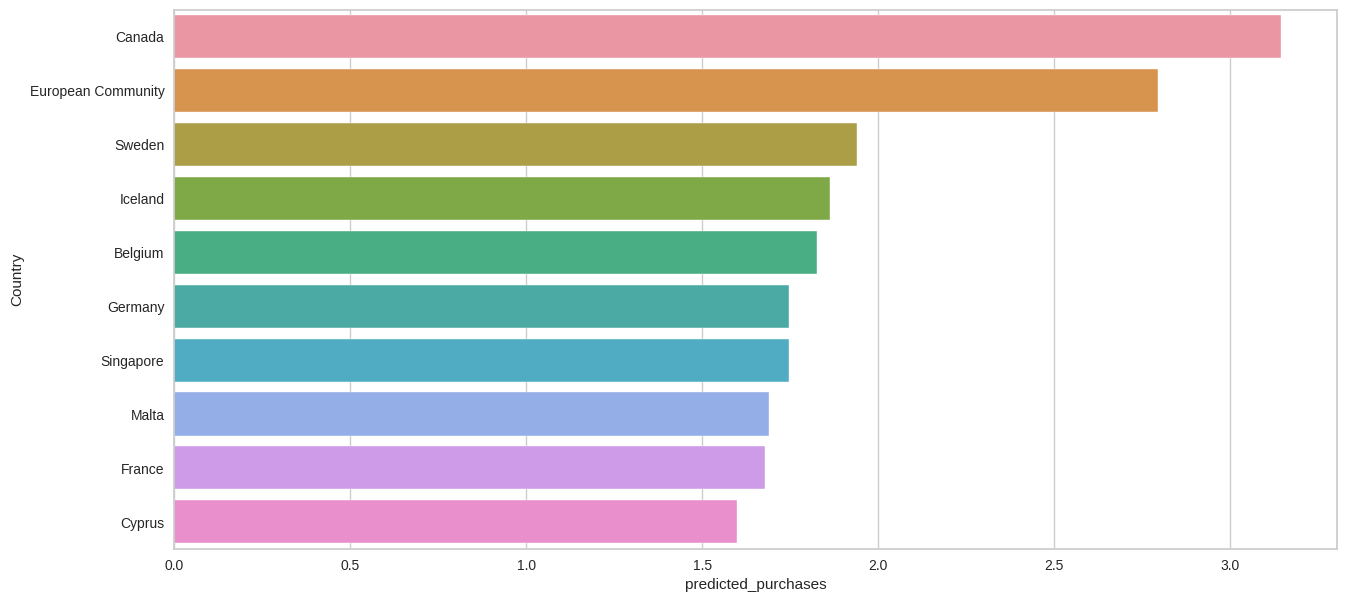

In [ ]:
plt.figure(figsize=(15,7))
sns.barplot(data=df_purchase_country.sort_values(by='predicted_purchases', ascending=False)[:10],x='predicted_purchases',y='Country')
plt.show()

Canada là quốc gia được dự đoán có số lần mua sắm trung bình cao nhất và không có Nhật Bản (chứng tỏ số lần mua ít) nhưng mỗi lần mua lại cao ==> mua dồn, đợi dịp mới mua

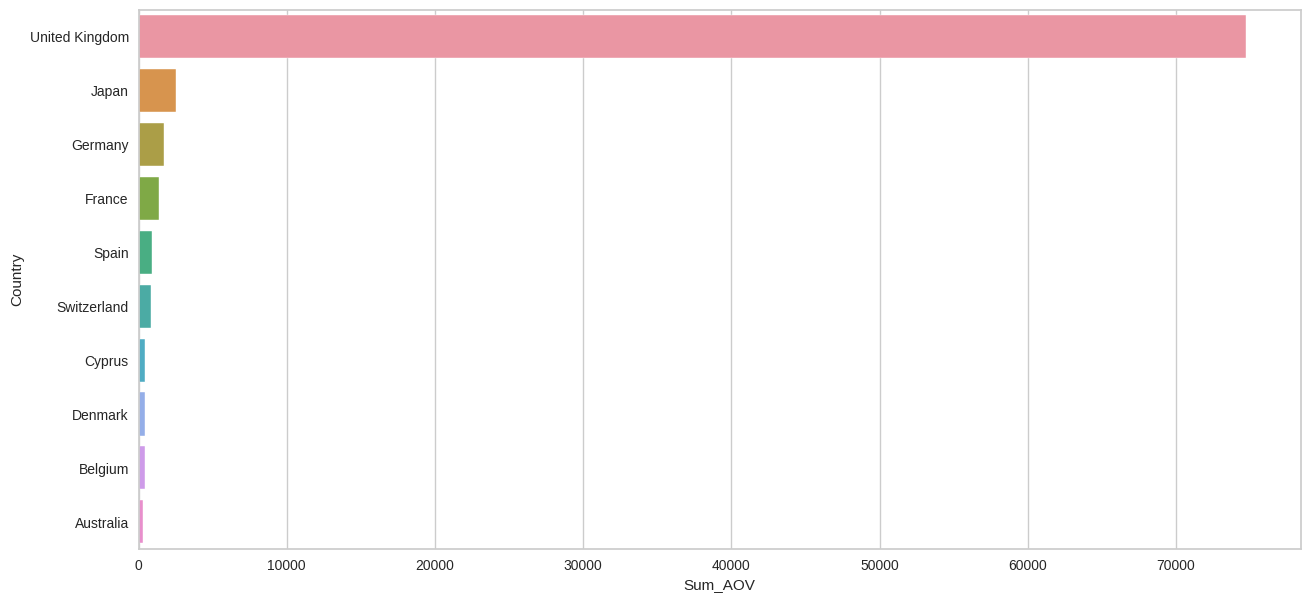

In [ ]:
#top 10 quốc gia có tổng giá trị giao dịch trung bình cao nhất
plt.figure(figsize=(15,7))
sns.barplot(data=df_aov_country.sort_values(by='Sum_AOV', ascending=False)[:10],x='Sum_AOV',y='Country')
plt.show()

Dễ thấy UK là thị trường chính, có nhiều khách hàng nhất. Sô lần mua cũng nằm trong top cao nhưng giá trị mua mỗi lần lại thấp. Nghĩa là họ thường mua hàng (có thể là mua hằng ngày) và mua ít. Tăng cường khuyến mãi giữ chân (cần thêm thông tin về clustering) để biết họ có thuộc nhóm trung thành hay không??

# XGBOOST

## Phân cụm khách hàng hàng XGBoost

In [ ]:
from datetime import datetime, timedelta, date

In [ ]:
rfm1_xg=rfm1.drop_duplicates('CustomerID')

In [ ]:
RFM_xg = rfm1_xg.drop(columns = ['Avg_Monetary', 'Tenure'])
RFM_xg

CustomerID         Country  Recency  Frequency  Monetary
0        12347.0         Iceland      3.0        7.0   4310.00
1        12348.0         Finland     76.0        4.0   1797.24
2        12349.0           Italy     19.0        1.0   1757.55
3        12350.0          Norway    311.0        1.0    334.40
4        12352.0          Norway     37.0        8.0   2506.04
...          ...             ...      ...        ...       ...
4310     18280.0  United Kingdom    278.0        1.0    180.60
4311     18281.0  United Kingdom    181.0        1.0     80.82
4312     18282.0  United Kingdom      8.0        2.0    178.05
4313     18283.0  United Kingdom      4.0       11.0   2094.88
4314     18287.0  United Kingdom     43.0        3.0   1837.28

[4307 rows x 5 columns]

In [ ]:
#Tạo bảng df_user với 2 cột CustomerID và Recency
df_user_xg = RFM_xg.drop(columns=['Country','Frequency','Monetary'])
df_user_xg.head()

CustomerID  Recency
0     12347.0      3.0
1     12348.0     76.0
2     12349.0     19.0
3     12350.0    311.0
4     12352.0     37.0

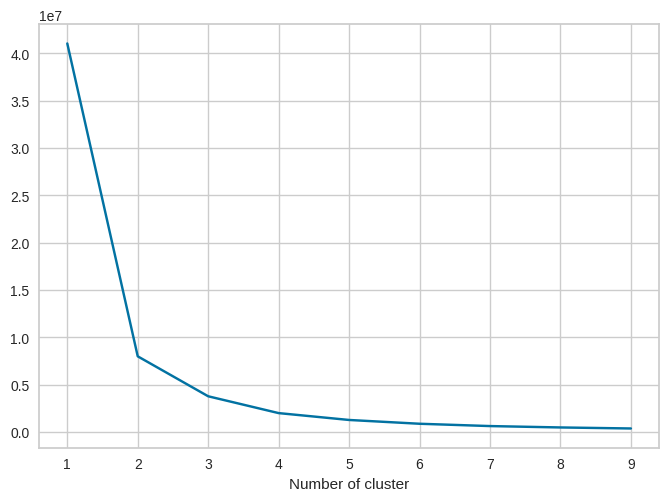

In [ ]:
#Dùng KMeans phân cụm Recency
from sklearn.cluster import KMeans
sse={} # error
df_recency_xg = df_user_xg[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency_xg)
    df_recency_xg["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Chọn k = 4

In [ ]:
#xây dựng 4 cụm cho Recency và thêm vào df_user
kmeans = KMeans(n_clusters=4)
df_user_xg['RecencyCluster'] = kmeans.fit_predict(df_user_xg[['Recency']])
df_user_xg.head()

CustomerID  Recency  RecencyCluster
0     12347.0      3.0               0
1     12348.0     76.0               3
2     12349.0     19.0               0
3     12350.0    311.0               1
4     12352.0     37.0               0

In [ ]:
df_user_xg.groupby('RecencyCluster')['Recency'].describe()

count        mean        std    min    25%    50%    75%  \
RecencyCluster                                                              
0               2087.0   19.678007  13.133280    1.0    9.0   18.0   30.0   
1                606.0  290.255776  34.002877  233.0  261.0  289.5  331.0   
2                590.0  175.052542  29.617865  127.0  150.0  174.0  199.0   
3               1024.0   77.243164  20.369232   50.0   60.0   73.0   90.0   

                  max  
RecencyCluster         
0                48.0  
1               331.5  
2               228.0  
3               125.0

In [ ]:
#sắp xếp lại thứ tự các cụm
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new_xg = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new_xg = df_new_xg.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new_xg['index'] = df_new_xg.index
    df_final_xg = pd.merge(df,df_new_xg[[cluster_field_name,'index']], on=cluster_field_name)
    df_final_xg = df_final_xg.drop([cluster_field_name],axis=1)
    df_final_xg = df_final_xg.rename(columns={"index":cluster_field_name})
    return df_final_xg

df_user_xg = order_cluster('RecencyCluster', 'Recency',df_user_xg,False)

In [ ]:
df_user_xg.head()

CustomerID  Recency  RecencyCluster
0     12347.0      3.0               3
1     12349.0     19.0               3
2     12352.0     37.0               3
3     12356.0     23.0               3
4     12357.0     34.0               3

In [ ]:
df_user_xg.groupby('RecencyCluster')['Recency'].describe()

count        mean        std    min    25%    50%    75%  \
RecencyCluster                                                              
0                606.0  290.255776  34.002877  233.0  261.0  289.5  331.0   
1                590.0  175.052542  29.617865  127.0  150.0  174.0  199.0   
2               1024.0   77.243164  20.369232   50.0   60.0   73.0   90.0   
3               2087.0   19.678007  13.133280    1.0    9.0   18.0   30.0   

                  max  
RecencyCluster         
0               331.5  
1               228.0  
2               125.0  
3                48.0

Cụm 0 có recency lớn nhất --> hoạt động kém nhất, cụm 3 có recency nhỏ nhất --> hoạt động hiệu quả nhất

**Frequency**

In [ ]:
df_frequency_xg=RFM_xg.drop(columns=['Country','Recency','Monetary'])
df_frequency_xg.head()

CustomerID  Frequency
0     12347.0        7.0
1     12348.0        4.0
2     12349.0        1.0
3     12350.0        1.0
4     12352.0        8.0

In [ ]:
#Nối df_frequency vào df_user
df_user_xg = pd.merge(df_user_xg, df_frequency_xg, on='CustomerID')

df_user_xg.head()

CustomerID  Recency  RecencyCluster  Frequency
0     12347.0      3.0               3        7.0
1     12349.0     19.0               3        1.0
2     12352.0     37.0               3        8.0
3     12356.0     23.0               3        3.0
4     12357.0     34.0               3        1.0

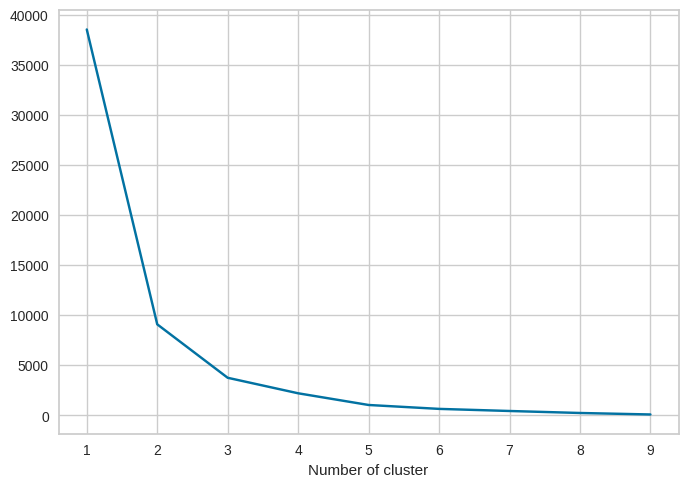

In [ ]:
#Dùng KMeans phân cụm Frequency
from sklearn.cluster import KMeans

sse={} # error
df_recency_xg = df_user_xg[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency_xg)
    df_recency_xg["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Chọn k=4

In [ ]:
#KMeans
kmeans=KMeans(n_clusters=4)
df_user_xg['FrequencyCluster']=kmeans.fit_predict(df_user_xg[['Frequency']])

#sắp xếp cụm frequency
df_user_xg = order_cluster('FrequencyCluster', 'Frequency', df_user_xg, True )
df_user_xg.groupby('FrequencyCluster')['Frequency'].describe()

count       mean       std  min   25%   50%   75%   max
FrequencyCluster                                                          
0                 2331.0   1.358644  0.479705  1.0   1.0   1.0   2.0   2.0
1                 1133.0   3.767873  0.778437  3.0   3.0   4.0   4.0   5.0
2                  412.0   6.825243  0.791404  6.0   6.0   7.0   7.0   8.0
3                  431.0  10.563805  0.747080  9.0  10.0  11.0  11.0  11.0

Cụm có tần số lớn nhất là cụm 3, tần số nhỏ nhất là cụm 0

In [ ]:
df_user_xg.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster
0     12347.0      3.0               3        7.0                 2
1     12352.0     37.0               3        8.0                 2
2     12388.0     16.0               3        6.0                 2
3     12417.0      4.0               3        8.0                 2
4     12423.0      1.0               3        8.0                 2

**Monetary**

In [ ]:
df_monetary_xg=RFM_xg.drop(columns=['Country','Recency','Frequency'])
df_monetary_xg

CustomerID  Monetary
0        12347.0   4310.00
1        12348.0   1797.24
2        12349.0   1757.55
3        12350.0    334.40
4        12352.0   2506.04
...          ...       ...
4310     18280.0    180.60
4311     18281.0     80.82
4312     18282.0    178.05
4313     18283.0   2094.88
4314     18287.0   1837.28

[4307 rows x 2 columns]

In [ ]:
#Nối df_monetary vào df_user
df_user_xg = pd.merge(df_user_xg, df_monetary_xg, on='CustomerID')

df_user_xg

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0        12347.0      3.0               3        7.0                 2   
1        12352.0     37.0               3        8.0                 2   
2        12388.0     16.0               3        6.0                 2   
3        12417.0      4.0               3        8.0                 2   
4        12423.0      1.0               3        8.0                 2   
...          ...      ...             ...        ...               ...   
4302     14573.0    180.0               1        9.0                 3   
4303     15235.0    218.0               1       11.0                 3   
4304     16553.0    164.0               1       11.0                 3   
4305     16919.0    157.0               1       11.0                 3   
4306     17504.0    207.0               1        9.0                 3   

      Monetary  
0      4310.00  
1      2506.04  
2      2780.66  
3      3212.80  
4      1859.31  
...        ...  
4302   1653.42  
4303   2247.51  
4304   5719.82  
4305   2596.45  
4306   2997.03  

[4307 rows x 6 columns]

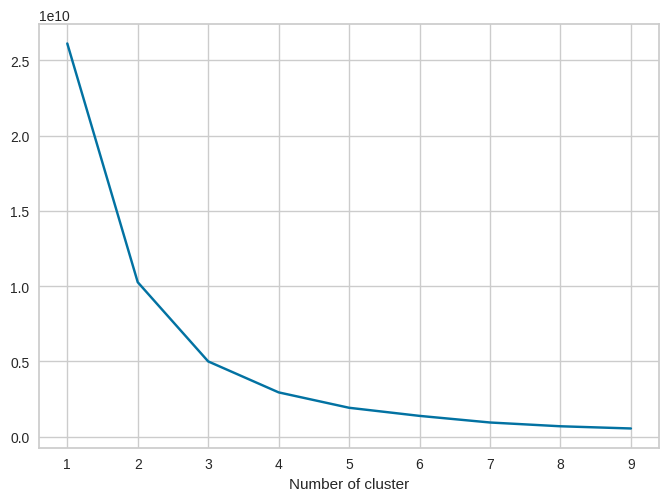

In [ ]:
#Dùng KMeans phân cụm Monetary
from sklearn.cluster import KMeans

sse={} # error
df_recency_xg = df_user_xg[['Monetary']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency_xg)
    df_recency_xg["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Chọn k=4

In [ ]:
#áp dụng KMeans
kmeans = KMeans(n_clusters=4)
df_user_xg['MonetaryCluster'] = kmeans.fit_predict(df_user_xg[['Monetary']])

#sắp xếp các cụm
df_user_xg = order_cluster('MonetaryCluster', 'Monetary',df_user_xg,True)


df_user_xg.groupby('MonetaryCluster')['Monetary'].describe()

count          mean          std       min         25%  \
MonetaryCluster                                                            
0                3418.0    629.333550   480.540090      3.75    247.3500   
1                 714.0   3256.031150  1064.604676   1945.33   2370.3775   
2                 144.0   8796.537778  2247.631850   6065.69   6887.1375   
3                  31.0  20102.761935  4542.806962  14589.04  16590.7200   

                       50%         75%       max  
MonetaryCluster                                   
0                  478.310    911.7700   1942.45  
1                 2970.170   3943.3875   6021.90  
2                 8104.505  10489.8650  14389.90  
3                18641.010  21354.3400  28882.44

Cụm 3 có doanh thu cao nhất, cụm 0 có doanh thu thấp nhất

In [ ]:
df_user_xg

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0        12347.0      3.0               3        7.0                 2   
1        12352.0     37.0               3        8.0                 2   
2        12388.0     16.0               3        6.0                 2   
3        12417.0      4.0               3        8.0                 2   
4        12483.0     18.0               3        8.0                 2   
...          ...      ...             ...        ...               ...   
4302     17381.0      9.0               3       11.0                 3   
4303     17428.0      1.0               3       11.0                 3   
4304     17675.0      2.0               3       11.0                 3   
4305     17677.0      2.0               3       11.0                 3   
4306     17857.0      5.0               3       11.0                 3   

      Monetary  MonetaryCluster  
0      4310.00                1  
1      2506.04                1  
2      2780.66                1  
3      3212.80                1  
4      2484.98                1  
...        ...              ...  
4302  20275.61                3  
4303  17256.85                3  
4304  20374.28                3  
4305  16363.23                3  
4306  26879.04                3  

[4307 rows x 7 columns]

**Overall score dựa trên phân cụm RFM**

In [ ]:
#Tính tổng điểm của mỗi điểm dữ liệu dựa trên thứ tự phân cụm của các thuộc tính. 
df_user_xg['OverallScore'] = df_user_xg['RecencyCluster'] + df_user_xg['FrequencyCluster'] + df_user_xg['MonetaryCluster']
df_user_xg.groupby('OverallScore')['Recency','Frequency','Monetary'].mean()

Recency  Frequency      Monetary
OverallScore                                     
0             290.795414   1.148148    334.644198
1             184.087234   1.476596    450.168915
2              93.706825   1.701950    575.472593
3              42.765673   2.127441    686.514461
4              30.235518   3.949695   1251.654316
5              29.214286   5.765306   2329.115612
6              22.337449   7.489712   3193.343086
7              14.976000  10.320000   4221.250760
8              11.140187  10.831776   9024.744019
9               8.931034  11.000000  20016.446207

Overall Score được dùng để đánh giá và phân cụm khách hàng.
Score 9 là khách hàng tốt nhất, và score 0 ngược lại


In [ ]:
#Phân loại khách hàng dựa trên tổng điểm
df_user_xg['Segment'] = 'Low-Value'
df_user_xg.loc[df_user_xg['OverallScore']>3,'Segment'] = 'Mid-Value' 
df_user_xg.loc[df_user_xg['OverallScore']>7,'Segment'] = 'High-Value'

In [ ]:
df_user_xg

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0        12347.0      3.0               3        7.0                 2   
1        12352.0     37.0               3        8.0                 2   
2        12388.0     16.0               3        6.0                 2   
3        12417.0      4.0               3        8.0                 2   
4        12483.0     18.0               3        8.0                 2   
...          ...      ...             ...        ...               ...   
4302     17381.0      9.0               3       11.0                 3   
4303     17428.0      1.0               3       11.0                 3   
4304     17675.0      2.0               3       11.0                 3   
4305     17677.0      2.0               3       11.0                 3   
4306     17857.0      5.0               3       11.0                 3   

      Monetary  MonetaryCluster  OverallScore     Segment  
0      4310.00                1             6   Mid-Value  
1      2506.04                1             6   Mid-Value  
2      2780.66                1             6   Mid-Value  
3      3212.80                1             6   Mid-Value  
4      2484.98                1             6   Mid-Value  
...        ...              ...           ...         ...  
4302  20275.61                3             9  High-Value  
4303  17256.85                3             9  High-Value  
4304  20374.28                3             9  High-Value  
4305  16363.23                3             9  High-Value  
4306  26879.04                3             9  High-Value  

[4307 rows x 9 columns]

In [ ]:
df2

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

       InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0       2010-12-01       2.55     17850.0  United Kingdom       15.30   
1       2010-12-01       3.39     17850.0  United Kingdom       20.34   
2       2010-12-01       2.75     17850.0  United Kingdom       22.00   
3       2010-12-01       3.39     17850.0  United Kingdom       20.34   
4       2010-12-01       3.39     17850.0  United Kingdom       20.34   
...            ...        ...         ...             ...         ...   
541904  2011-12-09       0.85     12680.0          France       10.20   
541905  2011-12-09       2.10     12680.0          France       12.60   
541906  2011-12-09       4.15     12680.0          France       16.60   
541907  2011-12-09       4.15     12680.0          France       16.60   
541908  2011-12-09       4.95     12680.0          France       14.85   

        Avg_Monetary      Tenure  
0              15.30  2010-12-01  
1              20.34  2010-12-01  
2              22.00  2010-12-01  
3              20.34  2010-12-01  
4              20.34  2010-12-01  
...              ...         ...  
541904         10.20  2011-12-09  
541905         12.60  2011-12-09  
541906         16.60  2011-12-09  
541907         16.60  2011-12-09  
541908         14.85  2011-12-09  

[397884 rows x 11 columns]

In [ ]:
RFM1_xg = pd.merge(RFM_xg, df2, on ='CustomerID', )
RFM1_xg

CustomerID       Country_x  Recency  Frequency  Monetary InvoiceNo  \
0          12347.0         Iceland      3.0        7.0   4310.00    537626   
1          12347.0         Iceland      3.0        7.0   4310.00    537626   
2          12347.0         Iceland      3.0        7.0   4310.00    537626   
3          12347.0         Iceland      3.0        7.0   4310.00    537626   
4          12347.0         Iceland      3.0        7.0   4310.00    537626   
...            ...             ...      ...        ...       ...       ...   
359083     18287.0  United Kingdom     43.0        3.0   1837.28    570715   
359084     18287.0  United Kingdom     43.0        3.0   1837.28    570715   
359085     18287.0  United Kingdom     43.0        3.0   1837.28    573167   
359086     18287.0  United Kingdom     43.0        3.0   1837.28    573167   
359087     18287.0  United Kingdom     43.0        3.0   1837.28    573167   

       StockCode                          Description  Quantity InvoiceDate  \
0          85116      BLACK CANDELABRA T-LIGHT HOLDER        12  2010-12-07   
1          22375    AIRLINE BAG VINTAGE JET SET BROWN         4  2010-12-07   
2          71477    COLOUR GLASS. STAR T-LIGHT HOLDER        12  2010-12-07   
3          22492              MINI PAINT SET VINTAGE         36  2010-12-07   
4          22771  CLEAR DRAWER KNOB ACRYLIC EDWARDIAN        12  2010-12-07   
...          ...                                  ...       ...         ...   
359083     22419                     LIPSTICK PEN RED        12  2011-10-12   
359084     22866        HAND WARMER SCOTTY DOG DESIGN        12  2011-10-12   
359085     23264   SET OF 3 WOODEN SLEIGH DECORATIONS        36  2011-10-28   
359086     21824  PAINTED METAL STAR WITH HOLLY BELLS        48  2011-10-28   
359087     21014        SWISS CHALET TREE DECORATION         24  2011-10-28   

        UnitPrice       Country_y  TotalPrice  Avg_Monetary      Tenure  
0            2.10         Iceland       25.20         25.20  2010-12-07  
1            4.25         Iceland       17.00         17.00  2010-12-07  
2            3.25         Iceland       39.00         39.00  2010-12-07  
3            0.65         Iceland       23.40         23.40  2010-12-07  
4            1.25         Iceland       15.00         15.00  2010-12-07  
...           ...             ...         ...           ...         ...  
359083       0.42  United Kingdom        5.04          5.04  2011-10-12  
359084       2.10  United Kingdom       25.20         25.20  2011-10-12  
359085       1.25  United Kingdom       45.00         45.00  2011-10-28  
359086       0.39  United Kingdom       18.72         18.72  2011-10-28  
359087       0.29  United Kingdom        6.96          6.96  2011-10-28  

[359088 rows x 15 columns]

In [ ]:
RFM1_xg['InvoiceDate'].min()

datetime.date(2010, 12, 1)

In [ ]:
RFM1_xg['InvoiceDate'].max()

datetime.date(2011, 12, 9)

Dựa trên df_UK, ta thấy ngày bắt đầu mua hàng là 1/12/2010 và kết thúc vào 9/12/2011. Để dự đoán giá trị vòng đời khách hàng, ta nên chọn khoảng thời gian 3 tháng, 6 tháng,...nằm giữa 2 mốc thời gian này mà không phải từ khi bắt đầu mua hàng để tránh trường hợp có nhiều khách hàng mới chưa gia nhập. Ở đây chọn 4 tháng là khoảng thời gian đủ dài để dự đoán.

In [ ]:
#Tạo bảng lấy dữ liệu trong 4 tháng

df3_xg = RFM1_xg[(RFM1_xg.InvoiceDate >= date(2011,8,1)) & (RFM1_xg.InvoiceDate < date(2011,12,1))].reset_index(drop=True)

In [ ]:
df3_xg

CustomerID       Country_x  Recency  Frequency  Monetary InvoiceNo  \
0          12347.0         Iceland      3.0        7.0   4310.00    562032   
1          12347.0         Iceland      3.0        7.0   4310.00    562032   
2          12347.0         Iceland      3.0        7.0   4310.00    562032   
3          12347.0         Iceland      3.0        7.0   4310.00    562032   
4          12347.0         Iceland      3.0        7.0   4310.00    562032   
...            ...             ...      ...        ...       ...       ...   
161438     18287.0  United Kingdom     43.0        3.0   1837.28    570715   
161439     18287.0  United Kingdom     43.0        3.0   1837.28    570715   
161440     18287.0  United Kingdom     43.0        3.0   1837.28    573167   
161441     18287.0  United Kingdom     43.0        3.0   1837.28    573167   
161442     18287.0  United Kingdom     43.0        3.0   1837.28    573167   

       StockCode                          Description  Quantity InvoiceDate  \
0          23308   SET OF 60 VINTAGE LEAF CAKE CASES         24  2011-08-02   
1          23297  SET 40 HEART SHAPE PETIT FOUR CASES        16  2011-08-02   
2          22375    AIRLINE BAG VINTAGE JET SET BROWN         4  2011-08-02   
3          22374      AIRLINE BAG VINTAGE JET SET RED         4  2011-08-02   
4          22376    AIRLINE BAG VINTAGE JET SET WHITE         4  2011-08-02   
...          ...                                  ...       ...         ...   
161438     22419                     LIPSTICK PEN RED        12  2011-10-12   
161439     22866        HAND WARMER SCOTTY DOG DESIGN        12  2011-10-12   
161440     23264   SET OF 3 WOODEN SLEIGH DECORATIONS        36  2011-10-28   
161441     21824  PAINTED METAL STAR WITH HOLLY BELLS        48  2011-10-28   
161442     21014        SWISS CHALET TREE DECORATION         24  2011-10-28   

        UnitPrice       Country_y  TotalPrice  Avg_Monetary      Tenure  
0            0.55         Iceland       13.20         13.20  2011-08-02  
1            1.65         Iceland       26.40         26.40  2011-08-02  
2            4.25         Iceland       17.00         17.00  2011-08-02  
3            4.25         Iceland       17.00         17.00  2011-08-02  
4            4.25         Iceland       17.00         17.00  2011-08-02  
...           ...             ...         ...           ...         ...  
161438       0.42  United Kingdom        5.04          5.04  2011-10-12  
161439       2.10  United Kingdom       25.20         25.20  2011-10-12  
161440       1.25  United Kingdom       45.00         45.00  2011-10-28  
161441       0.39  United Kingdom       18.72         18.72  2011-10-28  
161442       0.29  United Kingdom        6.96          6.96  2011-10-28  

[161443 rows x 15 columns]

In [ ]:
#Tính tổng doanh thu mỗi khách hàng trong 4 tháng
df_user_4m_xg = df3_xg.groupby('CustomerID')['TotalPrice'].sum().reset_index()
df_user_4m_xg.columns = ['CustomerID', 'm4_revenue']

In [ ]:
df_user_4m_xg

CustomerID  m4_revenue
0        12347.0     1879.23
1        12348.0      310.00
2        12349.0     1757.55
3        12352.0      944.23
4        12356.0       58.35
...          ...         ...
3053     18277.0      110.38
3054     18278.0      173.90
3055     18282.0      100.21
3056     18283.0      901.11
3057     18287.0     1072.00

[3058 rows x 2 columns]

In [ ]:
df_user_4m_xg['m4_revenue'].max()

16074.5

In [ ]:
df_user_4m_xg['m4_revenue'].min()

6.2

In [ ]:
#vẽ biểu đồ tần số LTV
import plotly.offline as pyoff
plot_data = [
    go.Histogram(
        x=df_user_4m_xg['m4_revenue']
    )
]

plot_layout = go.Layout(
        title='4m Revenue',
        xaxis= {'title': "Revenue"}
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Đa số khách hàng có tổng chi tiêu từ 200-400, thuộc nhóm low-value

In [ ]:
#Chỉ những người trong dòng thời gian của df_user_4m
df_merge_4m_xg = pd.merge(df_user_xg, df_user_4m_xg, on='CustomerID', how='left') 

In [ ]:
df_merge_4m_xg = df_merge_4m_xg.fillna(0)

In [ ]:
df_merge_4m_xg = df_merge_4m_xg[df_merge_4m_xg['m4_revenue'] > 0]
df_merge_4m_xg

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0        12347.0      3.0               3        7.0                 2   
1        12352.0     37.0               3        8.0                 2   
2        12388.0     16.0               3        6.0                 2   
3        12417.0      4.0               3        8.0                 2   
4        12483.0     18.0               3        8.0                 2   
...          ...      ...             ...        ...               ...   
4302     17381.0      9.0               3       11.0                 3   
4303     17428.0      1.0               3       11.0                 3   
4304     17675.0      2.0               3       11.0                 3   
4305     17677.0      2.0               3       11.0                 3   
4306     17857.0      5.0               3       11.0                 3   

      Monetary  MonetaryCluster  OverallScore     Segment  m4_revenue  
0      4310.00                1             6   Mid-Value     1879.23  
1      2506.04                1             6   Mid-Value      944.23  
2      2780.66                1             6   Mid-Value     1112.32  
3      3212.80                1             6   Mid-Value     1381.10  
4      2484.98                1             6   Mid-Value     1170.37  
...        ...              ...           ...         ...         ...  
4302  20275.61                3             9  High-Value     4147.32  
4303  17256.85                3             9  High-Value     7884.96  
4304  20374.28                3             9  High-Value     8027.82  
4305  16363.23                3             9  High-Value     6591.38  
4306  26879.04                3             9  High-Value    14184.16  

[3058 rows x 10 columns]

In [ ]:
df_merge_4m_xg['CustomerID'].nunique()

3058

In [ ]:
df_graph_xg = df_merge_4m_xg.query("m4_revenue < 20000") #because max values are ending at 20,000 as seen in graph above

plot_data = [
    go.Scatter(
        x=df_graph_xg.query("Segment == 'Low-Value'")['OverallScore'],
        y=df_graph_xg.query("Segment == 'Low-Value'")['m4_revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=df_graph_xg.query("Segment == 'Mid-Value'")['OverallScore'],
        y=df_graph_xg.query("Segment == 'Mid-Value'")['m4_revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
    go.Scatter(
        x=df_graph_xg.query("Segment == 'High-Value'")['OverallScore'],
        y=df_graph_xg.query("Segment == 'High-Value'")['m4_revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "4m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Mối tương quan giữa điểm số RFM tổng thể và doanh thu là mối tương quan tích cực. Điểm RFM cao có nghĩa là LTV cao.

In [ ]:
df_merge_4m_xg

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0        12347.0      3.0               3        7.0                 2   
1        12352.0     37.0               3        8.0                 2   
2        12388.0     16.0               3        6.0                 2   
3        12417.0      4.0               3        8.0                 2   
4        12483.0     18.0               3        8.0                 2   
...          ...      ...             ...        ...               ...   
4302     17381.0      9.0               3       11.0                 3   
4303     17428.0      1.0               3       11.0                 3   
4304     17675.0      2.0               3       11.0                 3   
4305     17677.0      2.0               3       11.0                 3   
4306     17857.0      5.0               3       11.0                 3   

      Monetary  MonetaryCluster  OverallScore     Segment  m4_revenue  
0      4310.00                1             6   Mid-Value     1879.23  
1      2506.04                1             6   Mid-Value      944.23  
2      2780.66                1             6   Mid-Value     1112.32  
3      3212.80                1             6   Mid-Value     1381.10  
4      2484.98                1             6   Mid-Value     1170.37  
...        ...              ...           ...         ...         ...  
4302  20275.61                3             9  High-Value     4147.32  
4303  17256.85                3             9  High-Value     7884.96  
4304  20374.28                3             9  High-Value     8027.82  
4305  16363.23                3             9  High-Value     6591.38  
4306  26879.04                3             9  High-Value    14184.16  

[3058 rows x 10 columns]

In [ ]:
#phân loại giá trị vòng đời khách hàng dựa trên tổng doanh thu trong 4 tháng
#tạo 3 cụm tương ứng với 3 phân loại
kmeans = KMeans(n_clusters=3)
df_merge_4m_xg['LTVCluster'] = kmeans.fit_predict(df_merge_4m_xg[['m4_revenue']])

df_merge_4m_xg

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0        12347.0      3.0               3        7.0                 2   
1        12352.0     37.0               3        8.0                 2   
2        12388.0     16.0               3        6.0                 2   
3        12417.0      4.0               3        8.0                 2   
4        12483.0     18.0               3        8.0                 2   
...          ...      ...             ...        ...               ...   
4302     17381.0      9.0               3       11.0                 3   
4303     17428.0      1.0               3       11.0                 3   
4304     17675.0      2.0               3       11.0                 3   
4305     17677.0      2.0               3       11.0                 3   
4306     17857.0      5.0               3       11.0                 3   

      Monetary  MonetaryCluster  OverallScore     Segment  m4_revenue  \
0      4310.00                1             6   Mid-Value     1879.23   
1      2506.04                1             6   Mid-Value      944.23   
2      2780.66                1             6   Mid-Value     1112.32   
3      3212.80                1             6   Mid-Value     1381.10   
4      2484.98                1             6   Mid-Value     1170.37   
...        ...              ...           ...         ...         ...   
4302  20275.61                3             9  High-Value     4147.32   
4303  17256.85                3             9  High-Value     7884.96   
4304  20374.28                3             9  High-Value     8027.82   
4305  16363.23                3             9  High-Value     6591.38   
4306  26879.04                3             9  High-Value    14184.16   

      LTVCluster  
0              0  
1              1  
2              1  
3              1  
4              1  
...          ...  
4302           0  
4303           2  
4304           2  
4305           2  
4306           2  

[3058 rows x 11 columns]

In [ ]:
#sắp xếp số cụm dựa trên LTV
df_merge_4m_xg = order_cluster('LTVCluster', 'm4_revenue',df_merge_4m_xg,True)


df_cluster_xg = df_merge_4m_xg.copy()

#xem chi tiết phân cụm
df_cluster_xg.groupby('LTVCluster')['m4_revenue'].describe()

count         mean          std      min        25%       50%  \
LTVCluster                                                                   
0           2602.0   532.106857   374.243700     6.20   234.2300   418.990   
1            418.0  2563.002105   914.952314  1551.47  1842.0500  2301.145   
2             38.0  8728.246579  2810.134127  5702.55  6401.1725  7955.075   

                   75%       max  
LTVCluster                        
0             758.4350   1547.14  
1            3008.2175   5590.04  
2           10473.5650  16074.50

Cụm 2 có LTV cao nhất nhưng lại có ít khách hàng nhất thuộc phân loại này. Cụm 0 tuy LTV rất thấp nhưng lại có số đông khách hàng thuộc nó.

In [ ]:
df_cluster_xg.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  Monetary  \
0     12347.0      3.0               3        7.0                 2   4310.00   
1     12484.0     33.0               3        6.0                 2   4541.72   
2     12562.0      9.0               3        7.0                 2   3781.74   
3     12627.0     11.0               3        7.0                 2   4478.53   
4     12685.0     29.0               3        6.0                 2   2863.08   

   MonetaryCluster  OverallScore    Segment  m4_revenue  LTVCluster  
0                1             6  Mid-Value     1879.23           1  
1                1             6  Mid-Value     2265.06           1  
2                1             6  Mid-Value     2172.14           1  
3                1             6  Mid-Value     3710.51           1  
4                1             6  Mid-Value     2863.08           1

In [ ]:
#chuyển đổi các cột phân loại thành số
df_class_xg = pd.get_dummies(df_cluster_xg) 

df_class_xg

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0        12347.0      3.0               3        7.0                 2   
1        12484.0     33.0               3        6.0                 2   
2        12562.0      9.0               3        7.0                 2   
3        12627.0     11.0               3        7.0                 2   
4        12685.0     29.0               3        6.0                 2   
...          ...      ...             ...        ...               ...   
3053     16839.0      9.0               3       11.0                 3   
3054     17428.0      1.0               3       11.0                 3   
3055     17675.0      2.0               3       11.0                 3   
3056     17677.0      2.0               3       11.0                 3   
3057     17857.0      5.0               3       11.0                 3   

      Monetary  MonetaryCluster  OverallScore  m4_revenue  LTVCluster  \
0      4310.00                1             6     1879.23           1   
1      4541.72                1             6     2265.06           1   
2      3781.74                1             6     2172.14           1   
3      4478.53                1             6     3710.51           1   
4      2863.08                1             6     2863.08           1   
...        ...              ...           ...         ...         ...   
3053  16594.35                3             9     5873.64           2   
3054  17256.85                3             9     7884.96           2   
3055  20374.28                3             9     8027.82           2   
3056  16363.23                3             9     6591.38           2   
3057  26879.04                3             9    14184.16           2   

      Segment_High-Value  Segment_Low-Value  Segment_Mid-Value  
0                      0                  0                  1  
1                      0                  0                  1  
2                      0                  0                  1  
3                      0                  0                  1  
4                      0                  0                  1  
...                  ...                ...                ...  
3053                   1                  0                  0  
3054                   1                  0                  0  
3055                   1                  0                  0  
3056                   1                  0                  0  
3057                   1                  0                  0  

[3058 rows x 13 columns]

In [ ]:
df_class_xg.sort_values(by='CustomerID', ascending=True, inplace=True)
df_class_xg

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0        12347.0      3.0               3        7.0                 2   
2710     12348.0     76.0               2        4.0                 1   
270      12349.0     19.0               3        1.0                 0   
418      12352.0     37.0               3        8.0                 2   
562      12356.0     23.0               3        3.0                 1   
...          ...      ...             ...        ...               ...   
2172     18277.0     59.0               2        1.0                 0   
2173     18278.0     74.0               2        1.0                 0   
1583     18282.0      8.0               3        2.0                 0   
803      18283.0      4.0               3       11.0                 3   
2709     18287.0     43.0               3        3.0                 1   

      Monetary  MonetaryCluster  OverallScore  m4_revenue  LTVCluster  \
0      4310.00                1             6     1879.23           1   
2710   1797.24                0             3      310.00           0   
270    1757.55                0             3     1757.55           1   
418    2506.04                1             6      944.23           0   
562    2811.43                1             5       58.35           0   
...        ...              ...           ...         ...         ...   
2172    110.38                0             2      110.38           0   
2173    173.90                0             2      173.90           0   
1583    178.05                0             3      100.21           0   
803    2094.88                1             7      901.11           0   
2709   1837.28                0             4     1072.00           0   

      Segment_High-Value  Segment_Low-Value  Segment_Mid-Value  
0                      0                  0                  1  
2710                   0                  1                  0  
270                    0                  1                  0  
418                    0                  0                  1  
562                    0                  0                  1  
...                  ...                ...                ...  
2172                   0                  1                  0  
2173                   0                  1                  0  
1583                   0                  1                  0  
803                    0                  0                  1  
2709                   0                  0                  1  

[3058 rows x 13 columns]

<Axes: >

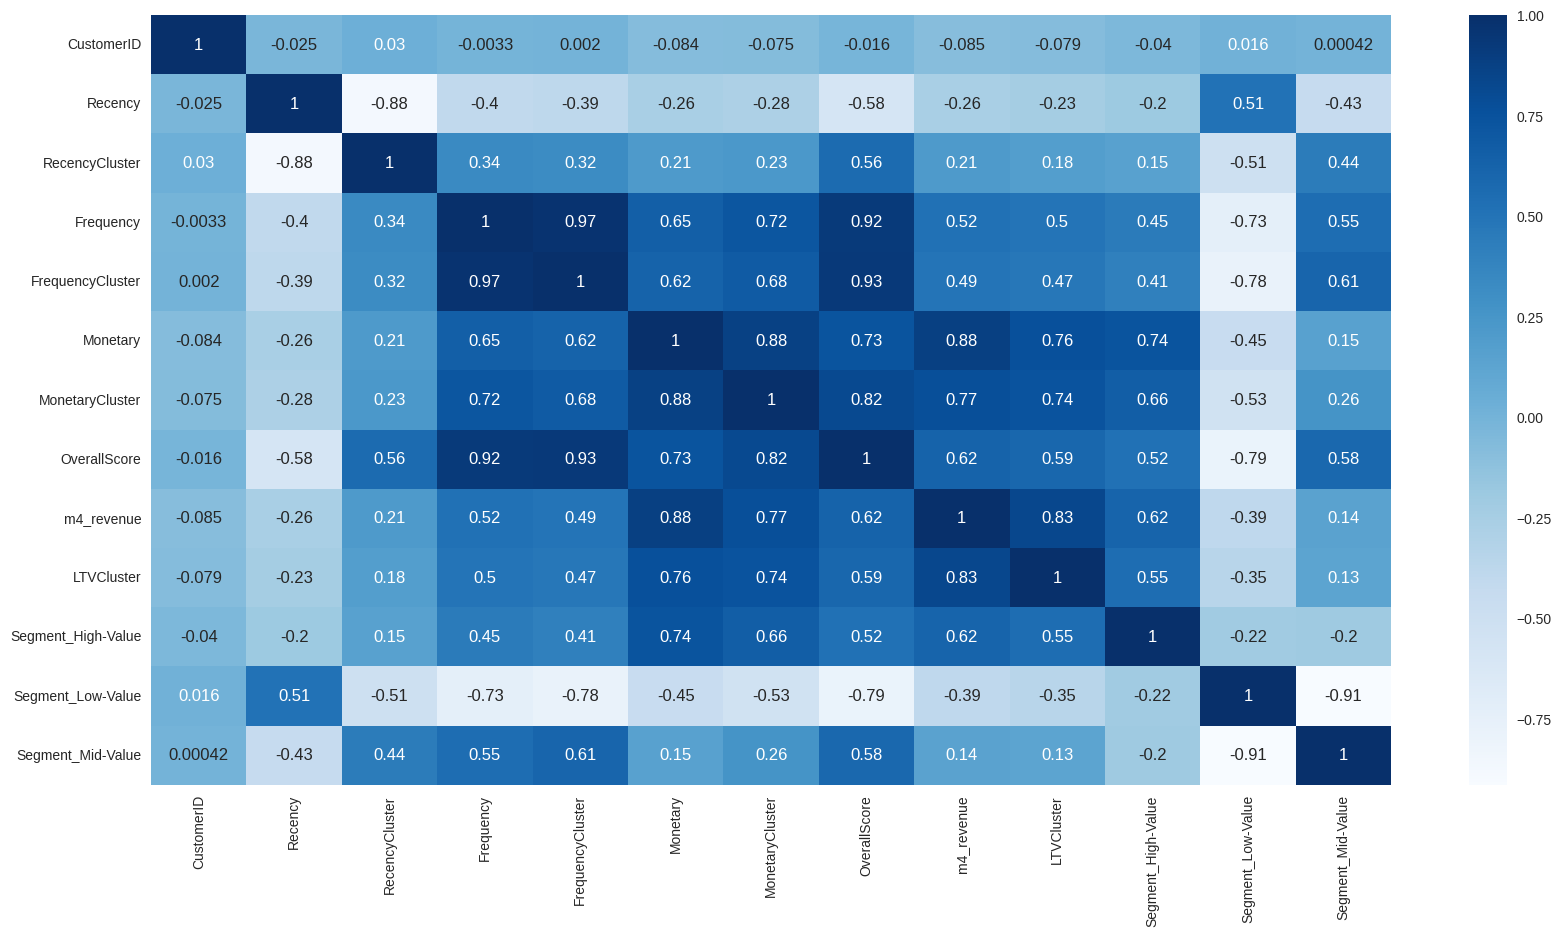

In [ ]:
#vẽ ma trận tương quan
plt.figure(figsize=(20,10))
sns.heatmap(df_class_xg.corr(), annot=True, cmap='Blues')

m4_revenue có tương quan đồng biến cao nhất với LTVCluster

In [ ]:
#tạo X và y, X sẽ là tập các đặc trưng và y là nhãn - LTV
X = df_class_xg.drop(['LTVCluster', 'm4_revenue'],axis=1)
y = df_class_xg['LTVCluster']

In [ ]:
#tách tập huấn luyện và tập kiểm tra
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
#XGBoost Multiclassification Model
#Kiểm tra độ chính xác của mô hình
import xgboost as xgb
import math
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print("RMSE: ", rmse)

Accuracy of XGB classifier on training set: 0.97
Accuracy of XGB classifier on test set: 0.92
R2 score: 0.4690449750138811
RMSE:  0.2858309752375147


In [ ]:
X_test

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
1672     13210.0     94.0               2        1.0                 0   
1907     15469.0     51.0               2        2.0                 0   
1247     15239.0     11.0               3        2.0                 0   
1146     14284.0     31.0               3        2.0                 0   
2817     14970.0     69.0               2        4.0                 1   
...          ...      ...             ...        ...               ...   
1048     13142.0     20.0               3        1.0                 0   
2851     15730.0     66.0               2        3.0                 1   
2603     16960.0     39.0               3        3.0                 1   
2344     14167.0     40.0               3        4.0                 1   
331      12989.0      4.0               3       11.0                 3   

      Monetary  MonetaryCluster  OverallScore  Segment_High-Value  \
1672    353.48                0             2                   0   
1907    538.55                0             2                   0   
1247    780.59                0             3                   0   
1146    595.25                0             3                   0   
2817   1592.06                0             3                   0   
...        ...              ...           ...                 ...   
1048    307.09                0             3                   0   
2851   1120.88                0             3                   0   
2603    507.05                0             4                   0   
2344    574.84                0             4                   0   
331    6924.11                2             8                   1   

      Segment_Low-Value  Segment_Mid-Value  
1672                  1                  0  
1907                  1                  0  
1247                  1                  0  
1146                  1                  0  
2817                  1                  0  
...                 ...                ...  
1048                  1                  0  
2851                  1                  0  
2603                  0                  1  
2344                  0                  1  
331                   0                  0  

[612 rows x 11 columns]

## Dự đoán cluster từ tháng trong năm sau

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       528
           1       0.67      0.68      0.68        76
           2       0.70      0.88      0.78         8

    accuracy                           0.92       612
   macro avg       0.78      0.84      0.80       612
weighted avg       0.92      0.92      0.92       612



In [ ]:
#Tỉ lệ khách hàng trong mỗi cụm
df_class_xg.groupby('LTVCluster').CustomerID.count()/df_class_xg.CustomerID.count()

LTVCluster
0    0.850883
1    0.136691
2    0.012426
Name: CustomerID, dtype: float64

In [ ]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
column = y_pred.reshape((-1, 1))
df_cluster_pred_xg = pd.DataFrame({'Cluster_pred': y_pred})
df_cluster_pred_xg

Cluster_pred
0               0
1               0
2               0
3               0
4               0
..            ...
607             0
608             0
609             0
610             0
611             1

[612 rows x 1 columns]

In [ ]:
y_test

1672    0
1907    0
1247    0
1146    0
2817    0
       ..
1048    0
2851    0
2603    0
2344    0
331     1
Name: LTVCluster, Length: 612, dtype: int64

In [ ]:
df_cluster_test_xg = pd.DataFrame({'Cluster_test': y_test})
df_cluster_test_xg

Cluster_test
1672             0
1907             0
1247             0
1146             0
2817             0
...            ...
1048             0
2851             0
2603             0
2344             0
331              1

[612 rows x 1 columns]

In [ ]:
df_merge_test_4m_xg = pd.merge(df_cluster_test_xg, df_user_4m_xg,left_index=True, right_index=True , how='left').reset_index()

In [ ]:
df_merge_test_4m_xg

index  Cluster_test  CustomerID  m4_revenue
0     1672             0     15567.0      186.01
1     1907             0     16020.0      851.01
2     1247             0     14731.0      129.00
3     1146             0     14533.0     1516.22
4     2817             0     17769.0     2169.25
..     ...           ...         ...         ...
607   1048             0     14354.0       87.78
608   2851             0     17839.0      338.80
609   2603             0     17361.0      224.28
610   2344             0     16869.0      437.74
611    331             1     12950.0      311.60

[612 rows x 4 columns]

In [ ]:
df_merge_cluster_xg = pd.merge(df_cluster_pred_xg, df_merge_test_4m_xg, left_index = True, right_index = True, how = 'left')
df_merge_cluster_xg

Cluster_pred  index  Cluster_test  CustomerID  m4_revenue
0               0   1672             0     15567.0      186.01
1               0   1907             0     16020.0      851.01
2               0   1247             0     14731.0      129.00
3               0   1146             0     14533.0     1516.22
4               0   2817             0     17769.0     2169.25
..            ...    ...           ...         ...         ...
607             0   1048             0     14354.0       87.78
608             0   2851             0     17839.0      338.80
609             0   2603             0     17361.0      224.28
610             0   2344             0     16869.0      437.74
611             1    331             1     12950.0      311.60

[612 rows x 5 columns]

##Dự đoán doanh thu trong 4 tháng

In [ ]:
df_class_xg

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0        12347.0      3.0               3        7.0                 2   
2710     12348.0     76.0               2        4.0                 1   
270      12349.0     19.0               3        1.0                 0   
418      12352.0     37.0               3        8.0                 2   
562      12356.0     23.0               3        3.0                 1   
...          ...      ...             ...        ...               ...   
2172     18277.0     59.0               2        1.0                 0   
2173     18278.0     74.0               2        1.0                 0   
1583     18282.0      8.0               3        2.0                 0   
803      18283.0      4.0               3       11.0                 3   
2709     18287.0     43.0               3        3.0                 1   

      Monetary  MonetaryCluster  OverallScore  m4_revenue  LTVCluster  \
0      4310.00                1             6     1879.23           1   
2710   1797.24                0             3      310.00           0   
270    1757.55                0             3     1757.55           1   
418    2506.04                1             6      944.23           0   
562    2811.43                1             5       58.35           0   
...        ...              ...           ...         ...         ...   
2172    110.38                0             2      110.38           0   
2173    173.90                0             2      173.90           0   
1583    178.05                0             3      100.21           0   
803    2094.88                1             7      901.11           0   
2709   1837.28                0             4     1072.00           0   

      Segment_High-Value  Segment_Low-Value  Segment_Mid-Value  
0                      0                  0                  1  
2710                   0                  1                  0  
270                    0                  1                  0  
418                    0                  0                  1  
562                    0                  0                  1  
...                  ...                ...                ...  
2172                   0                  1                  0  
2173                   0                  1                  0  
1583                   0                  1                  0  
803                    0                  0                  1  
2709                   0                  0                  1  

[3058 rows x 13 columns]

In [ ]:
df_class_Monetary_xg = df_class_xg.copy()

In [ ]:
df_class_Monetary_xg['Avg_Monetary'] = df_class_Monetary_xg['m4_revenue']/df_class_Monetary_xg['Frequency']
df_class_Monetary_xg

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0        12347.0      3.0               3        7.0                 2   
2710     12348.0     76.0               2        4.0                 1   
270      12349.0     19.0               3        1.0                 0   
418      12352.0     37.0               3        8.0                 2   
562      12356.0     23.0               3        3.0                 1   
...          ...      ...             ...        ...               ...   
2172     18277.0     59.0               2        1.0                 0   
2173     18278.0     74.0               2        1.0                 0   
1583     18282.0      8.0               3        2.0                 0   
803      18283.0      4.0               3       11.0                 3   
2709     18287.0     43.0               3        3.0                 1   

      Monetary  MonetaryCluster  OverallScore  m4_revenue  LTVCluster  \
0      4310.00                1             6     1879.23           1   
2710   1797.24                0             3      310.00           0   
270    1757.55                0             3     1757.55           1   
418    2506.04                1             6      944.23           0   
562    2811.43                1             5       58.35           0   
...        ...              ...           ...         ...         ...   
2172    110.38                0             2      110.38           0   
2173    173.90                0             2      173.90           0   
1583    178.05                0             3      100.21           0   
803    2094.88                1             7      901.11           0   
2709   1837.28                0             4     1072.00           0   

      Segment_High-Value  Segment_Low-Value  Segment_Mid-Value  Avg_Monetary  
0                      0                  0                  1    268.461429  
2710                   0                  1                  0     77.500000  
270                    0                  1                  0   1757.550000  
418                    0                  0                  1    118.028750  
562                    0                  0                  1     19.450000  
...                  ...                ...                ...           ...  
2172                   0                  1                  0    110.380000  
2173                   0                  1                  0    173.900000  
1583                   0                  1                  0     50.105000  
803                    0                  0                  1     81.919091  
2709                   0                  0                  1    357.333333  

[3058 rows x 14 columns]

In [ ]:
# Chọn các biến đầu vào RFM
Xm = df_class_Monetary_xg[[ 'Recency','Frequency', 'Avg_Monetary']] 

# Chọn biến đầu ra CLV
ym = df_class_Monetary_xg['m4_revenue']

# Chia tập dữ liệu thành tập train và test
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.2,random_state=0)

# Tạo mô hình XGBoost
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)

# Huấn luyện mô hình
xgb_model.fit(Xm_train, ym_train)

# Dự đoán CLV cho tập test
ym_pred = xgb_model.predict(Xm_test)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(Xm_train, ym_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(Xm_test[Xm_train.columns], ym_test)))

# Đánh giá mô hình bằng mean squared error

r2 = r2_score(ym_test, ym_pred)
print('R2 score:', r2)
mse = mean_squared_error(ym_test, ym_pred)

rmse = math.sqrt(mse)
print("RMSE: ", rmse)

Accuracy of XGB classifier on training set: 0.99
Accuracy of XGB classifier on test set: 0.98
R2 score: 0.9774616796624778
RMSE:  210.03474744076934


In [ ]:
ym1_pred = xgb_model.predict(Xm)

In [ ]:
ym1_pred

array([1814.9718  ,  317.8295  , 1601.673   , ...,   87.244606,
        935.4304  , 1091.918   ], dtype=float32)

In [ ]:
column = ym1_pred.reshape((-1, 1))
df_monetary1_pred_xg = pd.DataFrame({'Monetary_pred': ym1_pred})
df_monetary1_pred_xg

Monetary_pred
0       1814.971802
1        317.829498
2       1601.672974
3        923.508850
4         70.717018
...             ...
3053     106.614433
3054     170.625443
3055      87.244606
3056     935.430420
3057    1091.917969

[3058 rows x 1 columns]

In [ ]:
df_monetary_test_xg = pd.DataFrame({'Monetary_test': ym}).reset_index()
df_monetary_test_xg

index  Monetary_test
0         0        1879.23
1      2710         310.00
2       270        1757.55
3       418         944.23
4       562          58.35
...     ...            ...
3053   2172         110.38
3054   2173         173.90
3055   1583         100.21
3056    803         901.11
3057   2709        1072.00

[3058 rows x 2 columns]

In [ ]:
df_merge_monetary_4m_xg = pd.merge( df_monetary_test_xg,df_user_4m_xg,left_index=True, right_index=True , how='left')
df_merge_monetary_4m_xg

index  Monetary_test  CustomerID  m4_revenue
0         0        1879.23     12347.0     1879.23
1      2710         310.00     12348.0      310.00
2       270        1757.55     12349.0     1757.55
3       418         944.23     12352.0      944.23
4       562          58.35     12356.0       58.35
...     ...            ...         ...         ...
3053   2172         110.38     18277.0      110.38
3054   2173         173.90     18278.0      173.90
3055   1583         100.21     18282.0      100.21
3056    803         901.11     18283.0      901.11
3057   2709        1072.00     18287.0     1072.00

[3058 rows x 4 columns]

In [ ]:
df_merge_monetary_xg = pd.merge(df_monetary1_pred_xg, df_merge_monetary_4m_xg, left_index = True, right_index = True, how = 'left')
df_merge_monetary_xg

Monetary_pred  index  Monetary_test  CustomerID  m4_revenue
0       1814.971802      0        1879.23     12347.0     1879.23
1        317.829498   2710         310.00     12348.0      310.00
2       1601.672974    270        1757.55     12349.0     1757.55
3        923.508850    418         944.23     12352.0      944.23
4         70.717018    562          58.35     12356.0       58.35
...             ...    ...            ...         ...         ...
3053     106.614433   2172         110.38     18277.0      110.38
3054     170.625443   2173         173.90     18278.0      173.90
3055      87.244606   1583         100.21     18282.0      100.21
3056     935.430420    803         901.11     18283.0      901.11
3057    1091.917969   2709        1072.00     18287.0     1072.00

[3058 rows x 5 columns]

# Kết hợp các dataframe

In [ ]:
df_cluster_xg.groupby('LTVCluster')['m4_revenue'].describe()

count         mean          std      min        25%       50%  \
LTVCluster                                                                   
0           2602.0   532.106857   374.243700     6.20   234.2300   418.990   
1            418.0  2563.002105   914.952314  1551.47  1842.0500  2301.145   
2             38.0  8728.246579  2810.134127  5702.55  6401.1725  7955.075   

                   75%       max  
LTVCluster                        
0             758.4350   1547.14  
1            3008.2175   5590.04  
2           10473.5650  16074.50

In [ ]:
RFM_DB_3

CustomerID         Country  Recency  Frequency  Monetary  Avg_Monetary  \
0        12347.0         Iceland        3          7   4310.00     23.681319   
1        12348.0         Finland       76          4   1797.24     57.975484   
2        12349.0           Italy       19          1   1757.55     24.076027   
3        12350.0          Norway      311          1    334.40     19.670588   
4        12352.0          Norway       37          8   2506.04     29.482824   
...          ...             ...      ...        ...       ...           ...   
4229     18280.0  United Kingdom      278          1    180.60     18.060000   
4230     18281.0  United Kingdom      181          1     80.82     11.545714   
4231     18282.0  United Kingdom        8          2    178.05     14.837500   
4232     18283.0  United Kingdom        4         16   2094.88      2.771005   
4233     18287.0  United Kingdom       43          3   1837.28     26.246857   

      Tenure  Cluster2  
0        368         1  
1        359         1  
2         19         2  
3        311         2  
4        297         1  
...      ...       ...  
4229     278         2  
4230     181         2  
4231     127         0  
4232     338         1  
4233     202         0  

[4234 rows x 8 columns]

In [ ]:
df2_cltv_no_outlier

CustomerID  predicted_purchases        AOV       CLTV         Country  \
0        12347.0             1.863848  25.643311  47.795222         Iceland   
1        12348.0             1.073334  66.399972  71.269379         Finland   
2        12352.0             1.919811  31.561962  60.592990          Norway   
3        12356.0             0.734174  57.417340  42.154320        Portugal   
4        12358.0             0.848189  82.194059  69.716076         Austria   
...          ...                  ...        ...        ...             ...   
2347     18270.0             0.331382  34.866896  11.554257  United Kingdom   
2348     18272.0             1.778894  20.407181  36.302208  United Kingdom   
2349     18273.0             0.347825  81.736821  28.430097  United Kingdom   
2350     18283.0             3.455074   3.011754  10.405834  United Kingdom   
2351     18287.0             0.503178  31.835964  16.019145  United Kingdom   

      Recency  Frequency  Monetary  Avg_Monetary  Tenure  
0         3.0        7.0   4310.00     23.681319     368  
1        76.0        4.0   1797.24     57.975484     359  
2        37.0        8.0   2506.04     29.482824     297  
3        23.0        3.0   2811.43     47.651356     326  
4         2.0        2.0   1168.06     61.476842     151  
...       ...        ...       ...           ...     ...  
2347     39.0        2.0    283.15     25.740909     267  
2348      3.0        6.0   3078.58     18.545663     247  
2349      3.0        3.0    204.00     68.000000     258  
2350      4.0       11.0   2094.88      2.771005     338  
2351     43.0        3.0   1837.28     26.246857     202  

[2352 rows x 10 columns]

In [ ]:
df_cltv_dbscan=pd.merge(df2_cltv_no_outlier,RFM_DB_3, on=['CustomerID','Country','Recency','Frequency','Monetary','Avg_Monetary','Tenure'], how='left')
df_cltv_dbscan=df_cltv_dbscan.dropna()
df_cltv_dbscan

CustomerID  predicted_purchases        AOV       CLTV         Country  \
0        12347.0             1.863848  25.643311  47.795222         Iceland   
1        12348.0             1.073334  66.399972  71.269379         Finland   
2        12352.0             1.919811  31.561962  60.592990          Norway   
3        12356.0             0.734174  57.417340  42.154320        Portugal   
4        12358.0             0.848189  82.194059  69.716076         Austria   
...          ...                  ...        ...        ...             ...   
2360     18265.0             0.765821  23.852505  18.266743  United Kingdom   
2361     18270.0             0.331382  34.866896  11.554257  United Kingdom   
2362     18272.0             1.778894  20.407181  36.302208  United Kingdom   
2363     18273.0             0.347825  81.736821  28.430097  United Kingdom   
2365     18287.0             0.503178  31.835964  16.019145  United Kingdom   

      Recency  Frequency  Monetary  Avg_Monetary  Tenure  Cluster2  
0         3.0        7.0   4310.00     23.681319     368       1.0  
1        76.0        4.0   1797.24     57.975484     359       1.0  
2        37.0        8.0   2506.04     29.482824     297       1.0  
3        23.0        3.0   2811.43     47.651356     326       0.0  
4         2.0        2.0   1168.06     61.476842     151       0.0  
...       ...        ...       ...           ...     ...       ...  
2360     73.0        2.0    801.51     17.424130     159       0.0  
2361     39.0        2.0    283.15     25.740909     267       0.0  
2362      3.0        6.0   3078.58     18.545663     247       1.0  
2363      3.0        3.0    204.00     68.000000     258       0.0  
2365     43.0        3.0   1837.28     26.246857     202       0.0  

[2023 rows x 11 columns]

In [ ]:
#Sô lượng khách hàng trong mỗi cụm
df_cltv_dbscan.groupby('Cluster2')['CustomerID'].count()

Cluster2
0.0     970
1.0    1049
2.0       4
Name: CustomerID, dtype: int64

In [ ]:
df_cltv_dbscan_range=pd.DataFrame({'Max': df_cltv_dbscan.groupby('Cluster2')['CLTV'].max(),
                                   'Min': df_cltv_dbscan.groupby('Cluster2')['CLTV'].min()
    
}).reset_index()
df_cltv_dbscan_range['Range']=df_cltv_dbscan_range['Max']-df_cltv_dbscan_range['Min']
df_cltv_dbscan_range

Cluster2          Max        Min        Range
0       0.0  1407.394931   1.093351  1406.301580
1       1.0  1710.565030   0.959482  1709.605548
2       2.0    55.046513  18.525764    36.520748

In [ ]:
df_dbscan_cltv_avg=df_cltv_dbscan.groupby('Cluster2')['CLTV'].mean().reset_index()
df_dbscan_cltv_avg

Cluster2       CLTV
0       0.0  30.378989
1       1.0  45.315987
2       2.0  37.086041

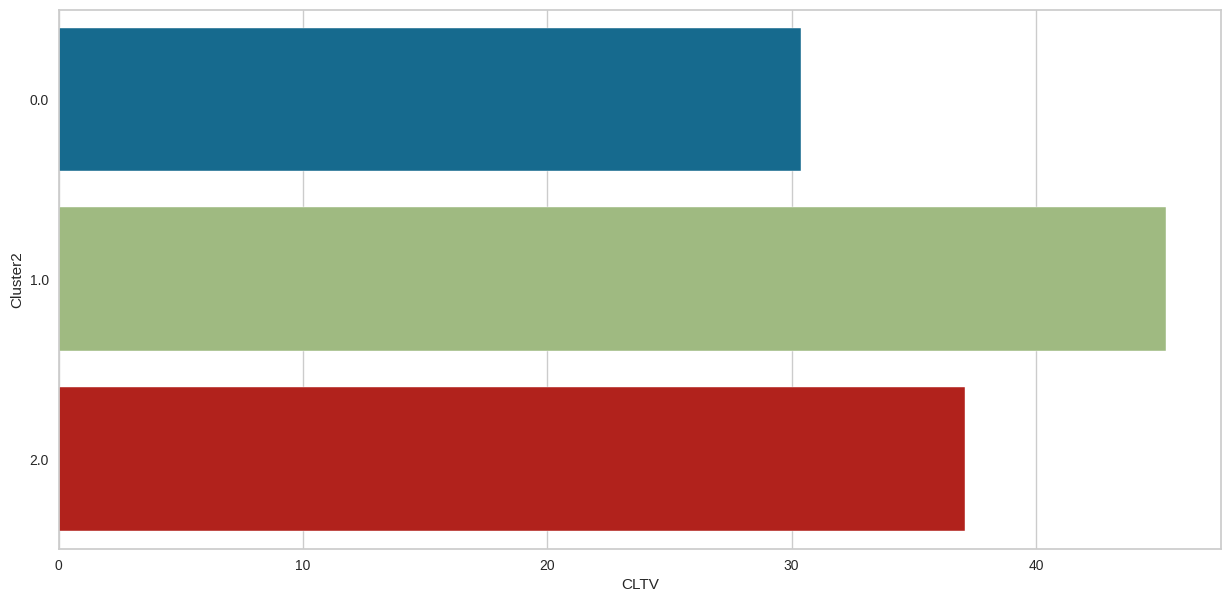

In [ ]:
plt.figure(figsize=(15,7))
sns.barplot(data=df_dbscan_cltv_avg.sort_values(by='CLTV', ascending=False),x='CLTV',y=df_dbscan_cltv_avg['Cluster2'].astype(str))
plt.show()

In [ ]:
df_user_xg

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0        12347.0      3.0               3        7.0                 2   
1        12352.0     37.0               3        8.0                 2   
2        12388.0     16.0               3        6.0                 2   
3        12417.0      4.0               3        8.0                 2   
4        12483.0     18.0               3        8.0                 2   
...          ...      ...             ...        ...               ...   
4302     17381.0      9.0               3       11.0                 3   
4303     17428.0      1.0               3       11.0                 3   
4304     17675.0      2.0               3       11.0                 3   
4305     17677.0      2.0               3       11.0                 3   
4306     17857.0      5.0               3       11.0                 3   

      Monetary  MonetaryCluster  OverallScore     Segment  
0      4310.00                1             6   Mid-Value  
1      2506.04                1             6   Mid-Value  
2      2780.66                1             6   Mid-Value  
3      3212.80                1             6   Mid-Value  
4      2484.98                1             6   Mid-Value  
...        ...              ...           ...         ...  
4302  20275.61                3             9  High-Value  
4303  17256.85                3             9  High-Value  
4304  20374.28                3             9  High-Value  
4305  16363.23                3             9  High-Value  
4306  26879.04                3             9  High-Value  

[4307 rows x 9 columns]

In [ ]:
df_xg_cltv=pd.merge(df_user_xg,df2_cltv_no_outlier,on=['CustomerID','Recency','Frequency','Monetary'], how='inner')
df_xg_cltv

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0        12347.0      3.0               3        7.0                 2   
1        12352.0     37.0               3        8.0                 2   
2        12388.0     16.0               3        6.0                 2   
3        12417.0      4.0               3        8.0                 2   
4        12483.0     18.0               3        8.0                 2   
...          ...      ...             ...        ...               ...   
2339     17381.0      9.0               3       11.0                 3   
2340     17428.0      1.0               3       11.0                 3   
2341     17675.0      2.0               3       11.0                 3   
2342     17677.0      2.0               3       11.0                 3   
2343     17857.0      5.0               3       11.0                 3   

      Monetary  MonetaryCluster  OverallScore     Segment  \
0      4310.00                1             6   Mid-Value   
1      2506.04                1             6   Mid-Value   
2      2780.66                1             6   Mid-Value   
3      3212.80                1             6   Mid-Value   
4      2484.98                1             6   Mid-Value   
...        ...              ...           ...         ...   
2339  20275.61                3             9  High-Value   
2340  17256.85                3             9  High-Value   
2341  20374.28                3             9  High-Value   
2342  16363.23                3             9  High-Value   
2343  26879.04                3             9  High-Value   

      predicted_purchases         AOV         CLTV         Country  \
0                1.863848   25.643311    47.795222         Iceland   
1                1.919811   31.561962    60.592990          Norway   
2                1.689783   30.491383    51.523832       Australia   
3                2.356556   20.406764    48.089681         Belgium   
4                2.061993   35.450284    73.098250          Sweden   
...                   ...         ...          ...             ...   
2339             5.881255  194.795732  1145.643371  United Kingdom   
2340             5.551291   55.175990   306.297977  United Kingdom   
2341             8.041340   30.358184   244.120464  United Kingdom   
2342             3.909594   56.446639   220.683443  United Kingdom   
2343             3.950125  521.070080  2058.291807  United Kingdom   

      Avg_Monetary  Tenure  
0        23.681319     368  
1        29.482824     297  
2        27.806600     327  
3        19.010651     358  
4        33.133067     340  
...            ...     ...  
2339    186.014771     373  
2340     52.612348     369  
2341     28.899688     368  
2342     53.826414     369  
2343    497.760000     366  

[2344 rows x 15 columns]

In [ ]:
#số lượng khách hàng trong mỗi segment
df_xg_cltv.groupby('Segment')['CustomerID'].count()

Segment
High-Value     136
Low-Value      972
Mid-Value     1236
Name: CustomerID, dtype: int64

In [ ]:
#range
df_xg_cltv_range=pd.DataFrame({'Max': df_xg_cltv.groupby('Segment')['CLTV'].max(),
                                   'Min': df_xg_cltv.groupby('Segment')['CLTV'].min()
    
}).reset_index()
df_xg_cltv_range['Range']=df_xg_cltv_range['Max']-df_xg_cltv_range['Min']
df_xg_cltv_range

Segment          Max        Min        Range
0  High-Value  2715.293225  25.098445  2690.194781
1   Low-Value   799.009539   1.093351   797.916187
2   Mid-Value  1710.565030   0.959482  1709.605548

In [ ]:
df_xg_cltv_avg=df_xg_cltv.groupby('Segment')['CLTV'].mean().reset_index()
df_xg_cltv_avg

Segment        CLTV
0  High-Value  241.013084
1   Low-Value   34.801830
2   Mid-Value   49.714705

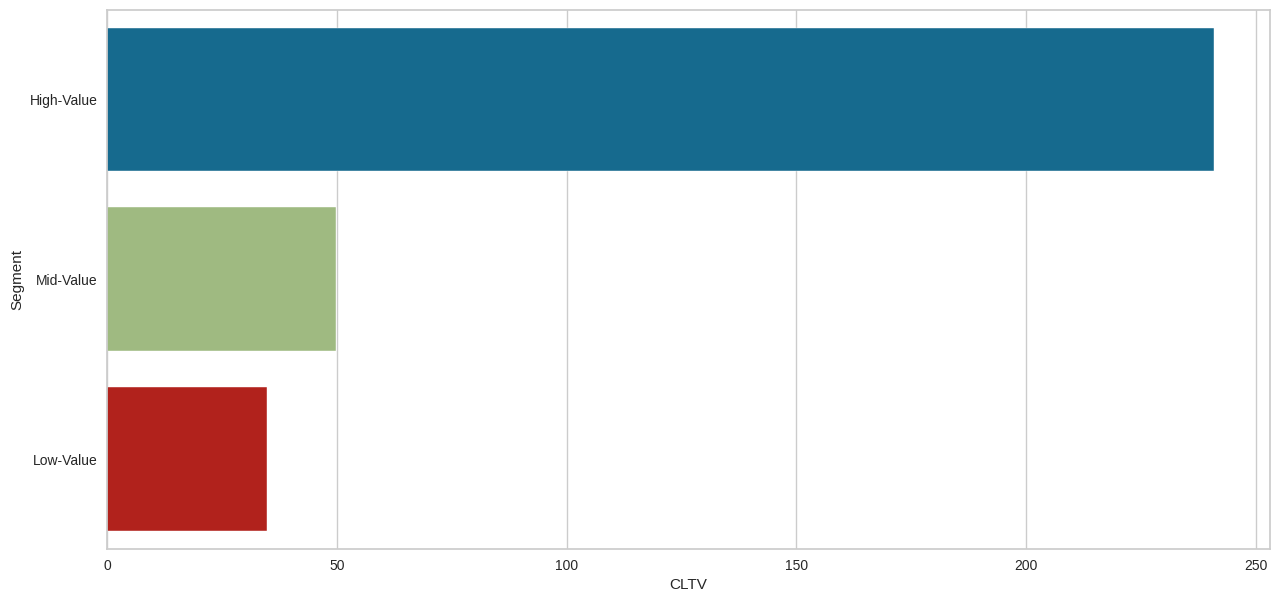

In [ ]:
plt.figure(figsize=(15,7))
sns.barplot(data=df_xg_cltv_avg.sort_values(by='CLTV', ascending=False),x='CLTV',y='Segment')
plt.show()


In [ ]:
#sự chuyển dịch nhóm theo dự đoán từ xgboost trong 4 tháng tới
#dataframe chứa cột cluster khách hàng hiện tại (DBSCAN+K-means) và cluster tương lai (XGBoost)
df_xg_dbscan_k_mean=pd.merge(df_merge_4m_xg,RFM_DB_3, on=['CustomerID','Recency','Frequency','Monetary'], how='inner')
df_xg_dbscan_k_mean

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0        12347.0      3.0               3        7.0                 2   
1        12484.0     33.0               3        6.0                 2   
2        12562.0      9.0               3        7.0                 2   
3        12627.0     11.0               3        7.0                 2   
4        12685.0     29.0               3        6.0                 2   
...          ...      ...             ...        ...               ...   
2758     17750.0      6.0               3        9.0                 3   
2759     17800.0     38.0               3        9.0                 3   
2760     12766.0      4.0               3        7.0                 2   
2761     13225.0      4.0               3        7.0                 2   
2762     18139.0     18.0               3        6.0                 2   

      Monetary  MonetaryCluster  OverallScore    Segment  m4_revenue  \
0      4310.00                1             6  Mid-Value     1879.23   
1      4541.72                1             6  Mid-Value     2265.06   
2      3781.74                1             6  Mid-Value     2172.14   
3      4478.53                1             6  Mid-Value     3710.51   
4      2863.08                1             6  Mid-Value     2863.08   
...        ...              ...           ...        ...         ...   
2758   1797.57                0             6  Mid-Value      845.19   
2759   1199.01                0             6  Mid-Value      603.51   
2760   6989.63                2             7  Mid-Value     1319.01   
2761   6463.84                2             7  Mid-Value      801.08   
2762   8438.34                2             7  Mid-Value     8438.34   

      LTVCluster         Country  Avg_Monetary  Tenure  Cluster2  
0              1         Iceland     23.681319     368         1  
1              1           Spain     13.126358     337         1  
2              1          France     22.510357     199         1  
3              1         Germany     19.471870     141         1  
4              1          France     18.236178      94         1  
...          ...             ...           ...     ...       ...  
2758           0  United Kingdom      9.313834     165         1  
2759           0  United Kingdom     11.528942     335         1  
2760           0        Portugal     22.547194     367         1  
2761           0  United Kingdom    201.995000     362         1  
2762           2  United Kingdom     53.071321      19         1  

[2763 rows x 15 columns]

In [ ]:
df_xg_dbscan_k_mean_no_customer=df_xg_dbscan_k_mean.groupby('LTVCluster')['CustomerID'].count().reset_index()
df_xg_dbscan_k_mean_no_customer

LTVCluster  CustomerID
0           0        2514
1           1         248
2           2           1

In [ ]:
#high value phân bố ở đâu
df_highvalue=df_xg_cltv[df_xg_cltv['Segment']=='High-Value']
df_highvalue

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
2203     12428.0     26.0               3        9.0                 3   
2204     12474.0     18.0               3       11.0                 3   
2205     12476.0     16.0               3       11.0                 3   
2206     12540.0     20.0               3       11.0                 3   
2207     12567.0     23.0               3       10.0                 3   
...          ...      ...             ...        ...               ...   
2339     17381.0      9.0               3       11.0                 3   
2340     17428.0      1.0               3       11.0                 3   
2341     17675.0      2.0               3       11.0                 3   
2342     17677.0      2.0               3       11.0                 3   
2343     17857.0      5.0               3       11.0                 3   

      Monetary  MonetaryCluster  OverallScore     Segment  \
2203   7956.46                2             8  High-Value   
2204   7375.79                2             8  High-Value   
2205   6816.42                2             8  High-Value   
2206  13400.24                2             8  High-Value   
2207   9401.28                2             8  High-Value   
...        ...              ...           ...         ...   
2339  20275.61                3             9  High-Value   
2340  17256.85                3             9  High-Value   
2341  20374.28                3             9  High-Value   
2342  16363.23                3             9  High-Value   
2343  26879.04                3             9  High-Value   

      predicted_purchases         AOV         CLTV         Country  \
2203             2.618804   28.758321    75.312410         Finland   
2204             4.984950   18.318076    91.314700         Germany   
2205             2.323526   30.730078    71.402120         Germany   
2206             3.585000   29.452123   105.585855           Spain   
2207             2.260167   22.288151    50.374938          France   
...                   ...         ...          ...             ...   
2339             5.881255  194.795732  1145.643371  United Kingdom   
2340             5.551291   55.175990   306.297977  United Kingdom   
2341             8.041340   30.358184   244.120464  United Kingdom   
2342             3.909594   56.446639   220.683443  United Kingdom   
2343             3.950125  521.070080  2058.291807  United Kingdom   

      Avg_Monetary  Tenure  
2203     27.062789     284  
2204     17.395731     330  
2205     29.255021     362  
2206     28.033975     362  
2207     21.079103     370  
...            ...     ...  
2339    186.014771     373  
2340     52.612348     369  
2341     28.899688     368  
2342     53.826414     369  
2343    497.760000     366  

[136 rows x 15 columns]

In [ ]:
#khách hàng thuộc nhóm high value phân bố ở quốc gia nào
df_country_highvalue=df_highvalue.groupby('Country')['CustomerID'].count().reset_index()
df_country_highvalue

Country  CustomerID
0         Finland           1
1          France           7
2         Germany           7
3           Japan           1
4        Portugal           1
5           Spain           1
6  United Kingdom         118